In [1]:
import SimpleITK as sitk
import numpy as np

In [2]:
im = sitk.ReadImage("output/stacked_voi_sample.mha")

In [5]:
arr = sitk.GetArrayFromImage(im)

In [19]:
arr.shape
num_segments = len(np.unique(arr))
print(f"Number of segments in the image: {num_segments}")
print(f"Type of the image array: {arr.dtype}")

Number of segments in the image: 2
Type of the image array: int8


In [24]:
import os
import time
import json
import torch
from scipy import ndimage
import SimpleITK as sitk
import numpy as np
from pathlib import Path
from evalutils import SegmentationAlgorithm
import argparse
from sklearn.preprocessing import MinMaxScaler

import os

import sys
from segformer3d import build_segformer3d_model

import yaml


class Predictor:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def normalize(self, x:np.ndarray)->np.ndarray:
        # Transform features by scaling each feature to a given range.
        scaler = MinMaxScaler(feature_range=(0, 1))
        print(f"Max value in input: {np.max(x)}")
        
        # (H, W, D) -> (H * W, D)
        normalized_1D_array = scaler.fit_transform(x.reshape(-1, x.shape[-1]))
        normalized_data = normalized_1D_array.reshape(x.shape)
        return normalized_data

    def predict_single_npy_array(self, npy_array, metadata, batch_size, fold, is_label):
        # Convert numpy array to torch tensor
        input = self.normalize(npy_array)  # Normalize the input
        # Convert to torch tensor
        input = torch.from_numpy(npy_array).float().to(self.device)
        # Add channel and batch dimension if needed
        input = input.unsqueeze(0)
        with torch.no_grad():
            # Ensure the model is in evaluation mode
            self.model.eval()
            # Forward pass through the model
            output = self.model(input)
            # Apply sigmoid to get probabilities
            output = torch.sigmoid(output)
            output = output > 0.5  # Binarize the output
            # Get the predicted class (argmax)
            prediction = output[0, 1, ...].cpu().numpy()  # Take the second channel
            prediction = prediction.astype(np.int8)  # Cast predictions to integers

            return prediction

class Uls23(SegmentationAlgorithm):
    def __init__(self):
        self.image_metadata = None  # Keep track of the metadata of the input volume
        self.id = None  # Keep track of batched volume file name for export
        self.z_size = 128  # Number of voxels in the z-dimension for each input VOI
        self.xy_size = 256  # Number of voxels in the xy-dimensions for each input VOI
        self.z_size_model = 64 # Number of voxels in the z-dimension that the model takes
        self.xy_size_model = 128 # Number of voxels in the xy-dimensions that the model takes
        self.device = torch.device("cuda")
        self.predictor = None # nnUnet predictor

    def start_pipeline(self):
        """
        Starts inference algorithm
        """
        start_time = time.time()
        
        # We need to create the correct output folder, determined by the interface, ourselves
        os.makedirs("output/images/ct-binary-uls/", exist_ok=True)

        self.load_model()
        spacings = self.load_data()
        predictions = self.predict(spacings)
        return self.postprocess(predictions)

        end_time = time.time()
        print(f"Total job runtime: {end_time - start_time}s")


    def load_model(self):
        start_model_load_time = time.time()

        config_path = Path(f"all_data_checkpoint_segformer/config.yaml")
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)

        model = build_segformer3d_model(config=config)

        # Load the state dict from the .bin file
        model_bin_path = Path(f"all_data_checkpoint_segformer/pytorch_model.bin")
        state_dict = torch.load(model_bin_path, map_location="cpu")
        model.load_state_dict(state_dict)
        model = model.to(self.device)
        self.predictor = Predictor(model, self.device)
        
        end_model_load_time = time.time()
        print(f"Model loading runtime: {end_model_load_time - start_model_load_time}s")

    def load_data(self):
        """
        1) Loads the .mha files containing the VOI stacks in the input directory
        2) Unstacks them into individual lesion VOI's
        3) Optional: preprocess volumes
        4) Predict per VOI
        """
        start_load_time = time.time()
        
        # Input directory is determined by the algorithm interface on GC
        input_dir = Path("architecture/input/images/stacked-3d-ct-lesion-volumes/")

        # Load the spacings per VOI
        with open(Path("architecture/input/stacked-3d-volumetric-spacings.json"), 'r') as json_file:
            spacings = json.load(json_file)


        for input_file in input_dir.glob("*.mha"):

            self.id = input_file

            # Load and keep track of the image metadata
            self.image_metadata = sitk.ReadImage(input_file)

            self.original_orientation = sitk.DICOMOrientImageFilter.GetOrientationFromDirectionCosines(self.image_metadata.GetDirection())
            print(f"Original orientation: {self.original_orientation}")
            #self.image_metadata = sitk.DICOMOrient(self.image_metadata, 'RAS')  # Ensure RAS orientation

            # Now get the image data
            image_data = sitk.GetArrayFromImage(self.image_metadata)

            for i in range(int(image_data.shape[0] / self.z_size)):
                voi = image_data[self.z_size * i:self.z_size * (i + 1), :, :]

                # Convert the VOI back to a SimpleITK image
                voi_image = sitk.GetImageFromArray(voi)

                # Calculate and set the metadata for the unstacked VOI
                original_origin = self.image_metadata.GetOrigin()
                original_spacing = self.image_metadata.GetSpacing()
                new_origin = [
                    original_origin[0],  # x-origin remains the same
                    original_origin[1],  # y-origin remains the same
                    original_origin[2] + i * self.z_size * original_spacing[2],  # Adjust z-origin for each VOI
                ]
                voi_image.SetOrigin(new_origin)
                voi_image.SetSpacing(original_spacing)
                voi_image.SetDirection(self.image_metadata.GetDirection())

                # Define the cropping region in physical space
                voi_shape = voi_image.GetSize()
                start_index = [64, 64, 32]  # Start indices for cropping
                crop_size = [128, 128, 64]  # Size of the cropped region

                # Perform cropping using SimpleITK
                voi_cropped = sitk.RegionOfInterest(voi_image, size=crop_size, index=start_index)

                # Update the origin of the cropped VOI
                cropped_origin = [
                    voi_image.GetOrigin()[0] + start_index[0] * voi_image.GetSpacing()[0],
                    voi_image.GetOrigin()[1] + start_index[1] * voi_image.GetSpacing()[1],
                    voi_image.GetOrigin()[2] + start_index[2] * voi_image.GetSpacing()[2],
                ]
                voi_cropped.SetOrigin(cropped_origin)
                voi_cropped.SetSpacing(voi_image.GetSpacing())
                voi_cropped.SetDirection(voi_image.GetDirection())
                
                # Save the cropped VOI to a binary file
                voi_cropped_array = sitk.GetArrayFromImage(voi_cropped)
                np.save(f"./tmp/voi_{i}.npy", np.array([voi_cropped_array]))  # Add dummy batch dimension for nnUnet
                
        end_load_time = time.time()
        print(f"Data pre-processing runtime: {end_load_time - start_load_time}s")

        return spacings

    def predict(self, spacings):
        """
        Runs nnUnet inference on the images, then moves to post-processing
        :param spacings: list containing the spacing per VOI
        :return: list of numpy arrays containing the predicted lesion masks per VOI
        """
        start_inference_time = time.time()
        predictions = []
        
        for i, voi_spacing in enumerate(spacings):
            # Load the 3D array from the binary file
            voi = np.load(f"./tmp/voi_{i}.npy")

            print(f'\nPredicting image of shape: {voi.shape}, spacing: {voi_spacing}')
            predictions.append(self.predictor.predict_single_npy_array(voi, {'spacing': voi_spacing}, None, None, False))

            print(f"Unique values in prediction: {np.unique(predictions[-1])}")
            print(f"Prediction shape: {predictions[-1].shape}")
            print(f"Prediction dtype: {predictions[-1].dtype}")

        end_inference_time = time.time()
        print(f"Total inference runtime: {end_inference_time - start_inference_time}s")
        return predictions

    def postprocess(self, predictions):
        """
        Runs post-processing and saves predictions for each VOI.
        :param predictions: list of numpy arrays containing the predicted lesion masks per VOI
        """
        start_postprocessing_time = time.time()

        for i, segmentation in enumerate(predictions):
            print(f"Post-processing prediction {i}")
            dif_values = np.unique(segmentation)
            print(f"Unique values in segmentation: {dif_values}")
            # Find the largest connected component in the segmentation
            instance_mask, num_features = ndimage.label(segmentation)
            print(f"Number of foreground voxels: {np.sum(segmentation)}")
            print(f"Number of background voxels: {np.sum(segmentation == 0)}")
            print(f"Unique values in instance mask: {np.unique(instance_mask)}")
            print(f"Number of features found: {num_features}")
            if num_features > 1:
                print("Found multiple lesion predictions")
                # Find the largest component by voxel count
                component_sizes = np.bincount(instance_mask.ravel())
                # Ignore background (component 0)
                print(f"Component sizes: {component_sizes}")
                component_sizes[0] = 0
                largest_component = component_sizes.argmax()
                print(f"Largest component index: {largest_component}, size: {component_sizes[largest_component]}")
                # Keep only the largest component
                segmentation[instance_mask != largest_component] = 0
                segmentation[segmentation != 0] = 1

            dif_values = np.unique(segmentation)
            print(f"Unique values after finding largest connected component: {dif_values}")

            # Pad segmentations to fit with original image size
            segmentation_pad = np.pad(segmentation, 
                                    ((32, 32),   
                                    (64, 64),
                                    (64, 64)),
                                    mode='constant', constant_values=0)

            # Convert padded segmentation and original segmentation back to a SimpleITK image
            segmentation_image = sitk.GetImageFromArray(segmentation_pad)
            segmentation_original = sitk.GetImageFromArray(segmentation)
            
            # Update the origin to account for the padding
            voi_origin = segmentation_original.GetOrigin() 
            voi_spacing = segmentation_original.GetSpacing()
            voi_direction = segmentation_original.GetDirection()
            
            new_origin = [
                voi_origin[0] - 32 * voi_spacing[0],  # Adjust for z padding
                voi_origin[1] - 64 * voi_spacing[1],  # Adjust for x padding
                voi_origin[2] - 64 * voi_spacing[2],  # Adjust for y padding
            ]
            segmentation_image.SetOrigin(new_origin)
            segmentation_image.SetDirection(voi_direction)
            segmentation_image.SetSpacing(voi_spacing)

            # Save the updated segmentation image
            predictions[i] = sitk.GetArrayFromImage(segmentation_image)

        predictions = np.concatenate(predictions, axis=0)  # Stack predictions

        # Create mask image and copy over metadata
        mask = sitk.GetImageFromArray(predictions)
        mask.CopyInformation(self.image_metadata)
        # We reset the orientation that we changed earlier
        #mask = sitk.DICOMOrient(mask, self.original_orientation)
        
        return mask

Model loading runtime: 0.24887323379516602s
Original orientation: RAS
Data pre-processing runtime: 0.34542012214660645s

Predicting image of shape: (1, 64, 128, 128), spacing: [0.703125, 0.703125, 1.2449597120285034]
Max value in input: 3071.0
Unique values in prediction: [0 1]
Prediction shape: (64, 128, 128)
Prediction dtype: int8

Predicting image of shape: (1, 64, 128, 128), spacing: [0.97265625, 0.97265625, 1.0]
Max value in input: 1403.0
Unique values in prediction: [0 1]
Prediction shape: (64, 128, 128)
Prediction dtype: int8

Predicting image of shape: (1, 64, 128, 128), spacing: [0.7630000114440918, 0.7630000114440918, 0.800000011920929]
Max value in input: 1078.0
Unique values in prediction: [0 1]
Prediction shape: (64, 128, 128)
Prediction dtype: int8

Predicting image of shape: (1, 64, 128, 128), spacing: [0.8574219942092896, 0.8574219942092896, 1.0]
Max value in input: 2501.0
Unique values in prediction: [0 1]
Prediction shape: (64, 128, 128)
Prediction dtype: int8
Total i

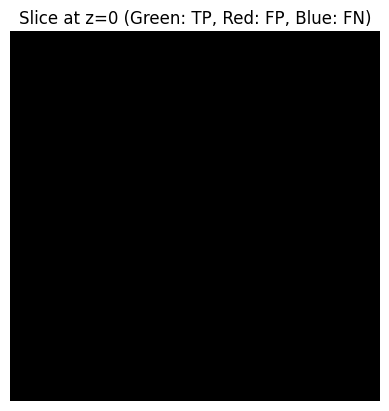

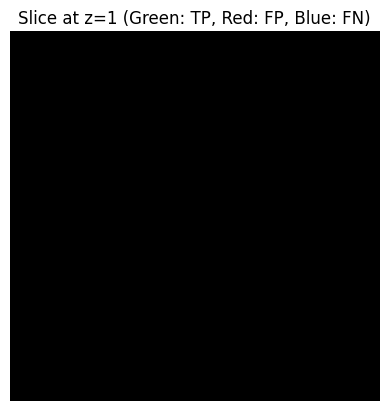

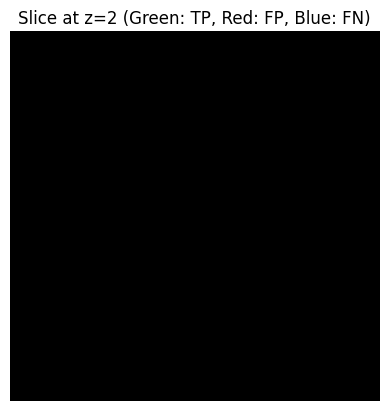

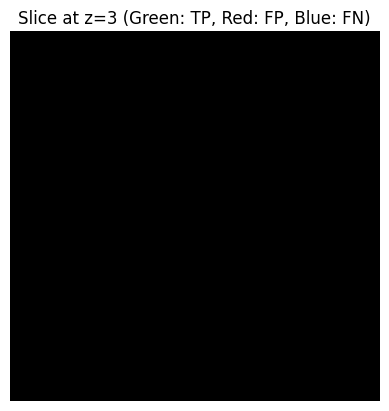

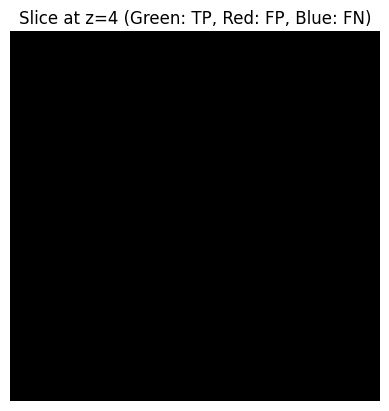

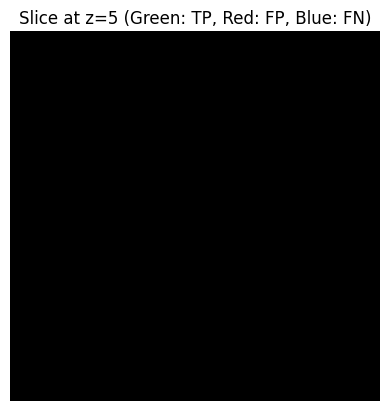

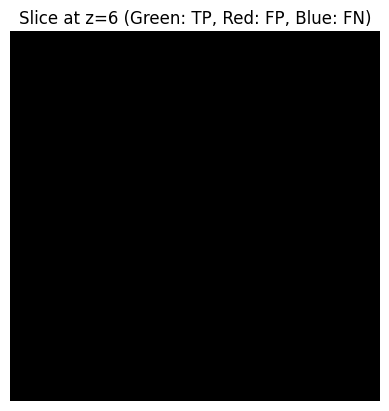

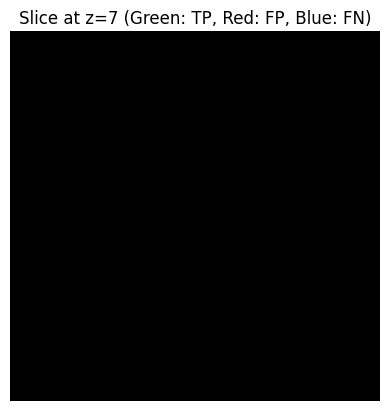

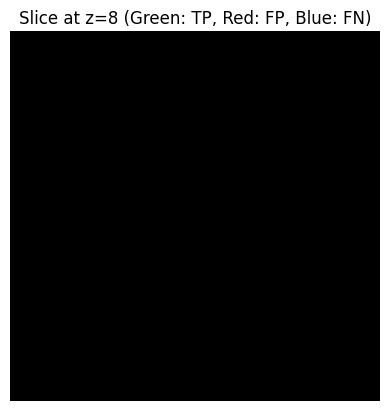

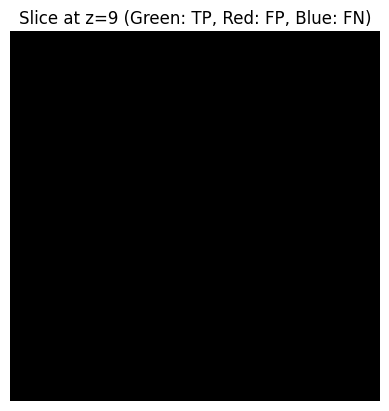

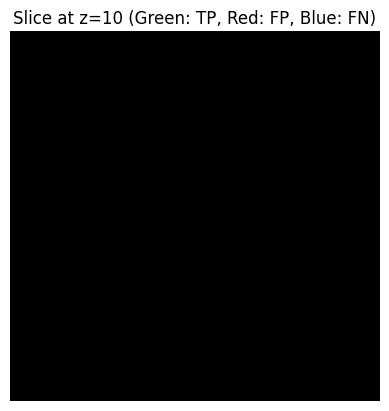

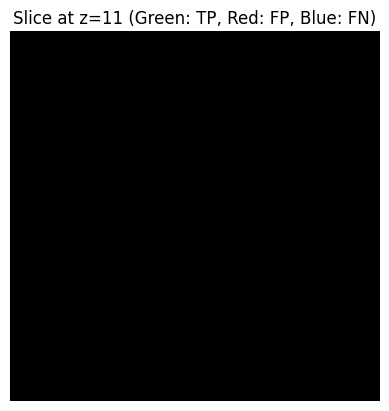

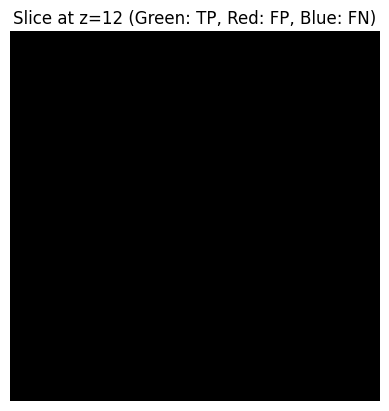

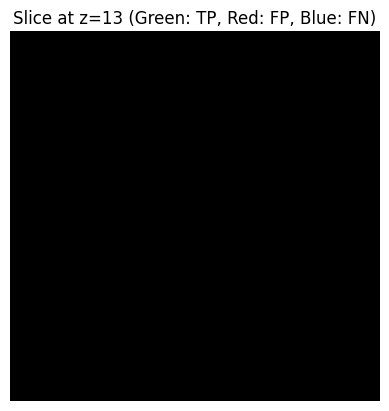

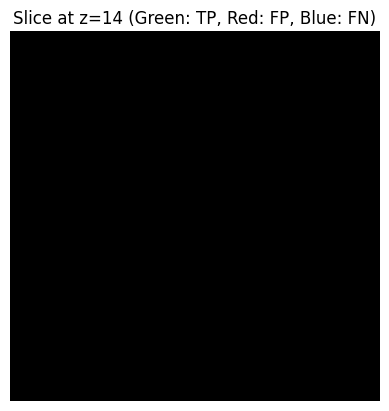

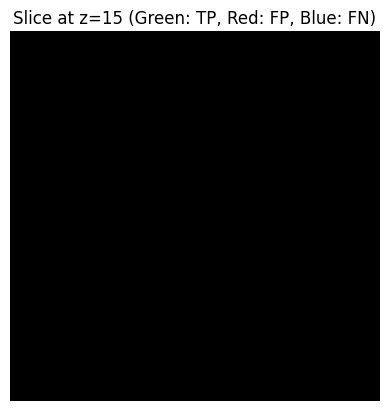

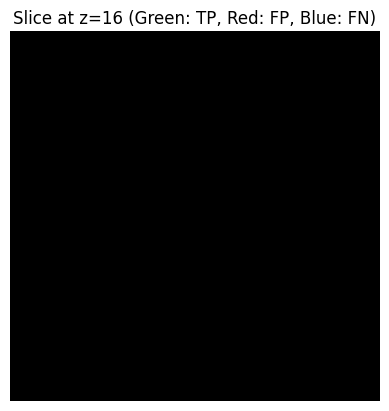

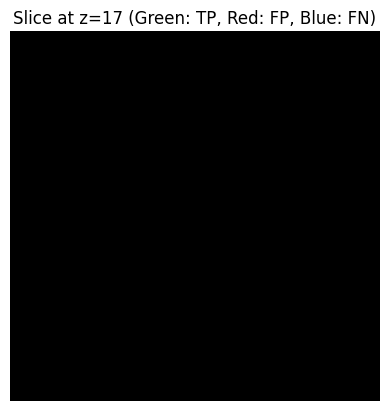

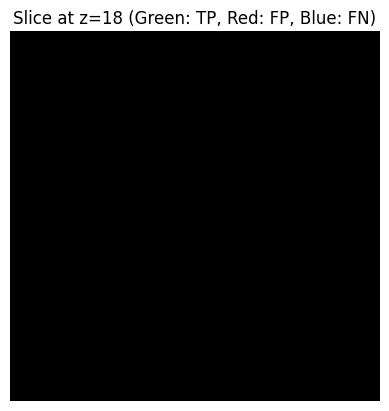

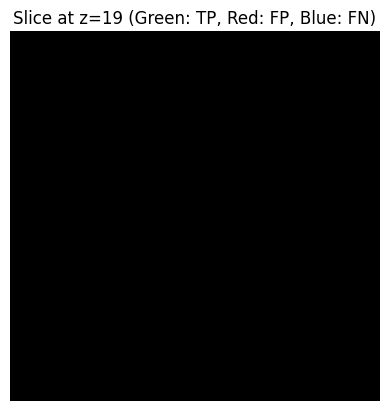

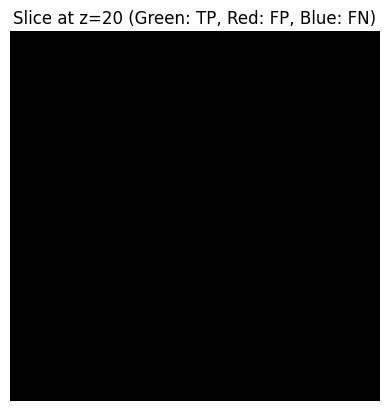

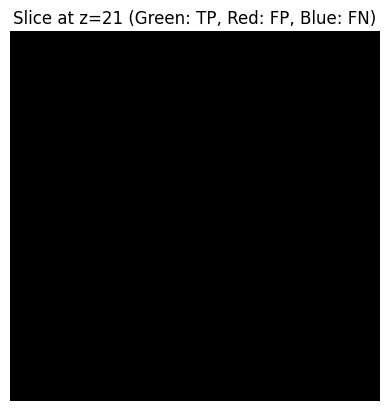

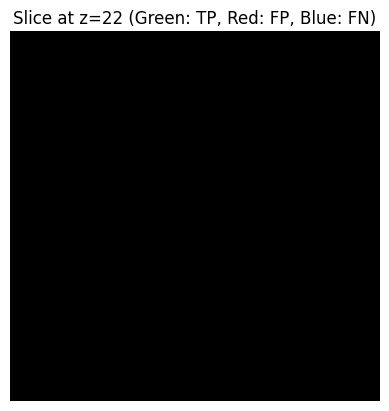

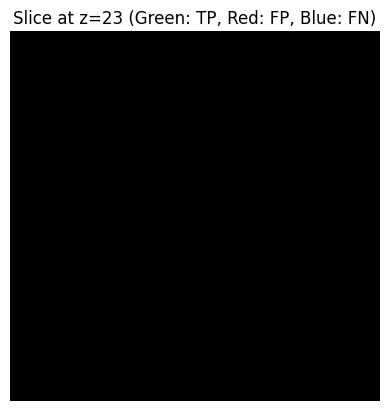

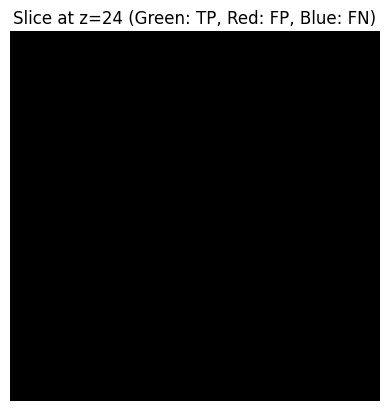

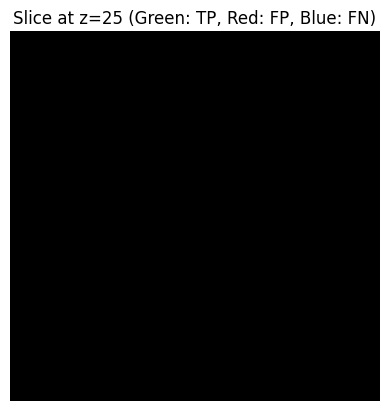

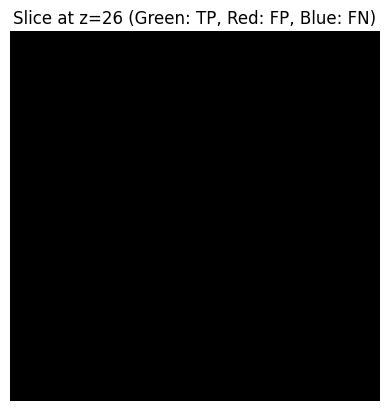

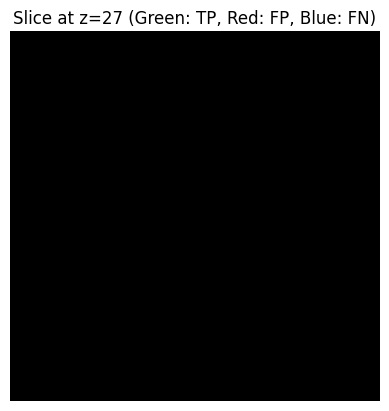

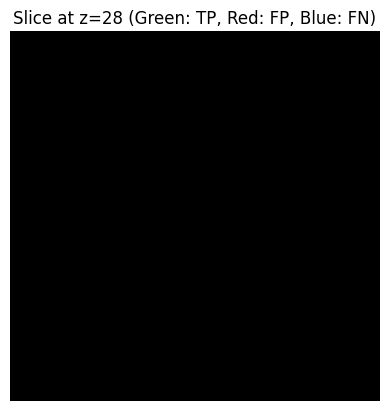

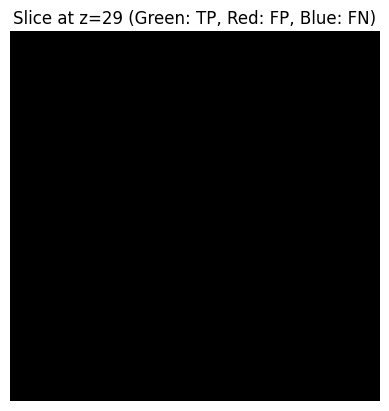

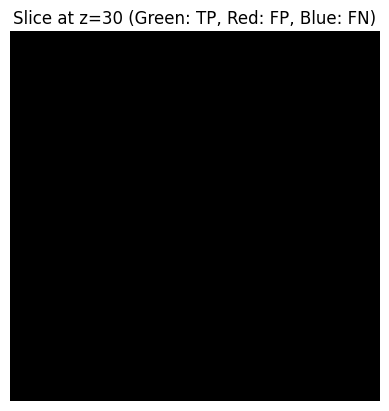

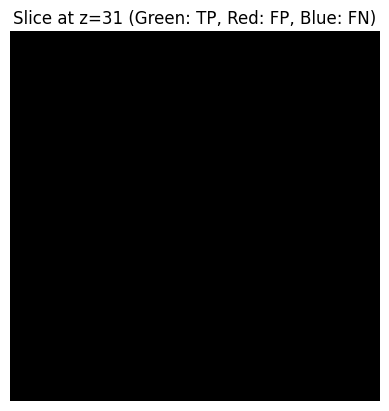

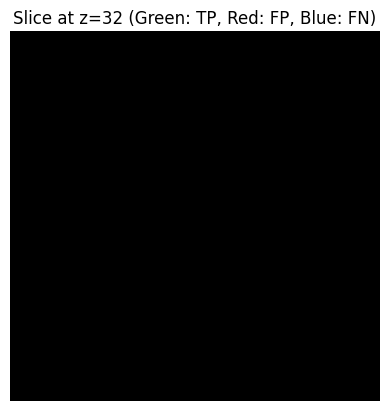

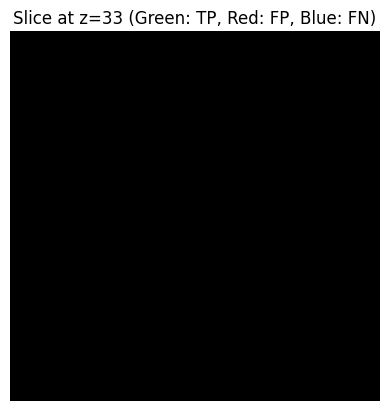

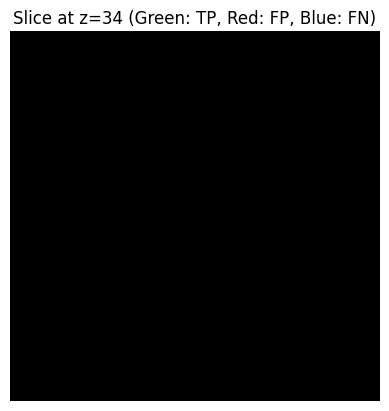

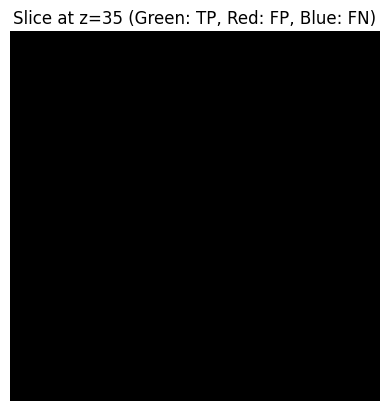

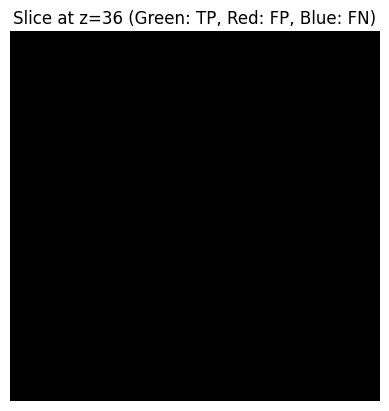

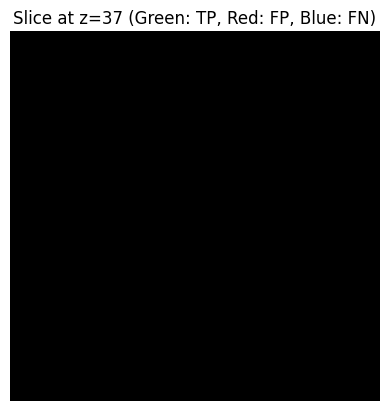

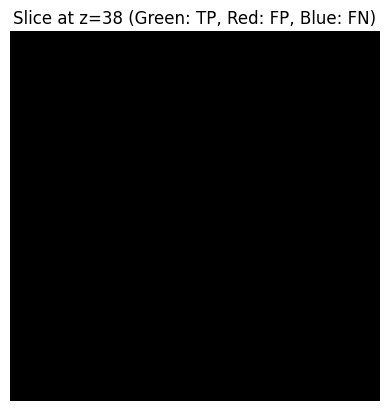

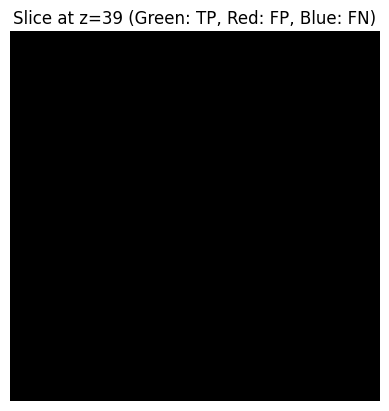

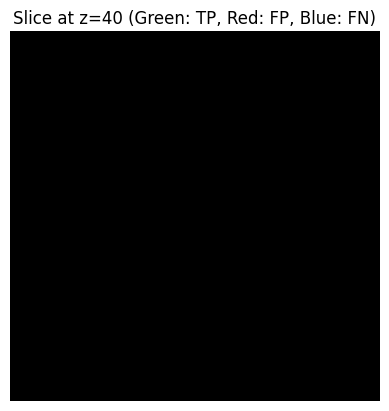

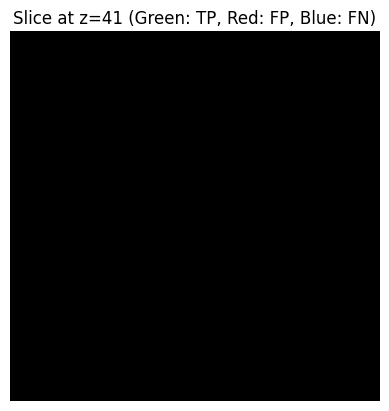

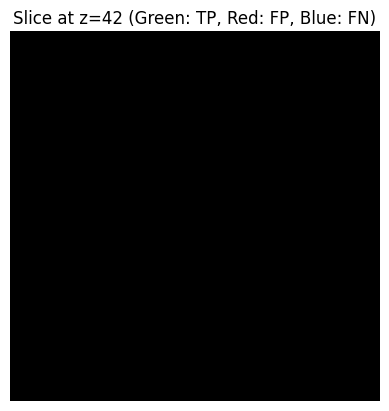

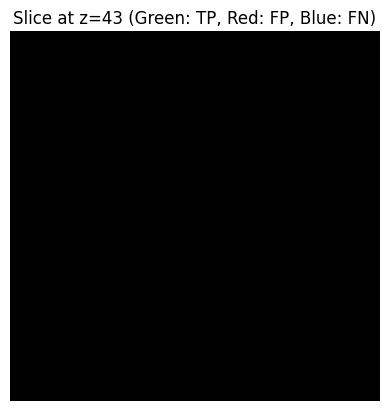

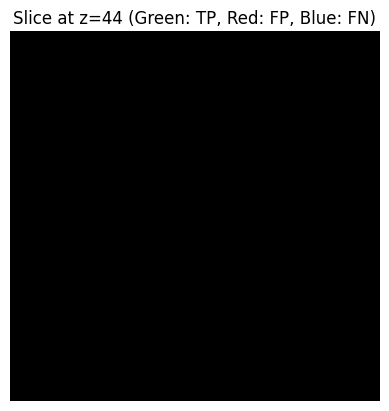

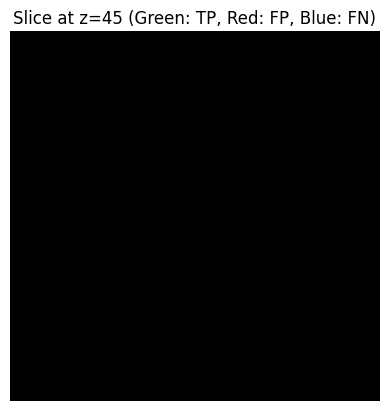

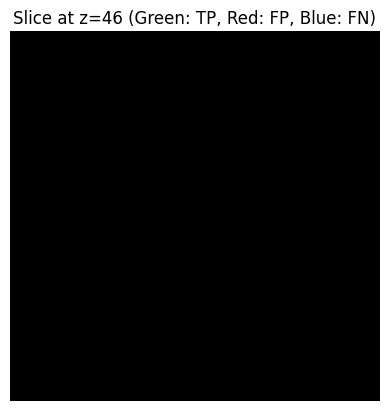

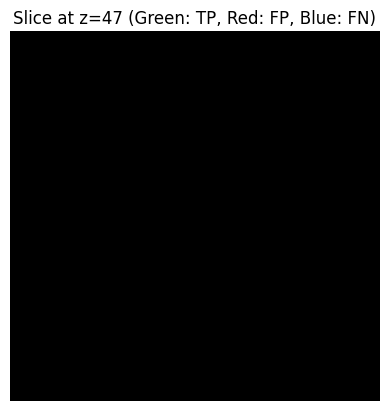

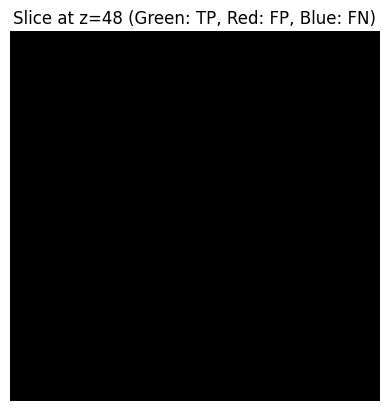

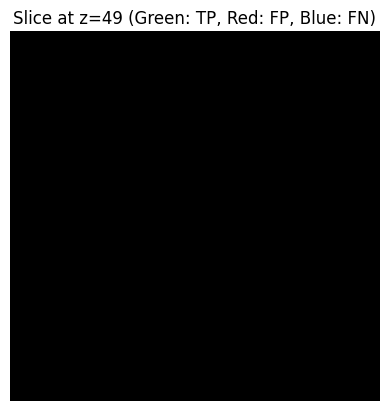

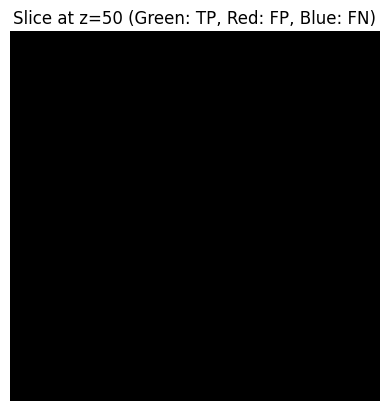

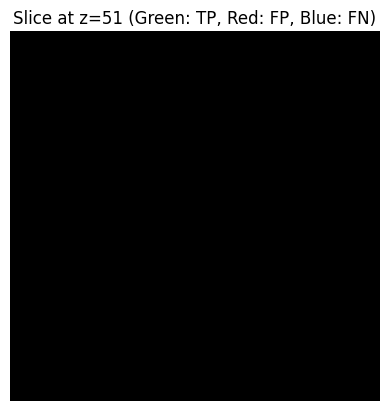

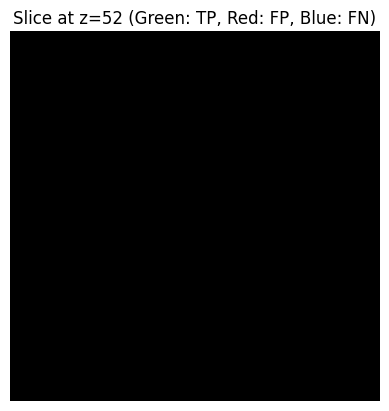

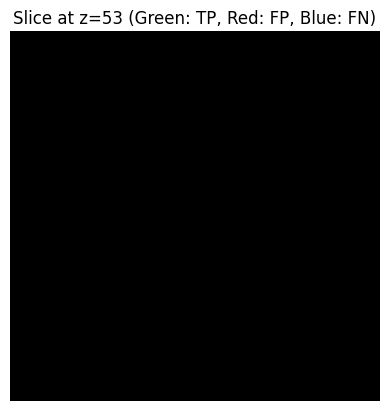

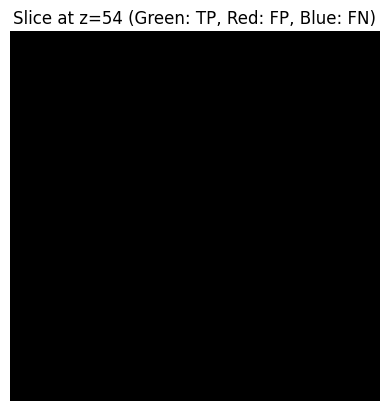

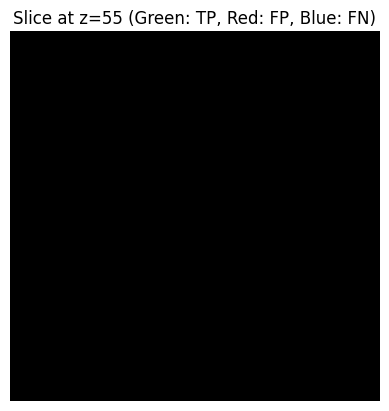

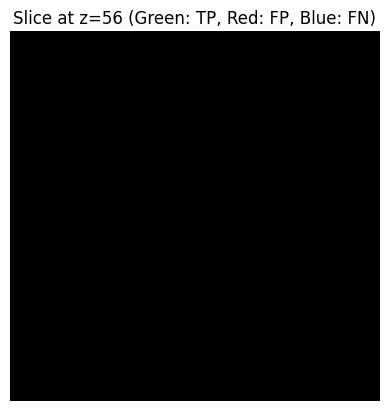

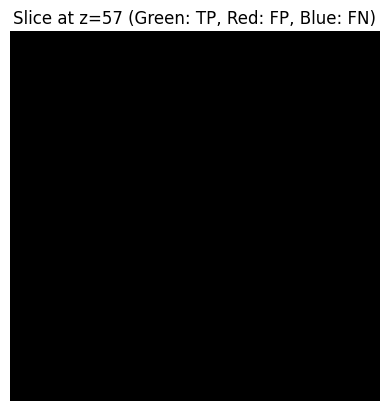

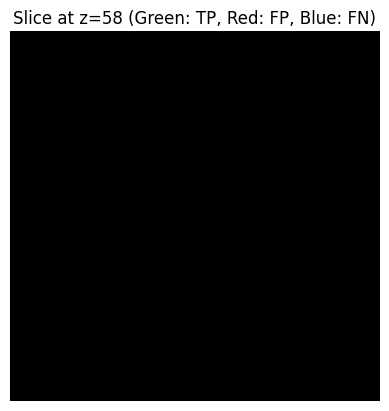

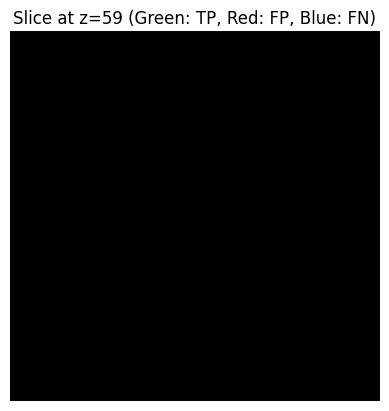

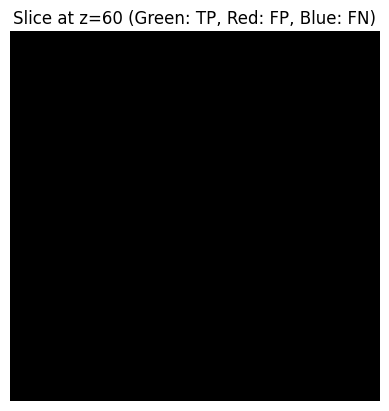

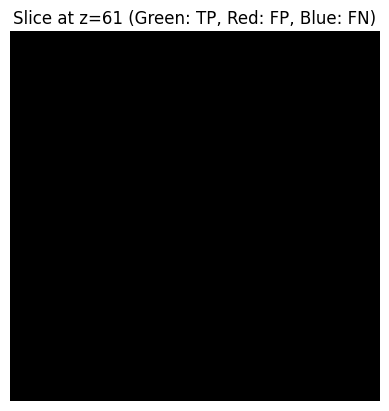

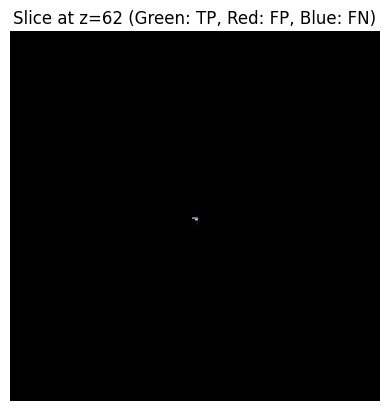

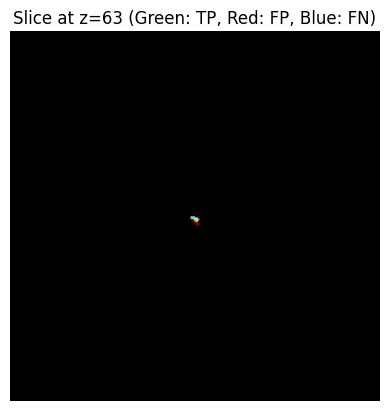

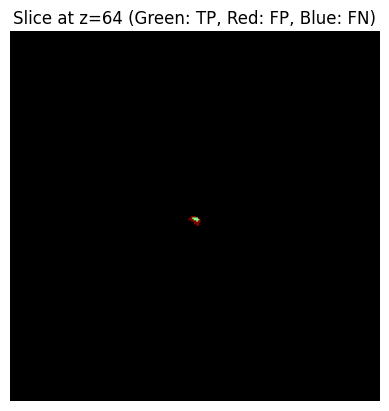

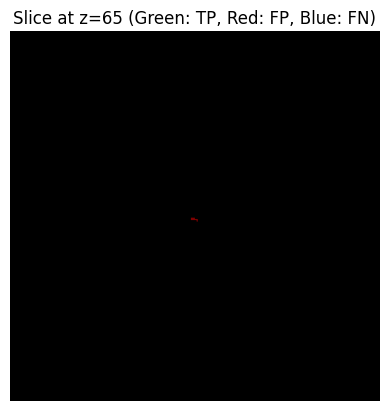

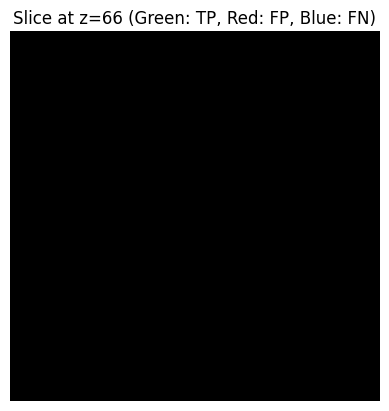

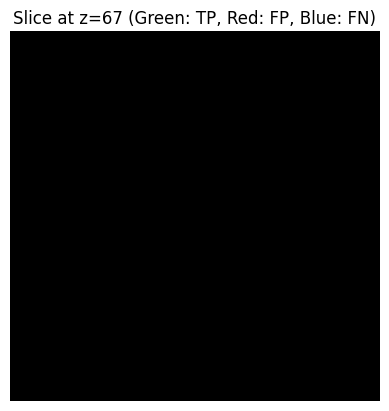

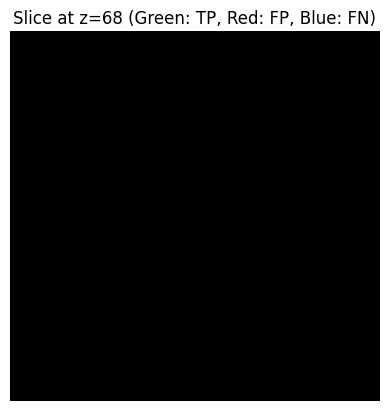

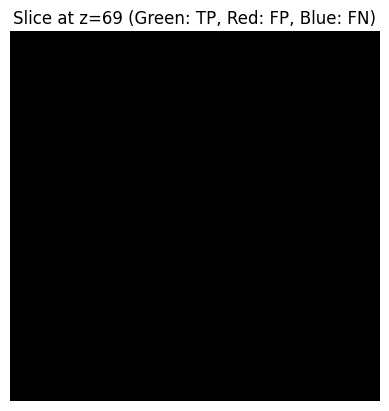

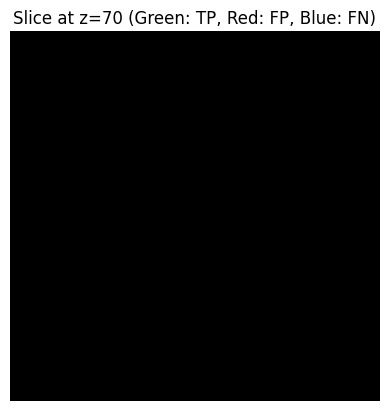

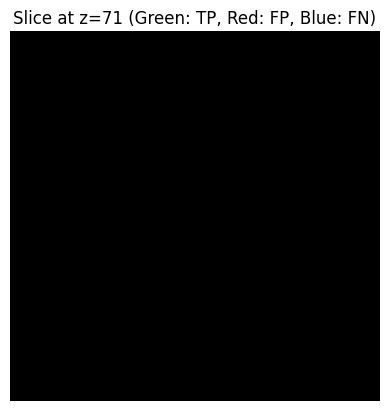

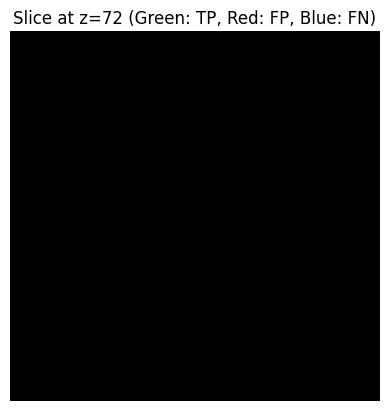

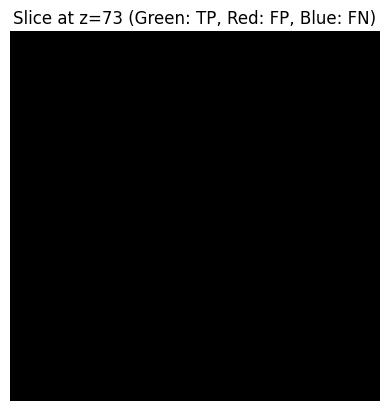

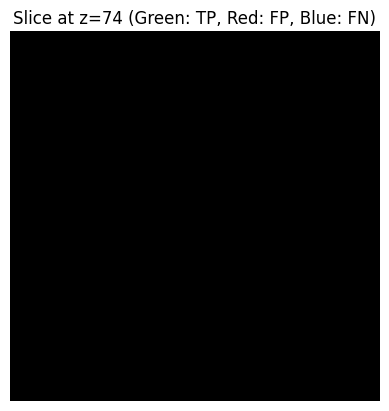

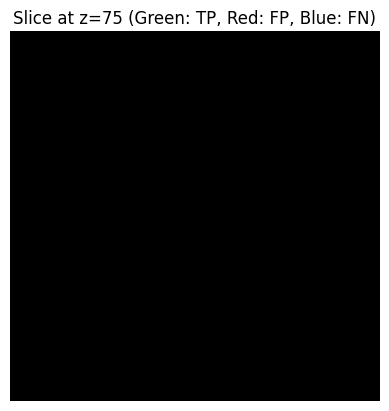

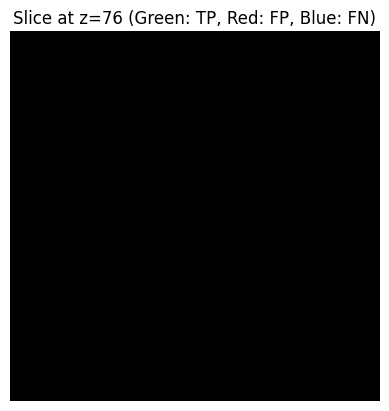

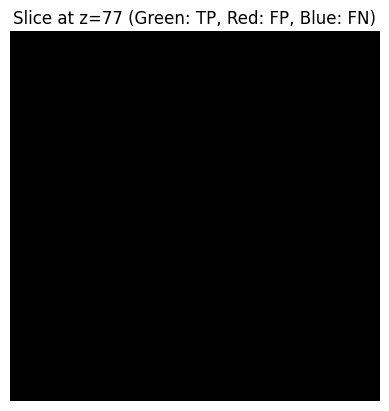

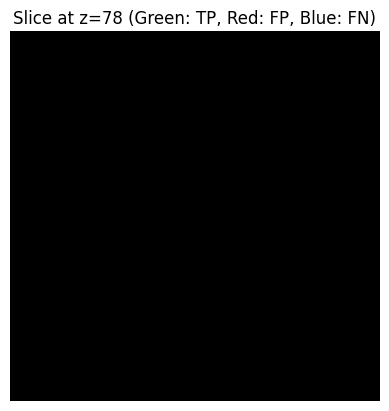

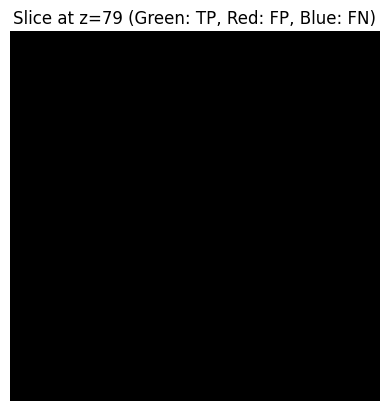

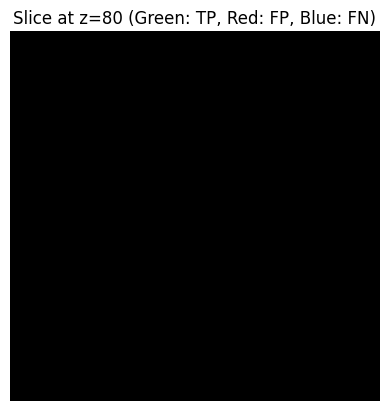

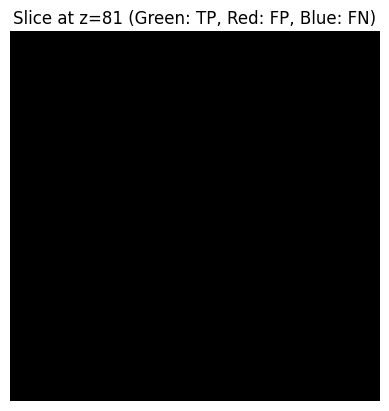

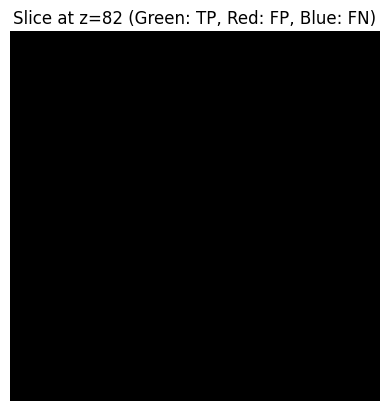

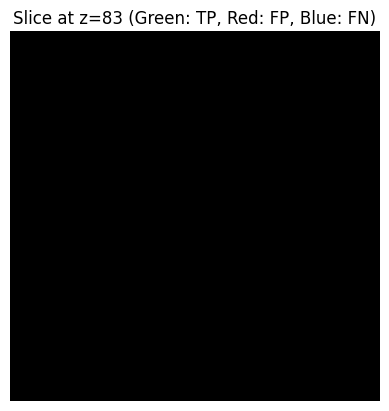

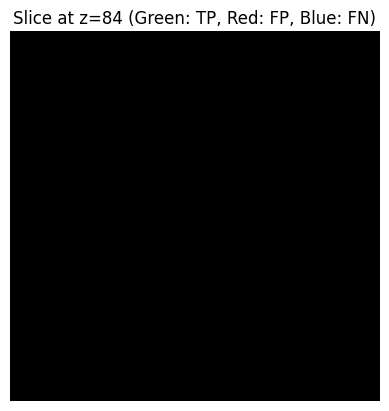

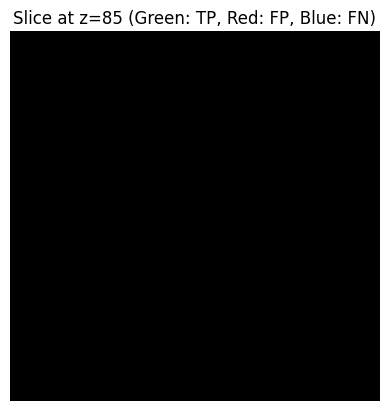

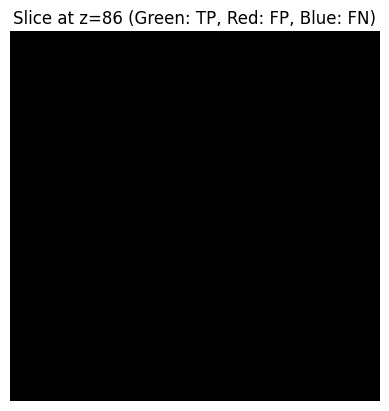

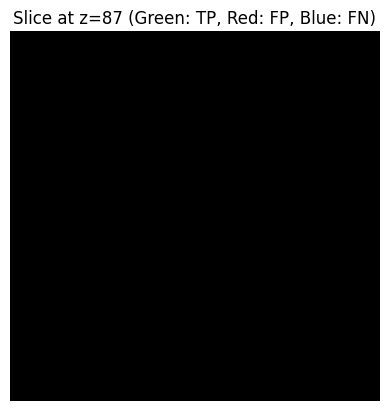

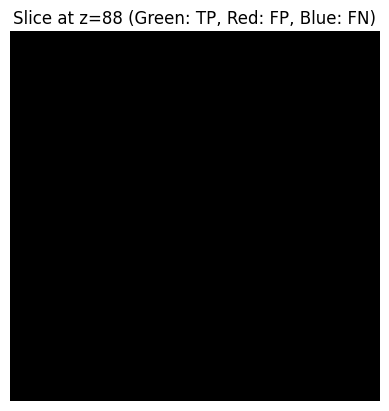

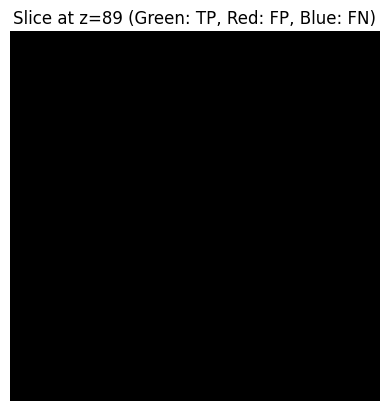

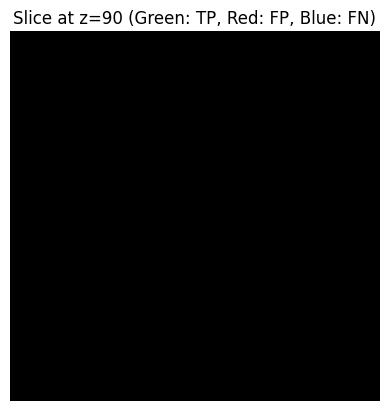

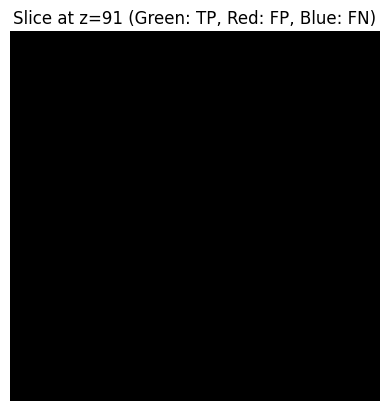

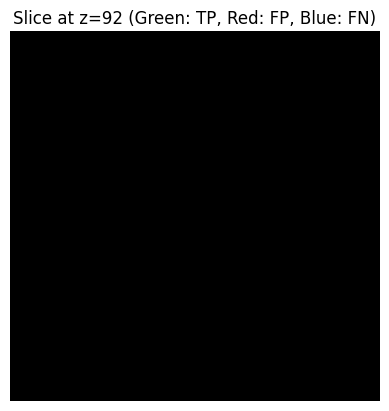

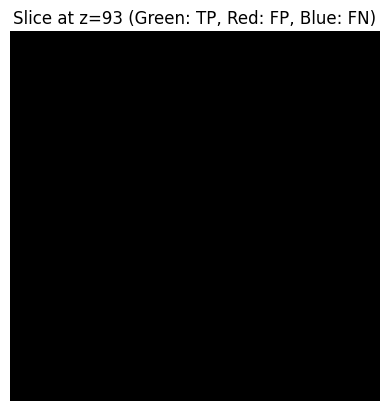

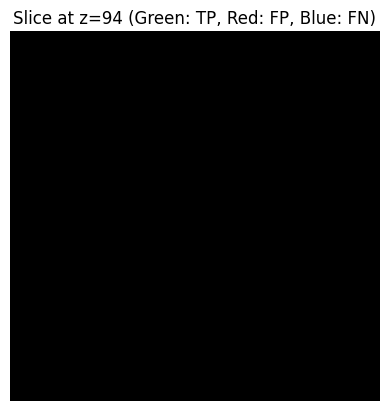

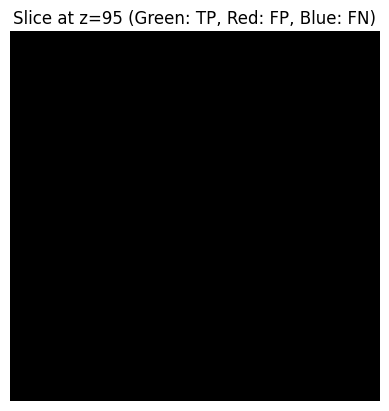

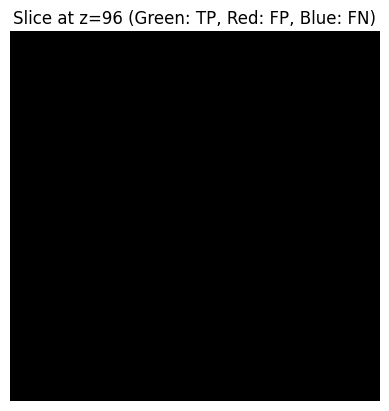

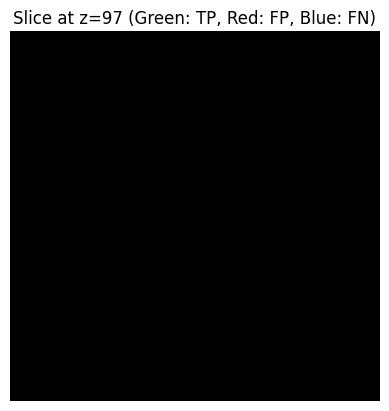

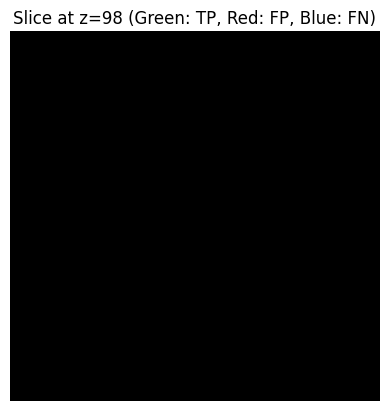

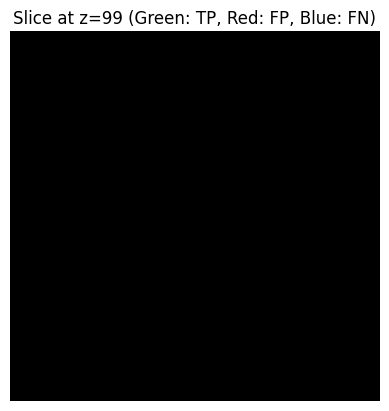

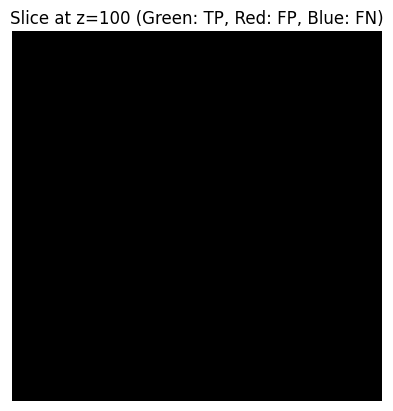

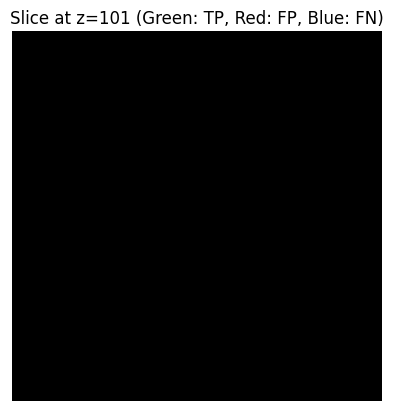

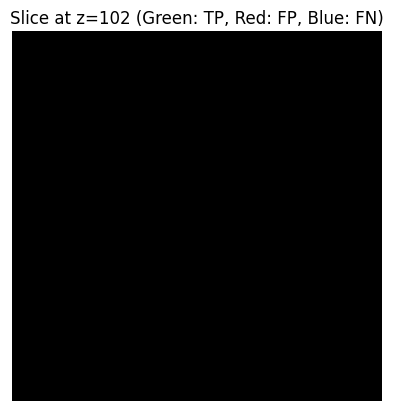

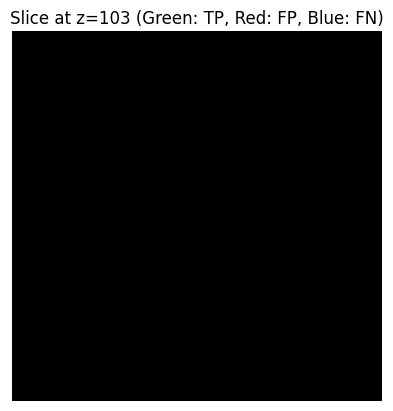

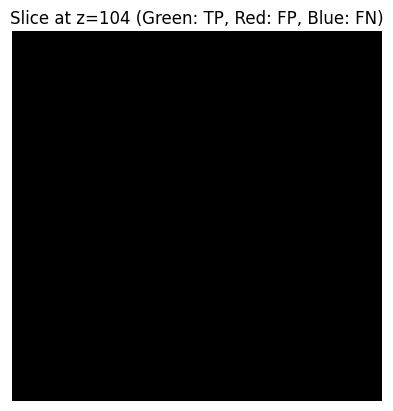

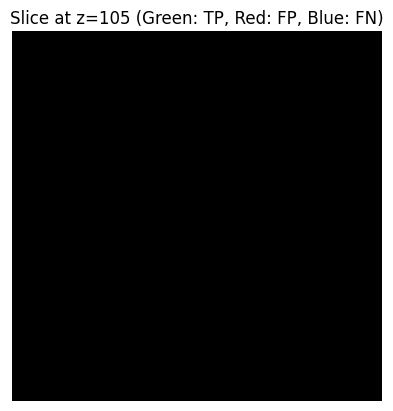

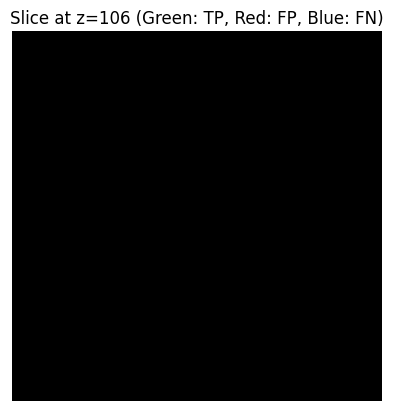

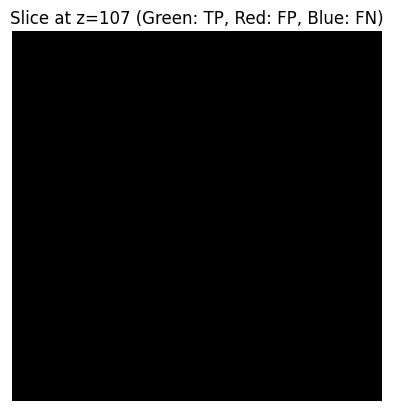

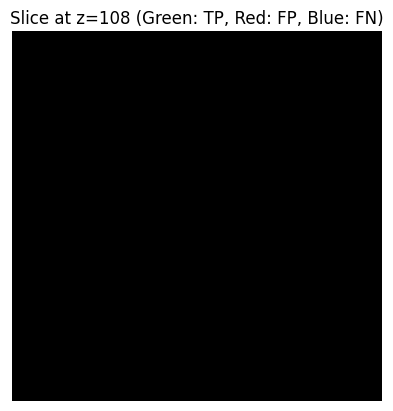

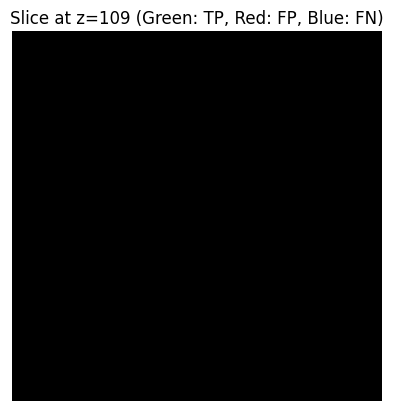

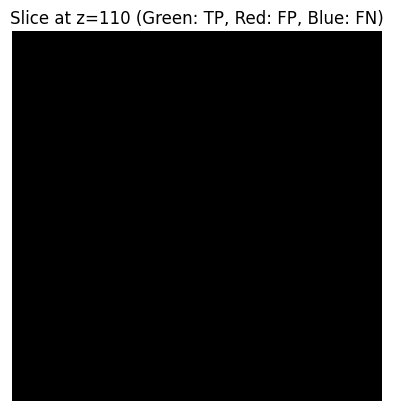

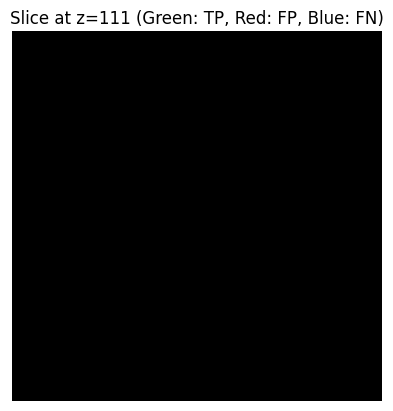

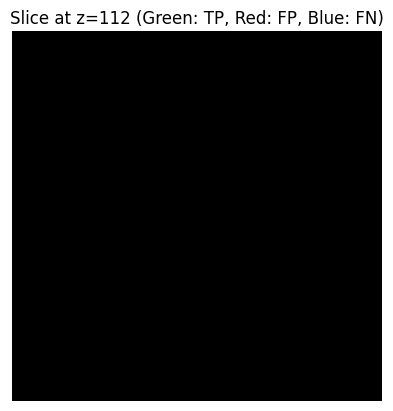

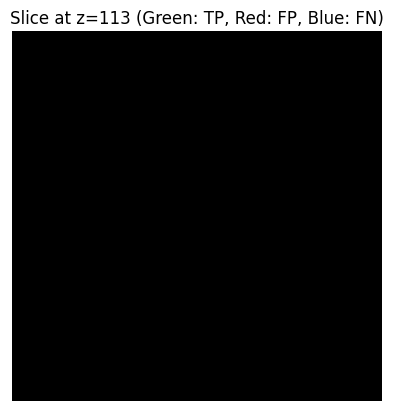

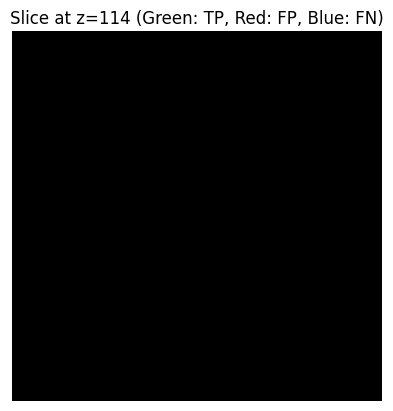

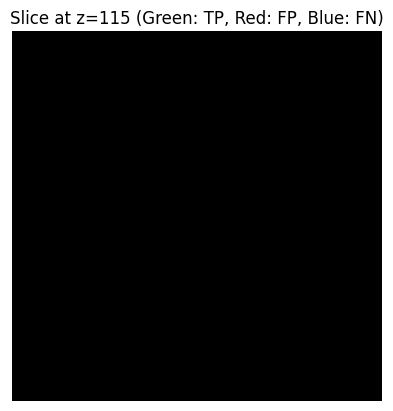

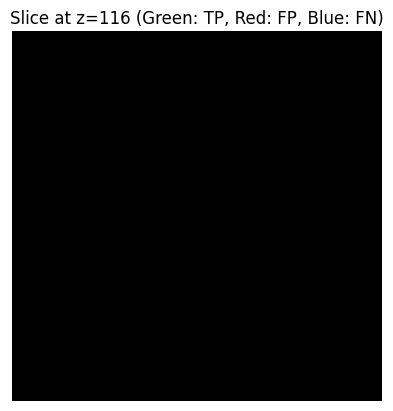

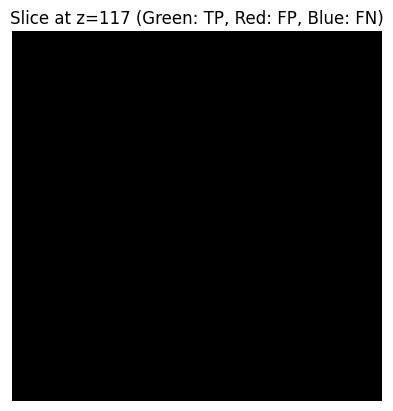

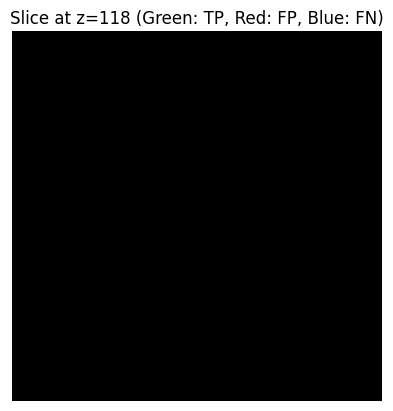

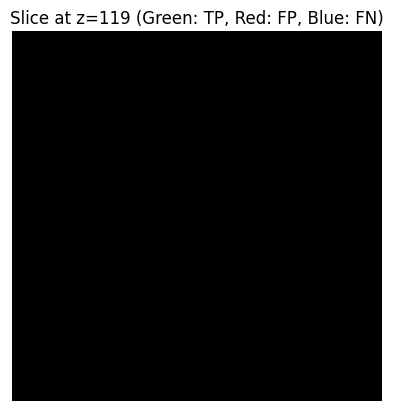

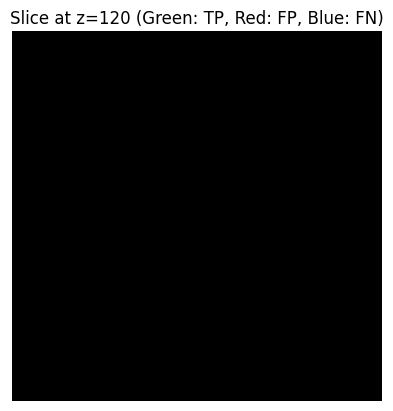

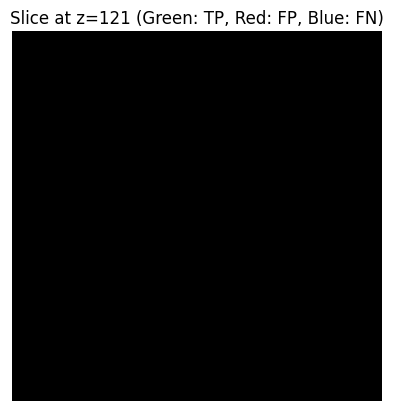

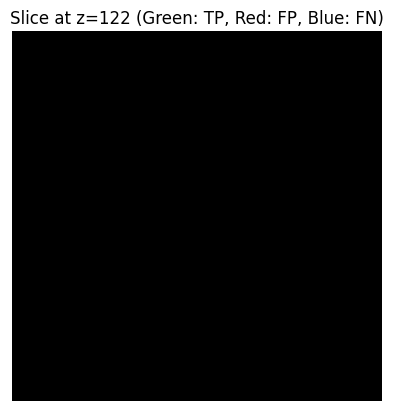

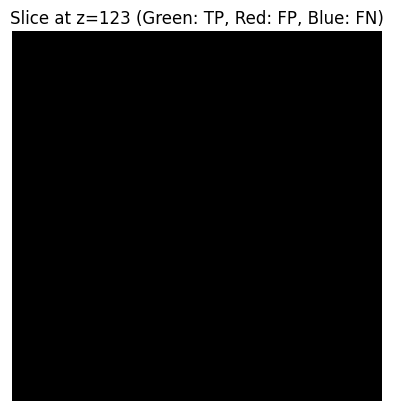

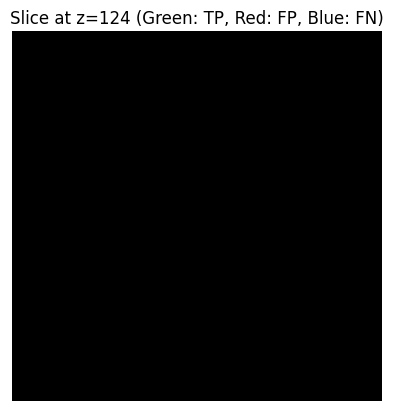

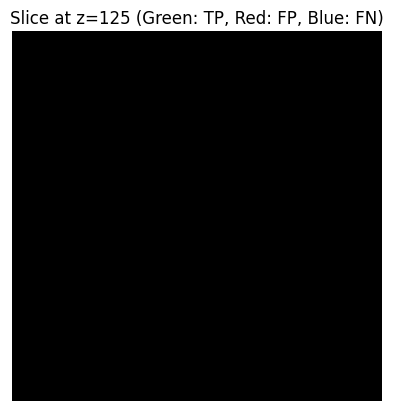

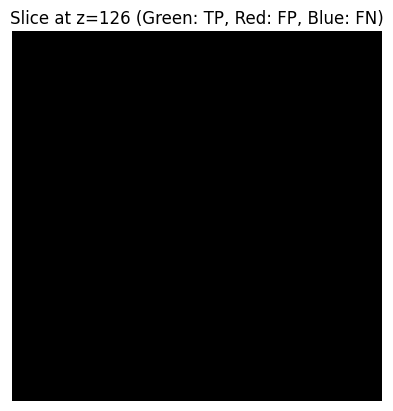

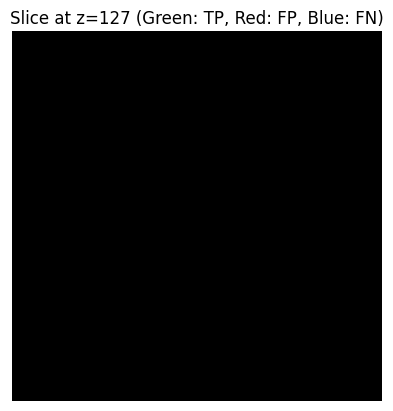

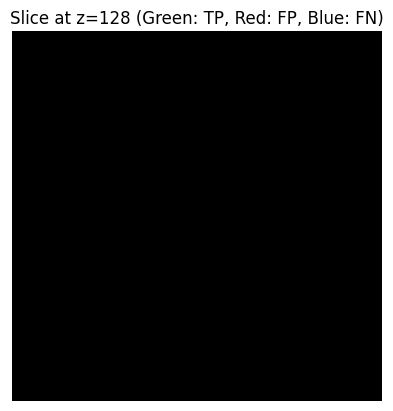

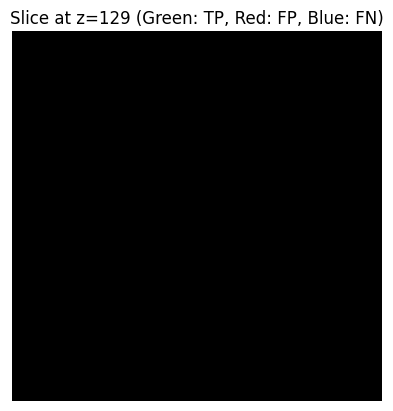

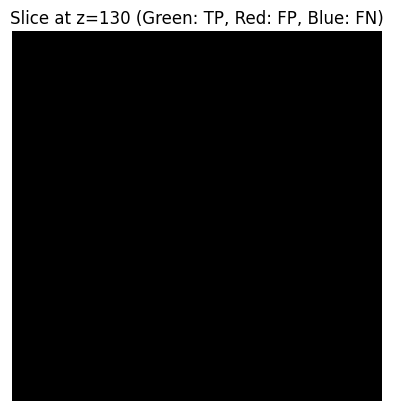

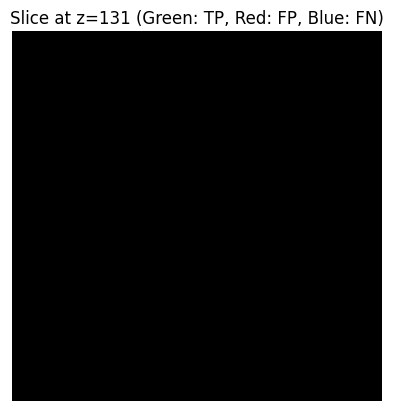

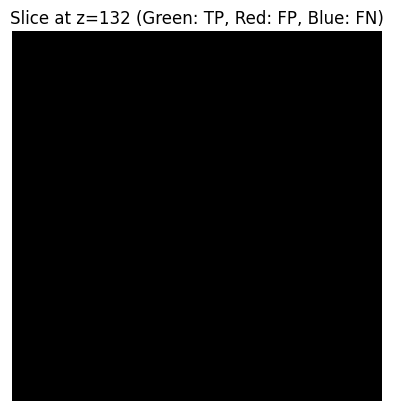

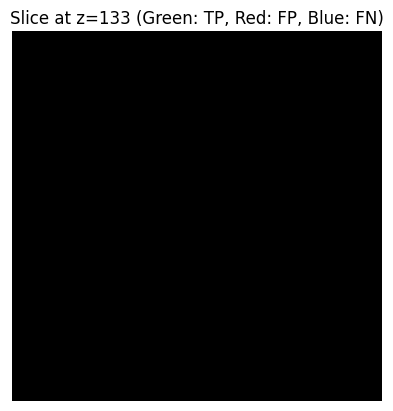

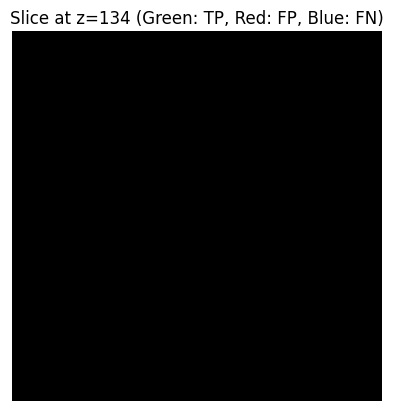

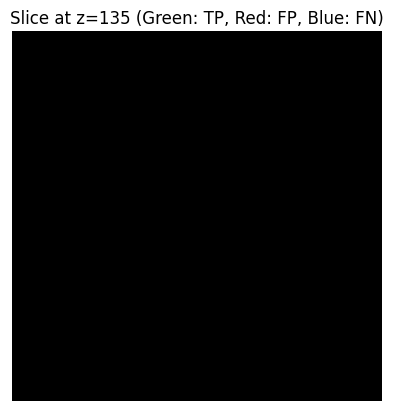

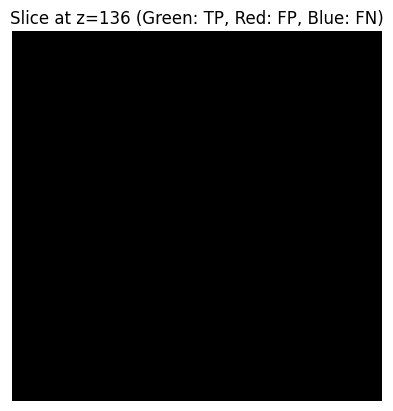

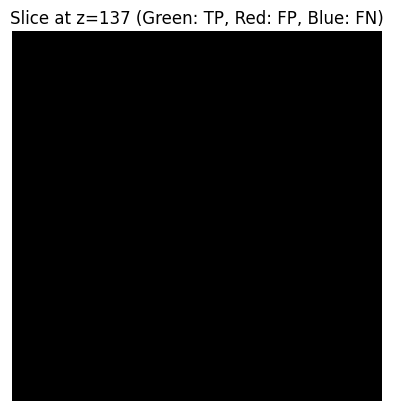

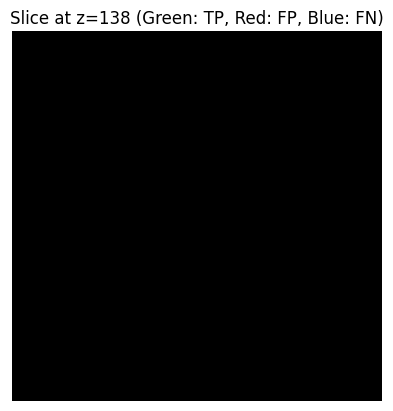

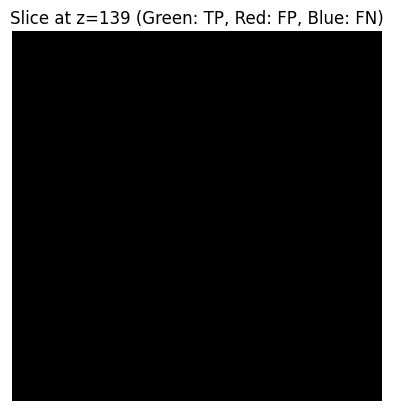

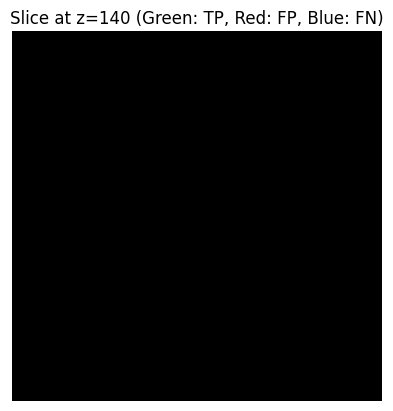

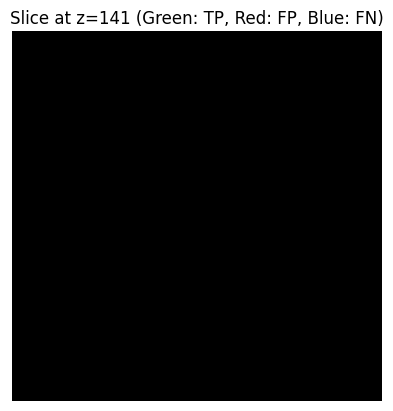

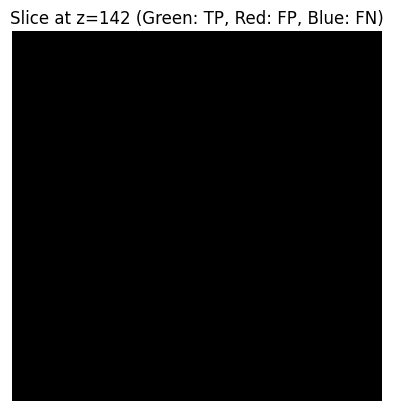

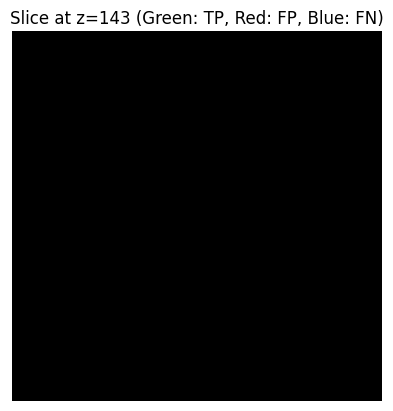

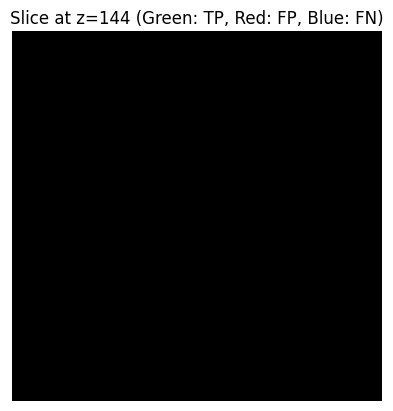

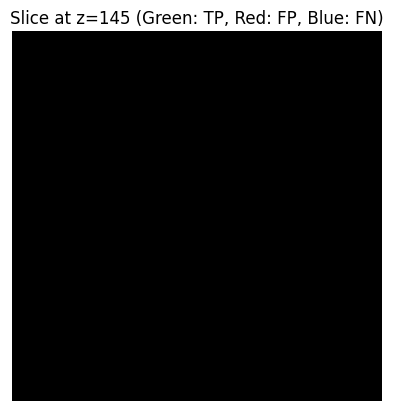

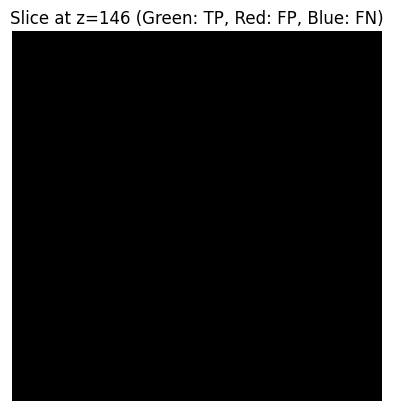

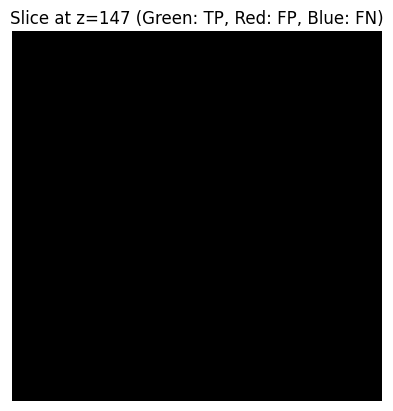

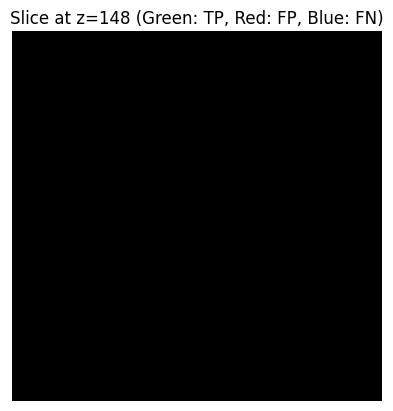

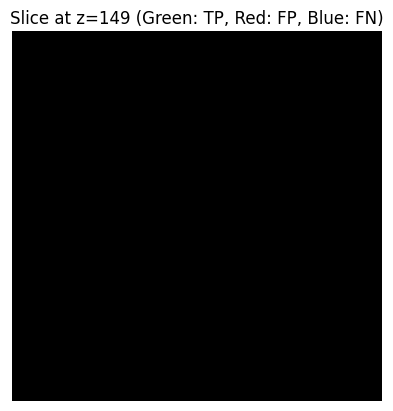

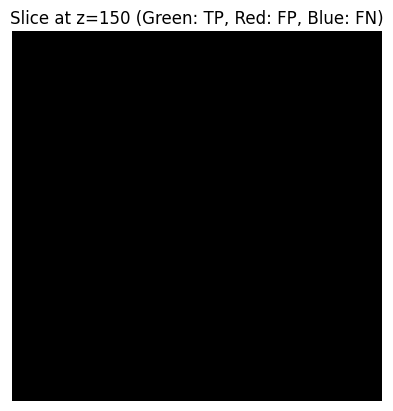

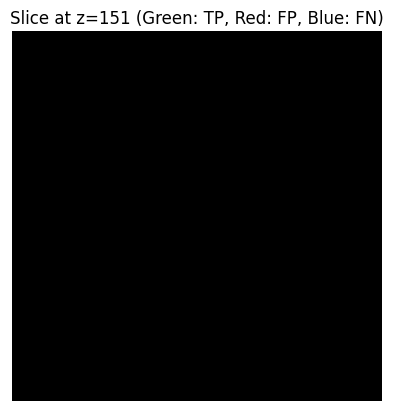

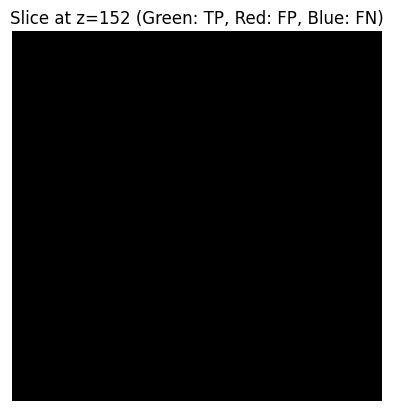

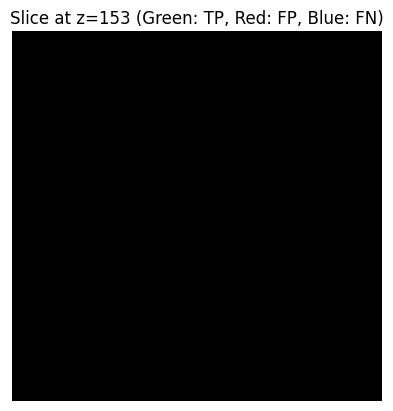

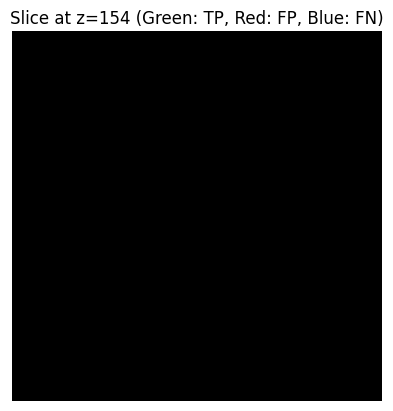

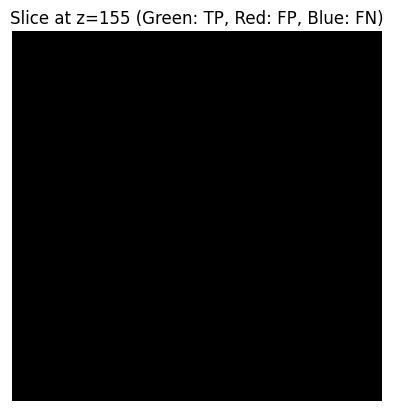

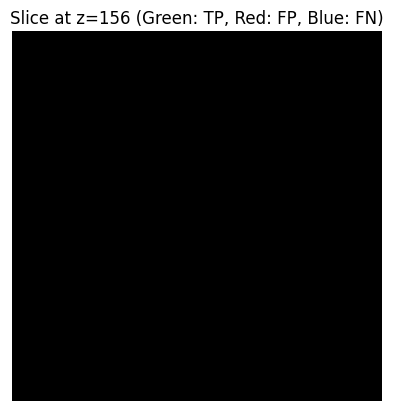

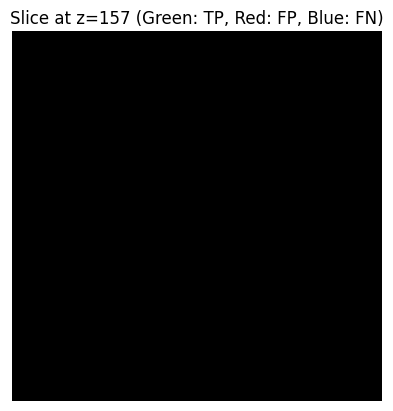

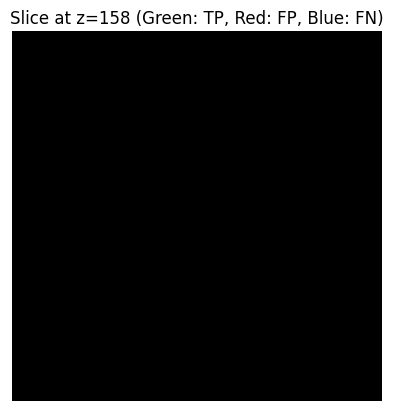

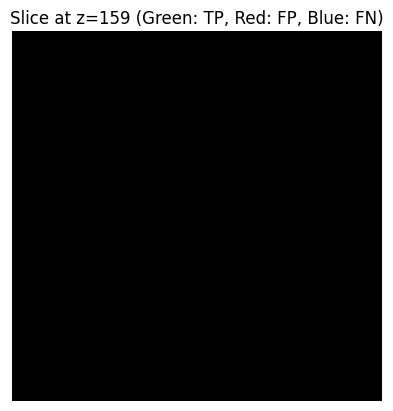

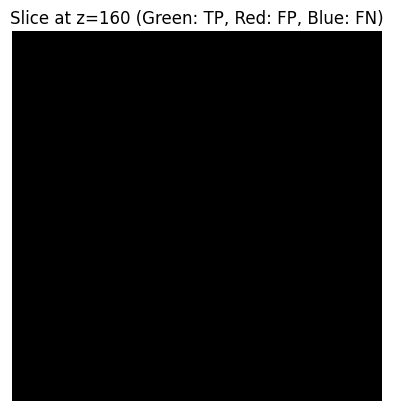

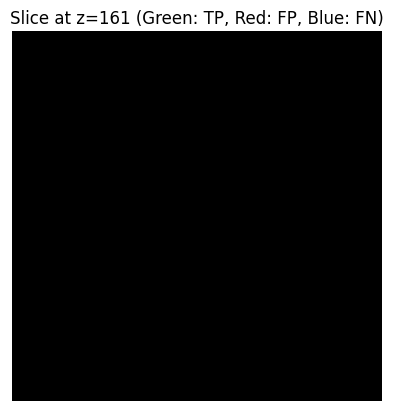

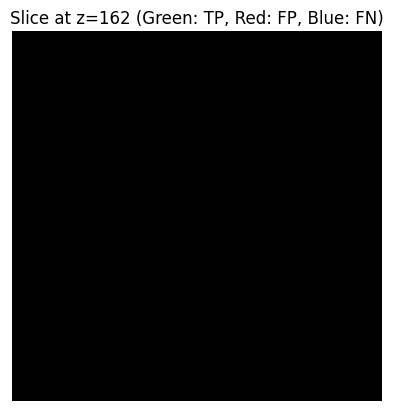

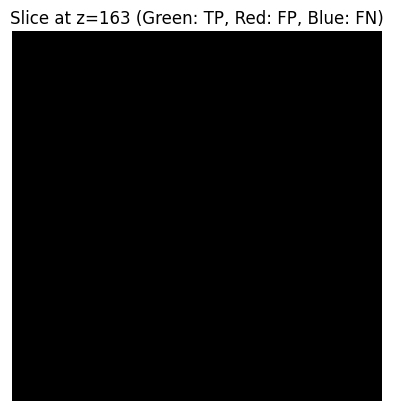

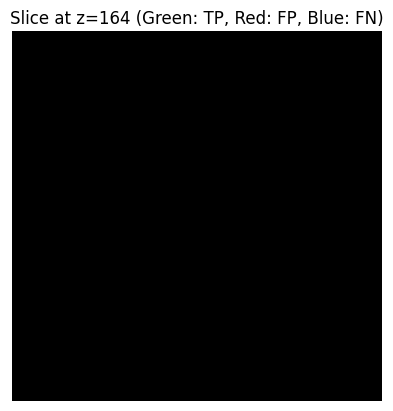

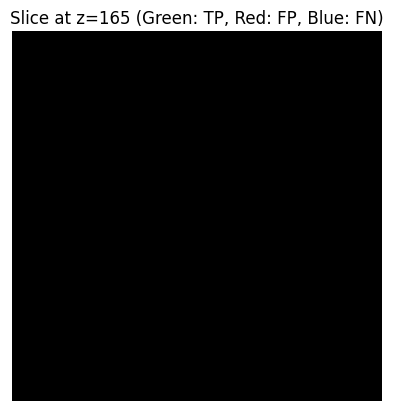

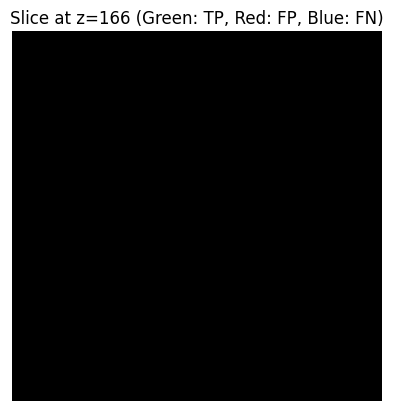

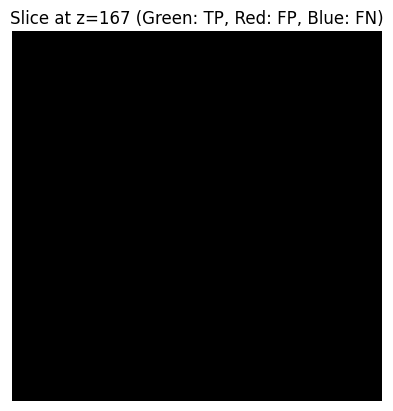

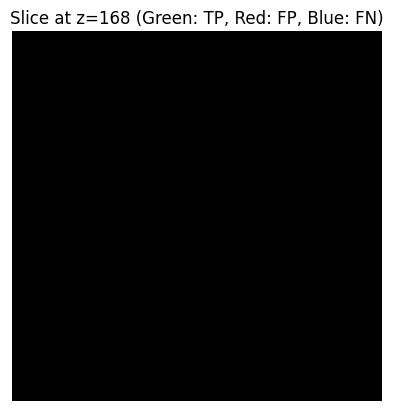

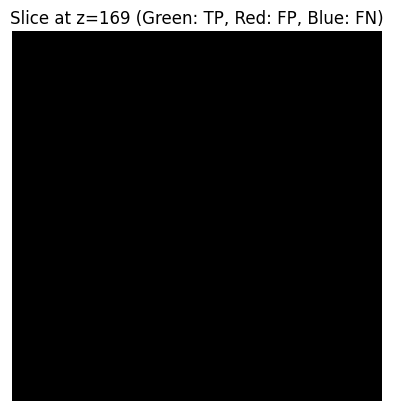

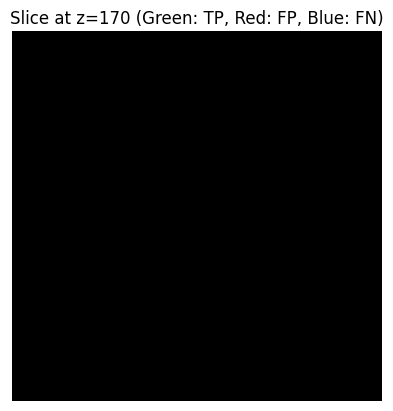

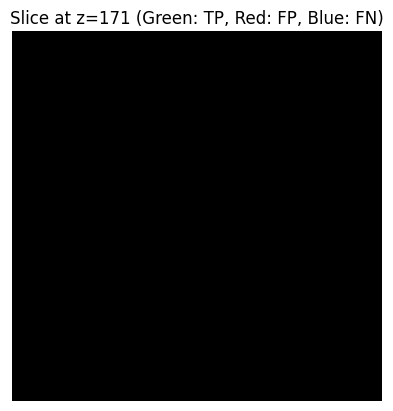

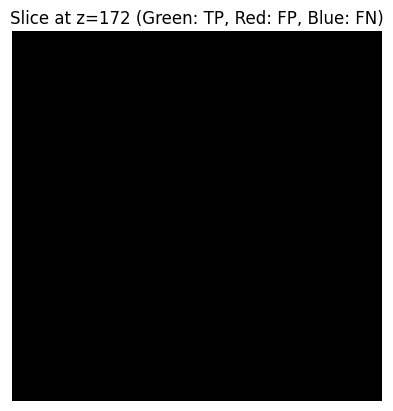

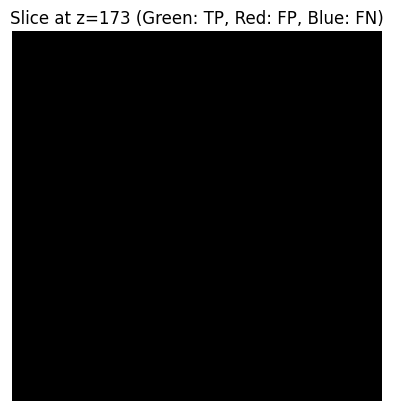

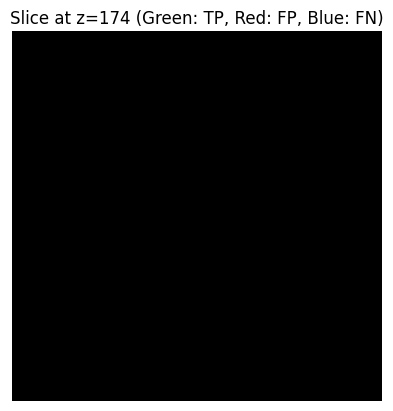

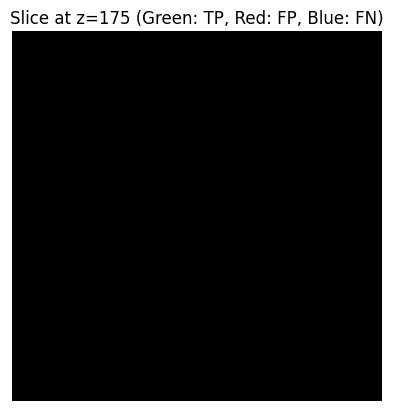

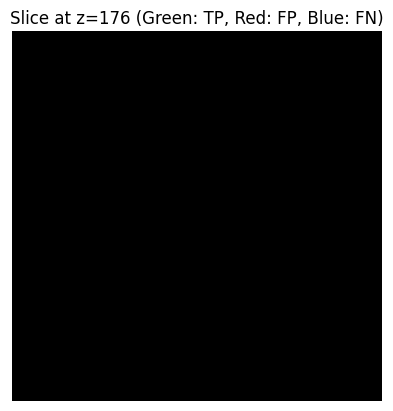

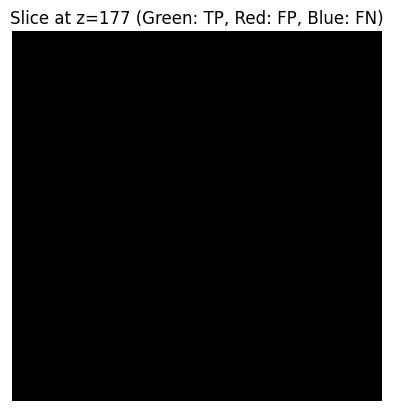

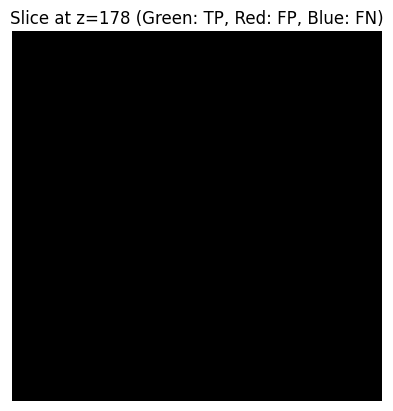

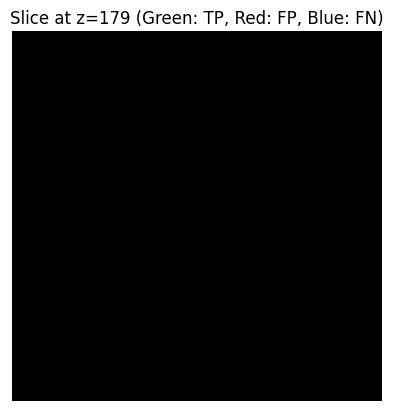

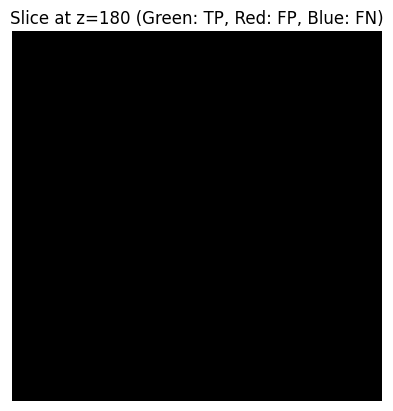

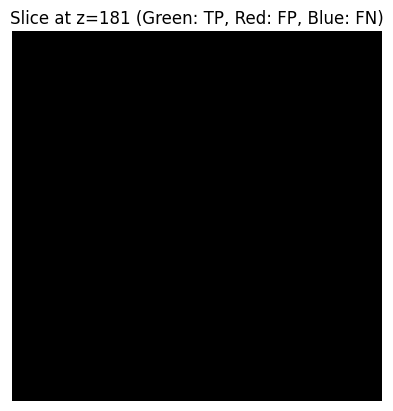

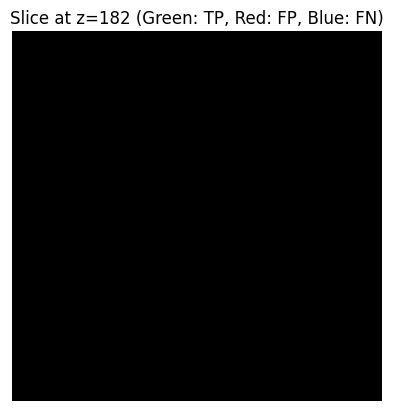

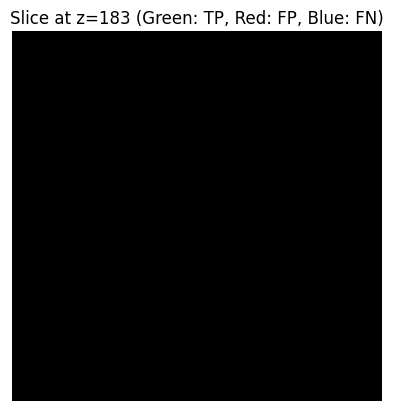

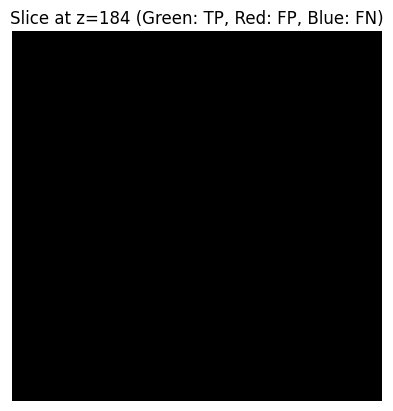

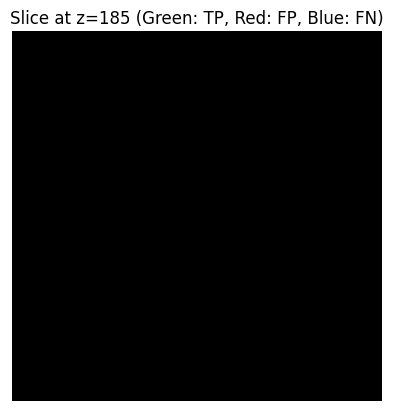

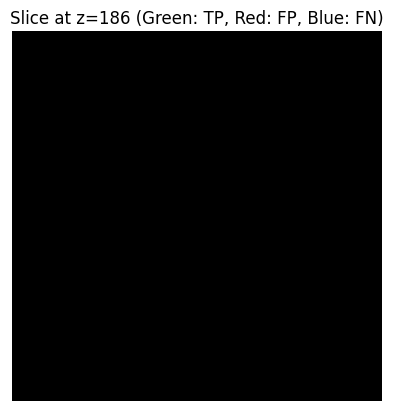

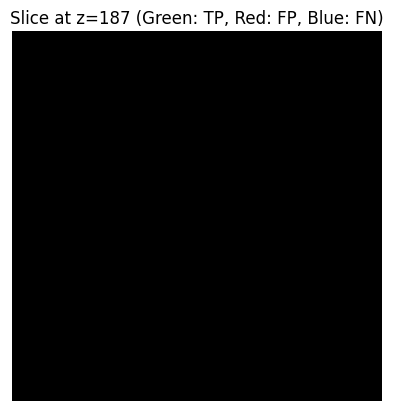

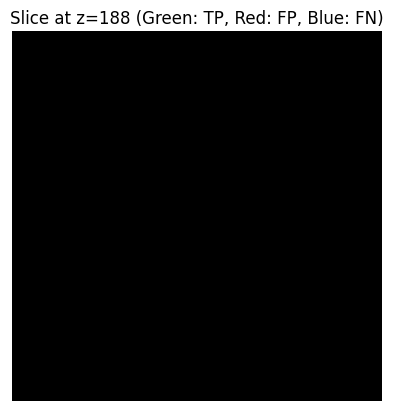

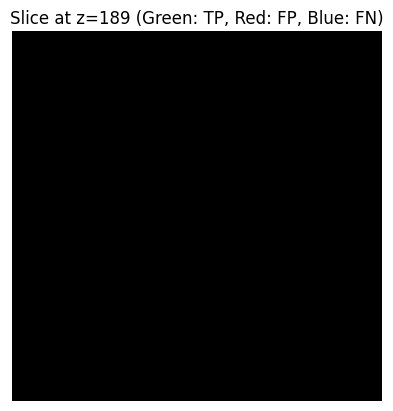

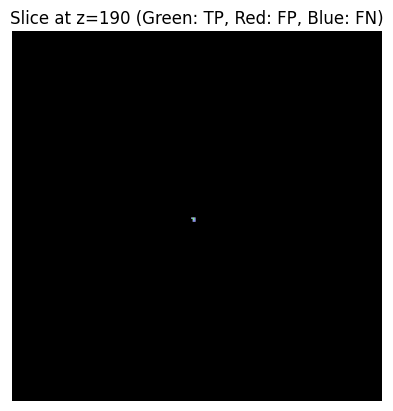

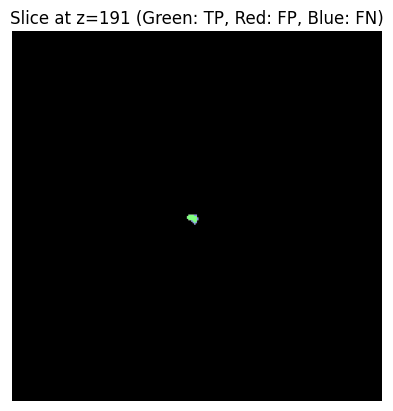

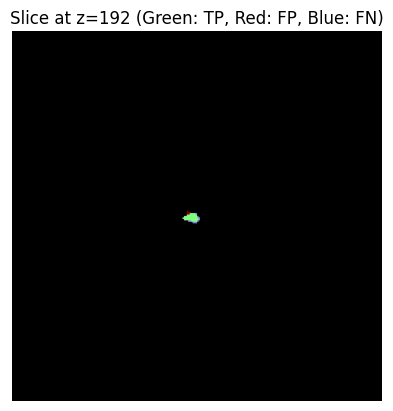

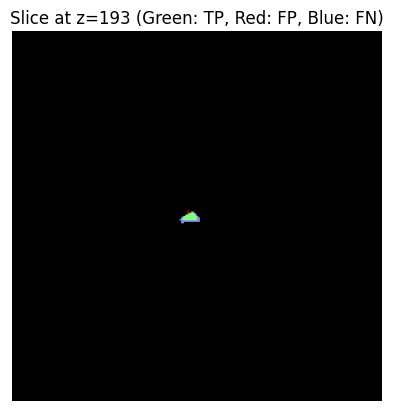

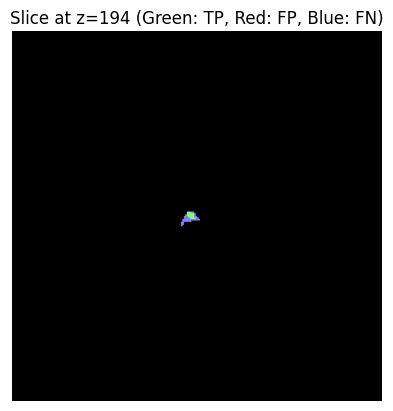

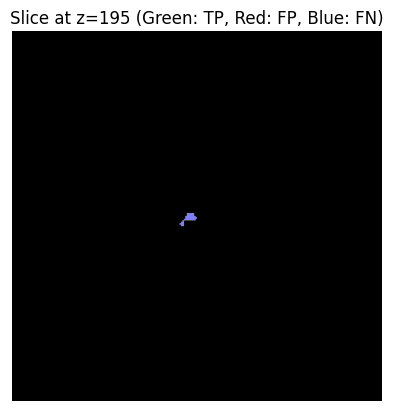

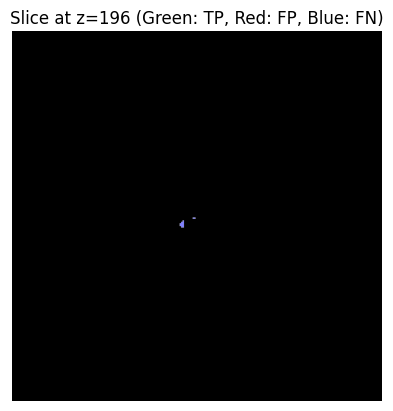

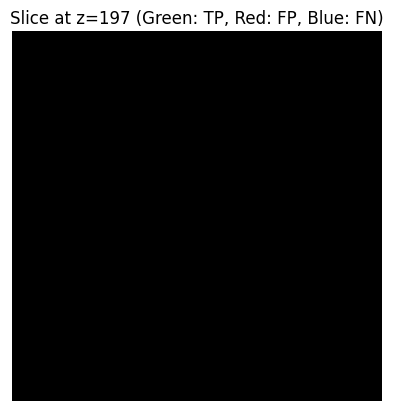

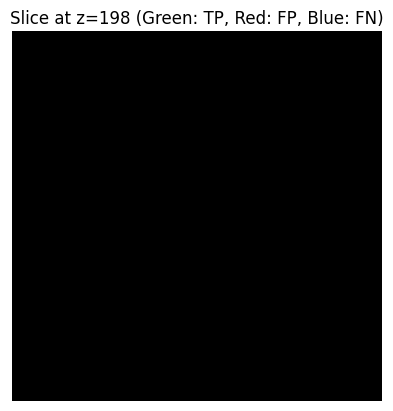

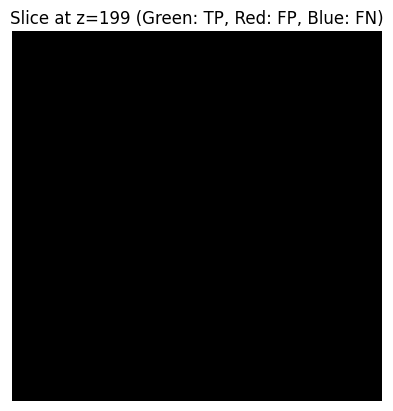

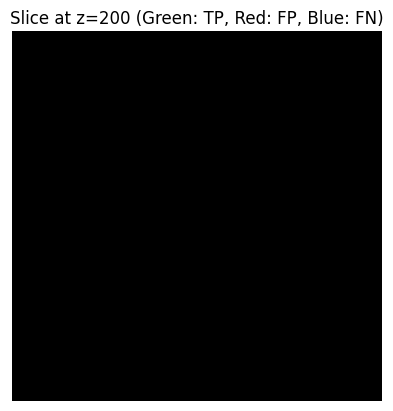

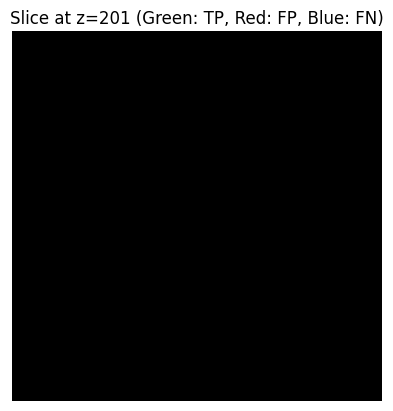

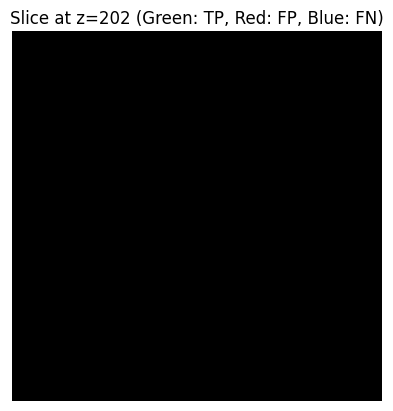

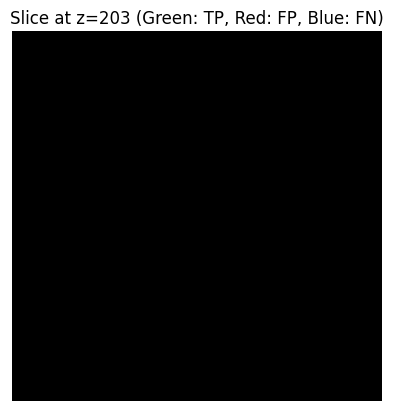

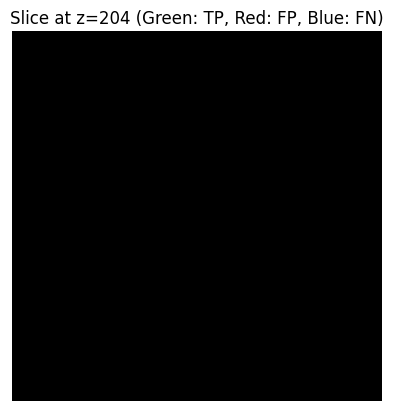

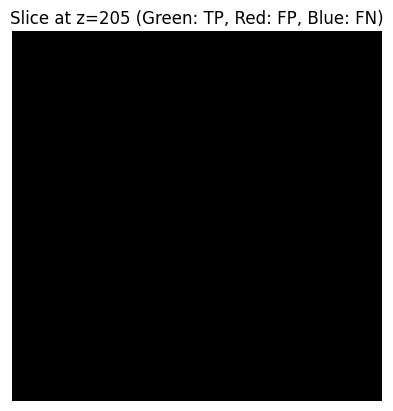

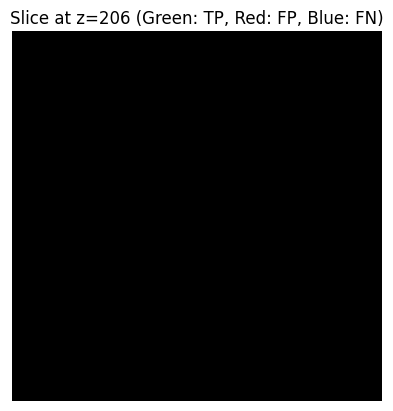

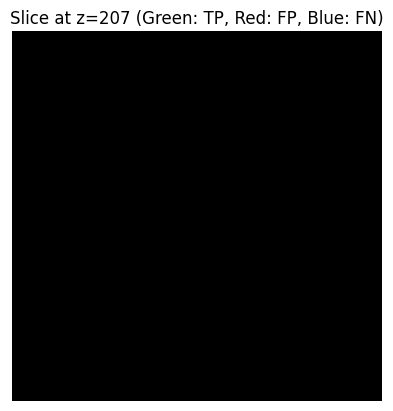

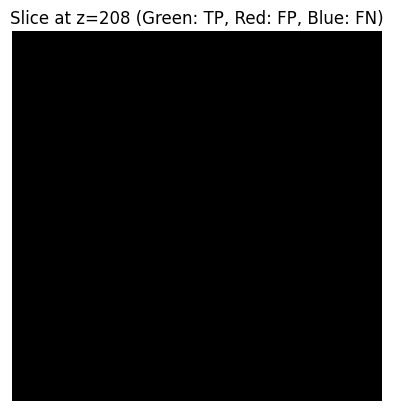

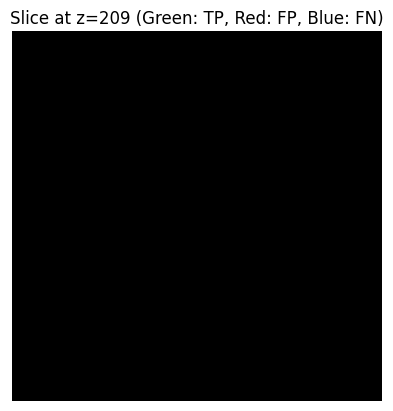

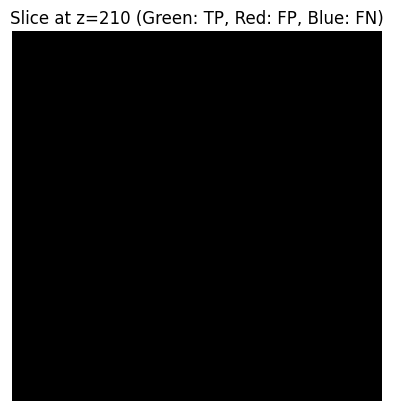

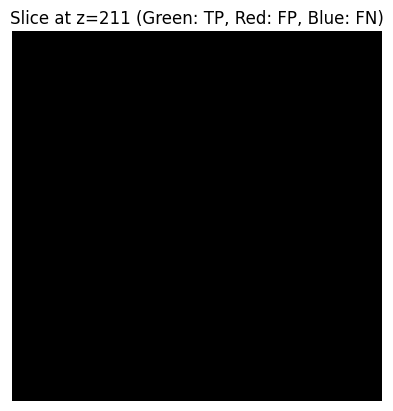

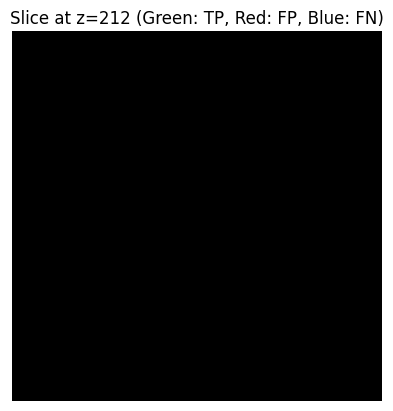

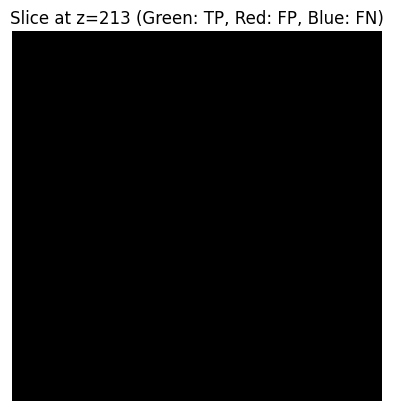

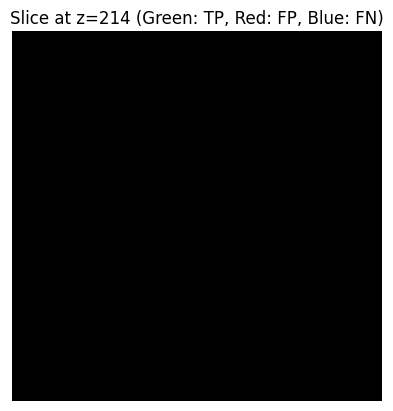

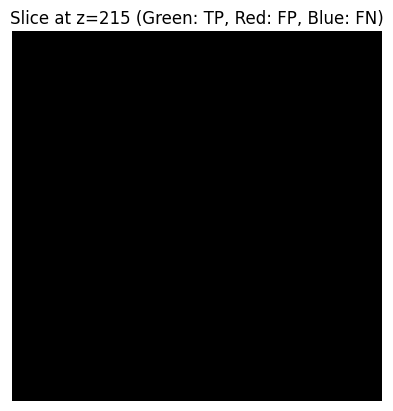

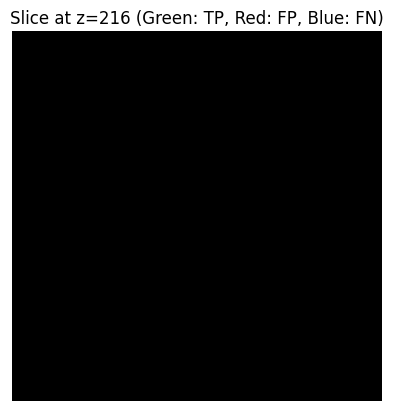

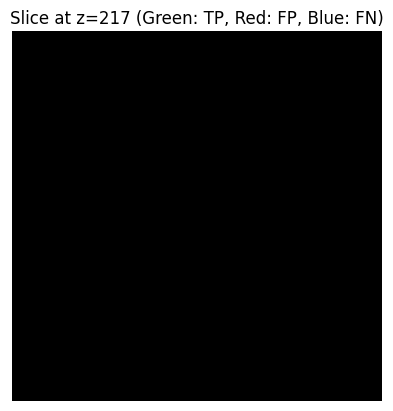

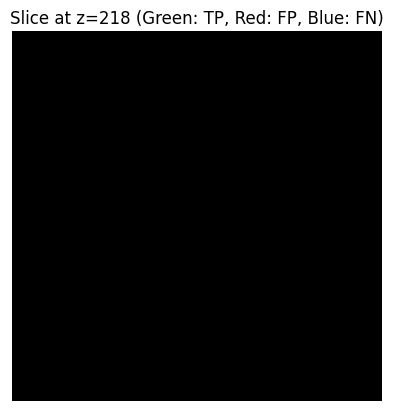

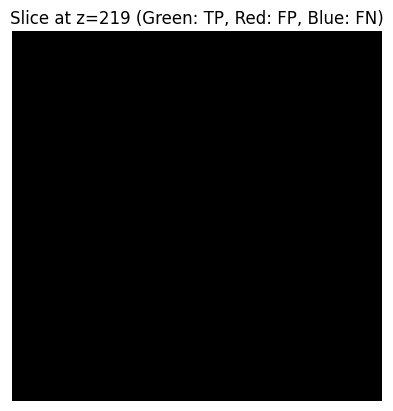

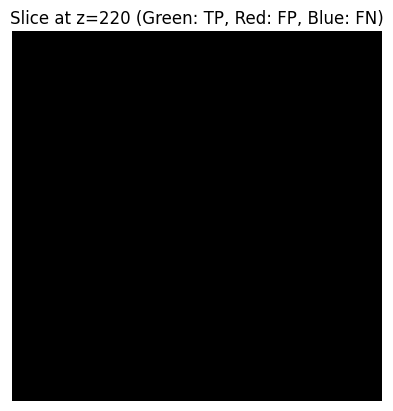

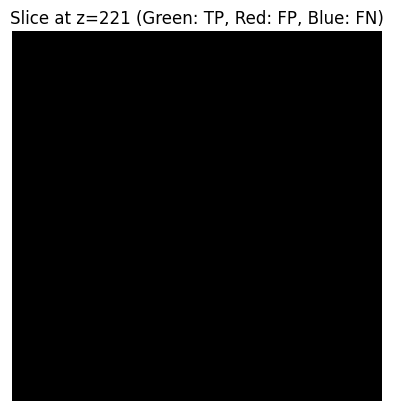

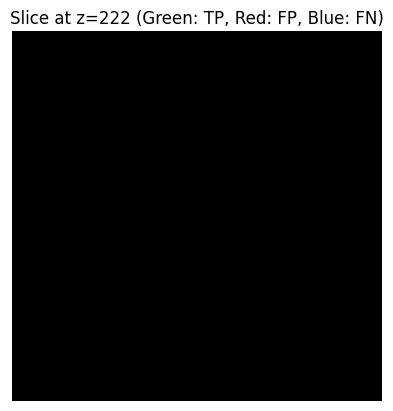

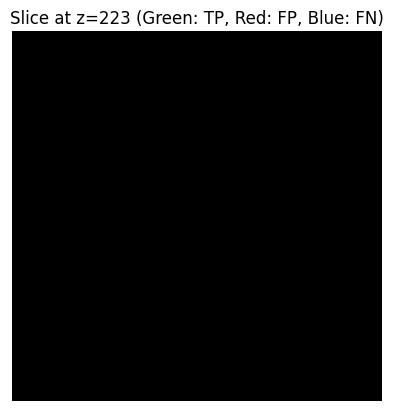

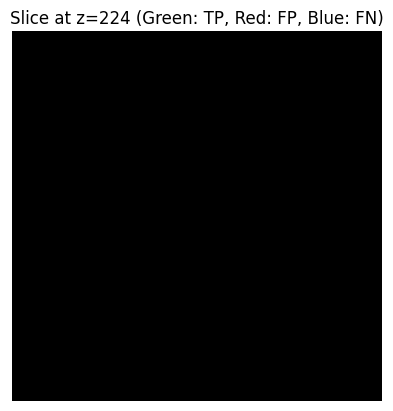

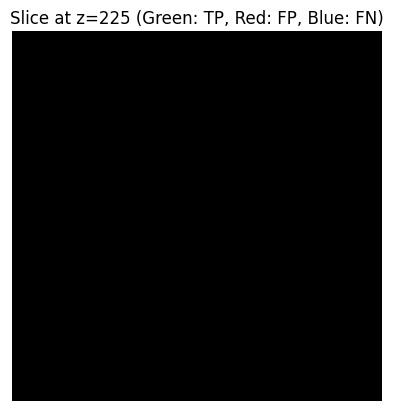

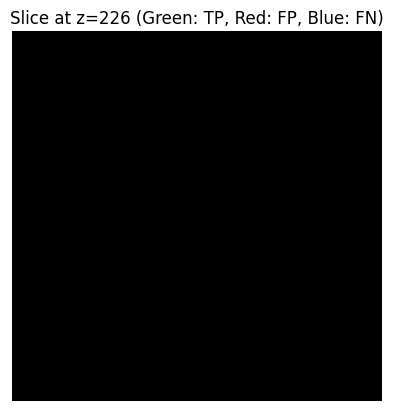

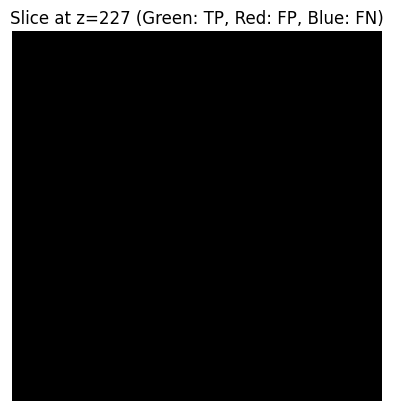

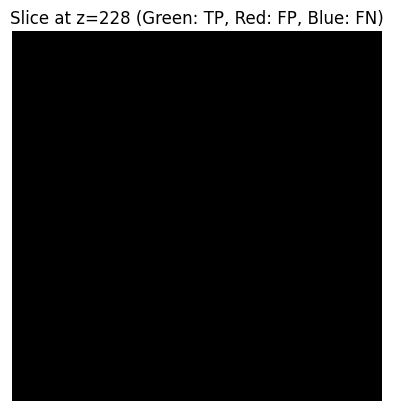

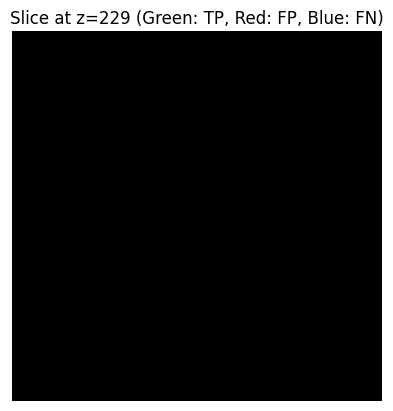

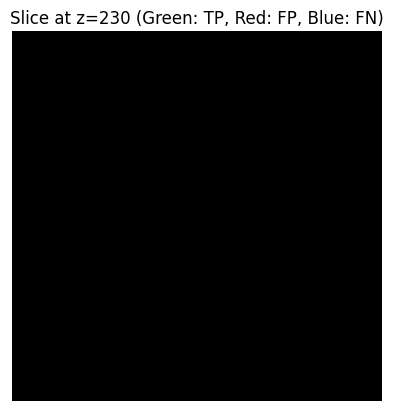

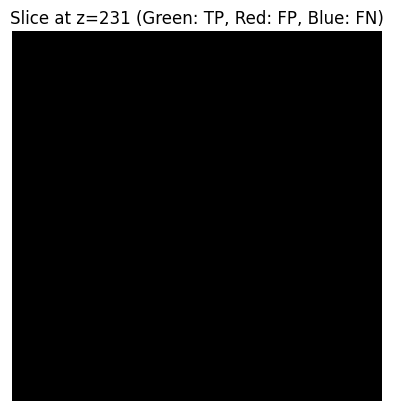

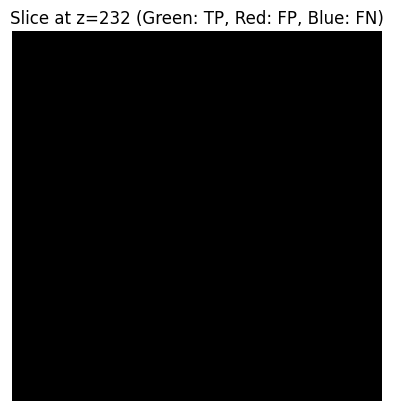

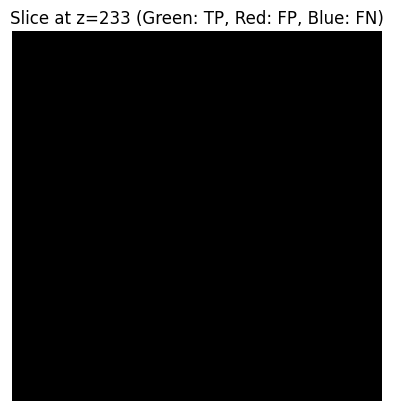

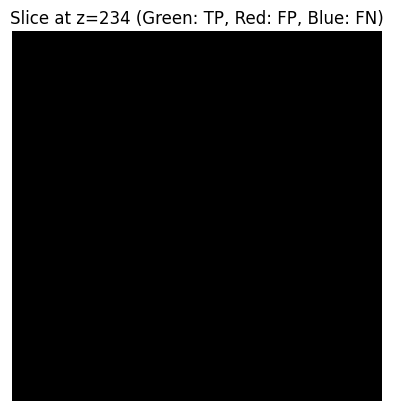

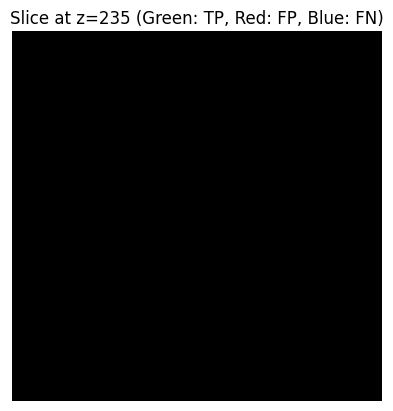

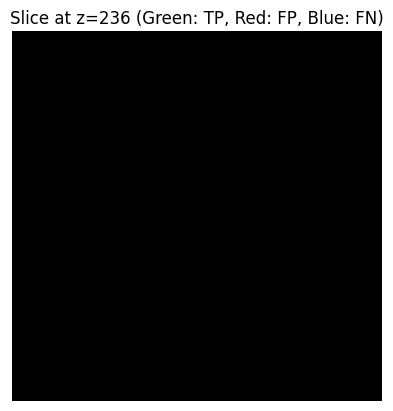

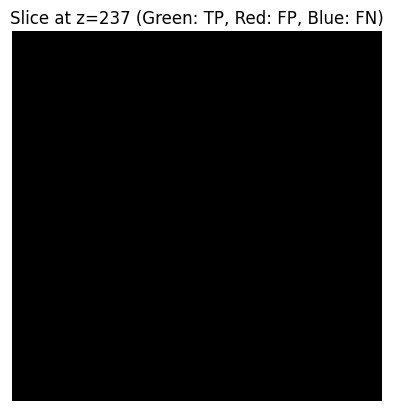

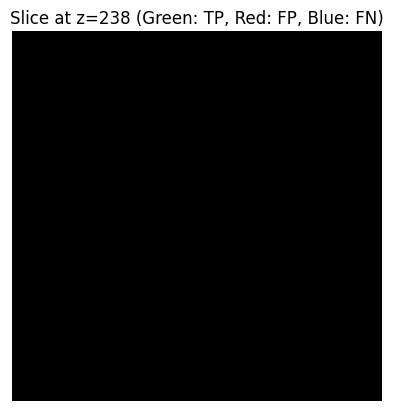

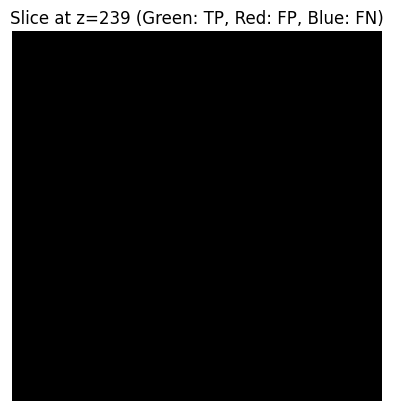

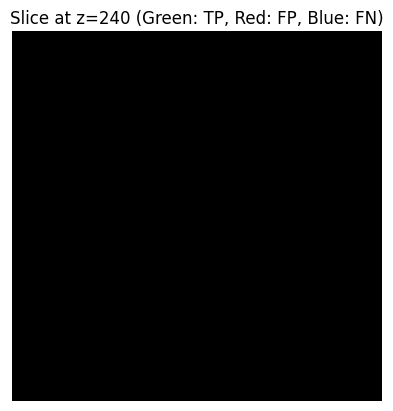

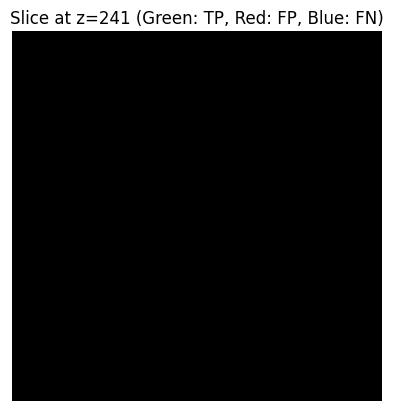

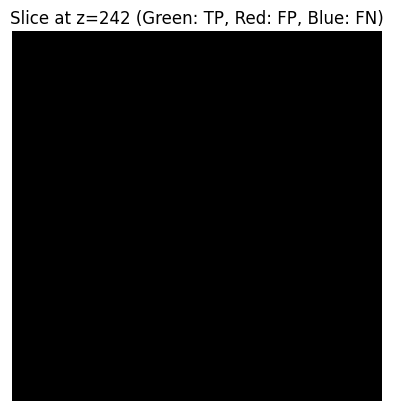

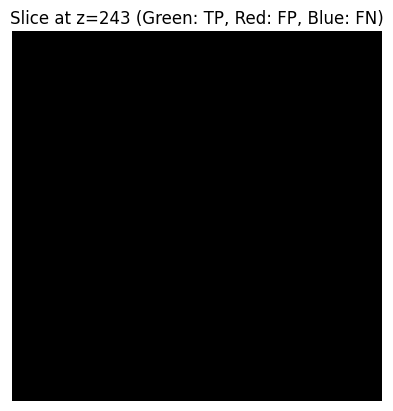

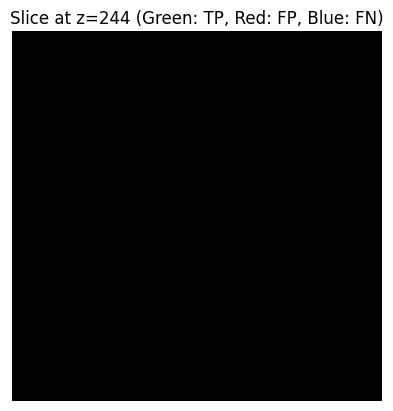

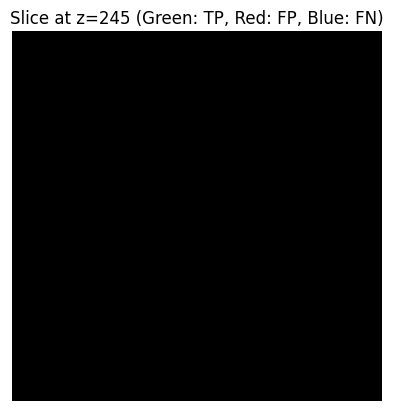

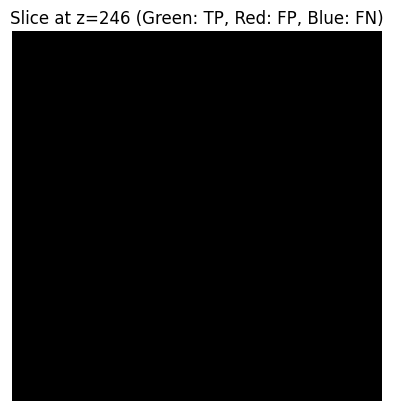

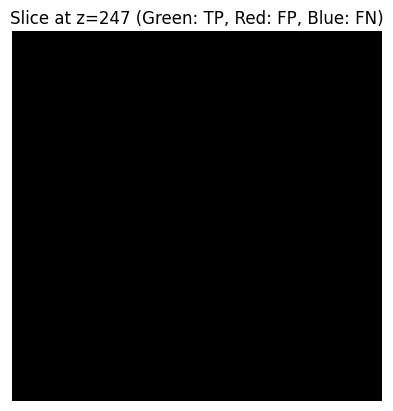

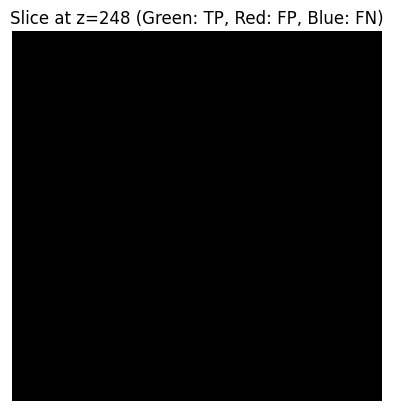

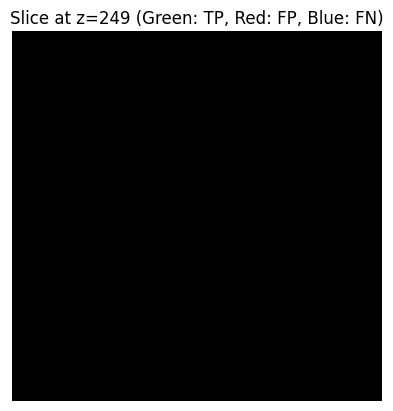

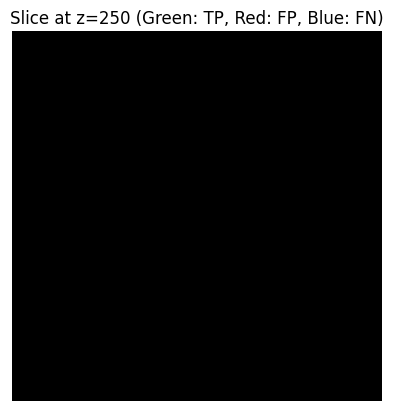

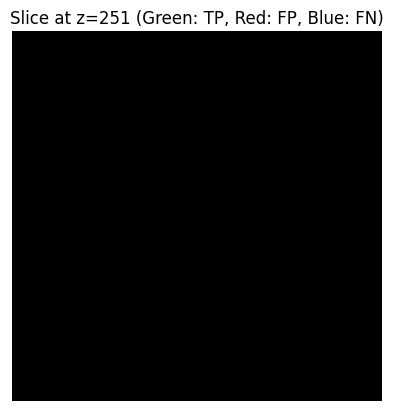

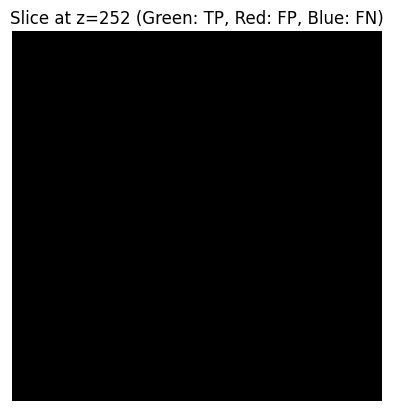

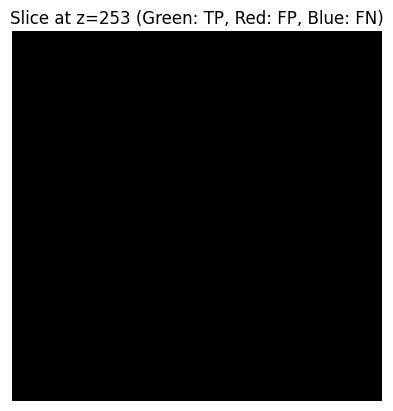

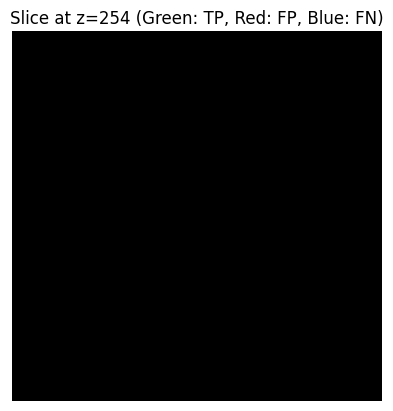

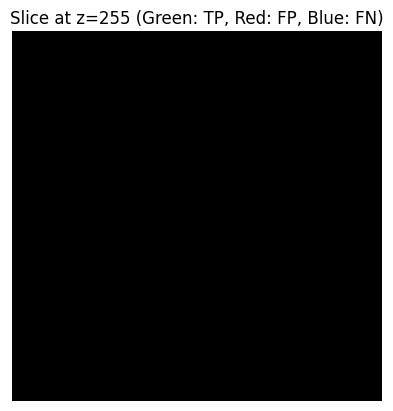

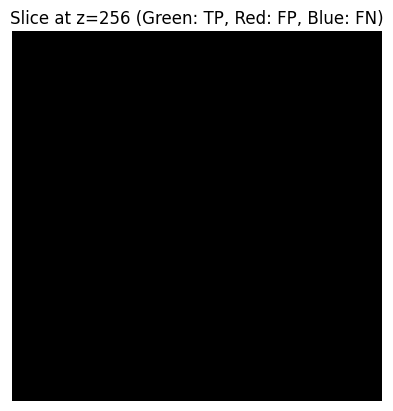

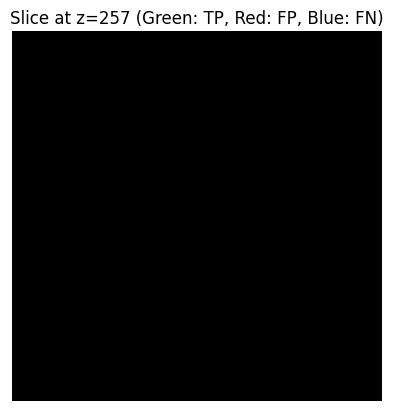

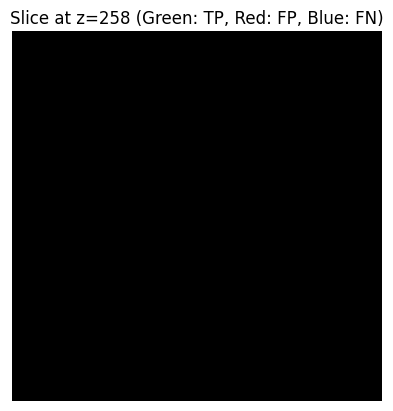

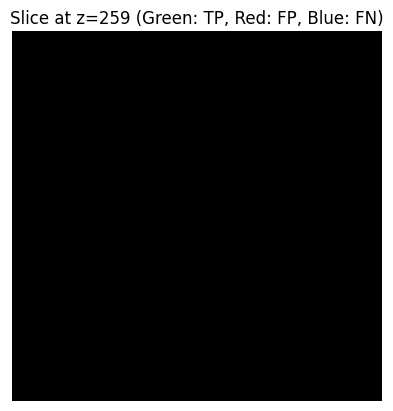

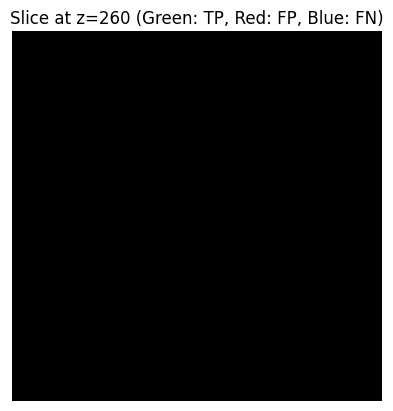

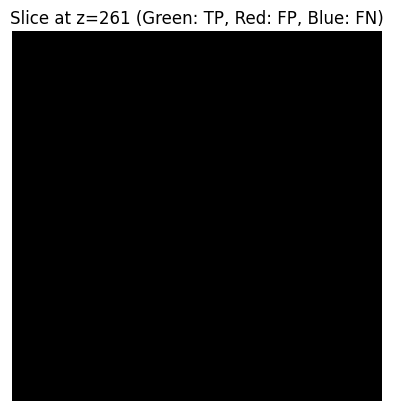

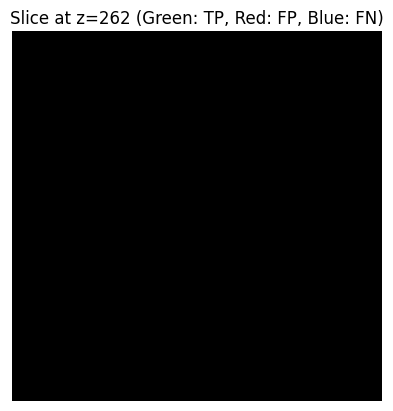

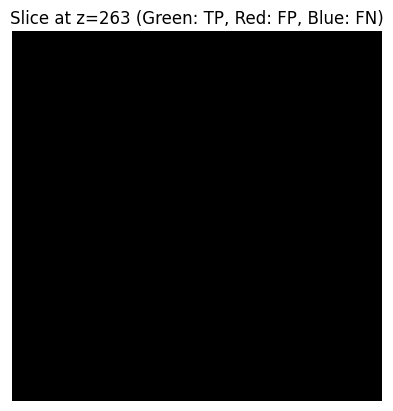

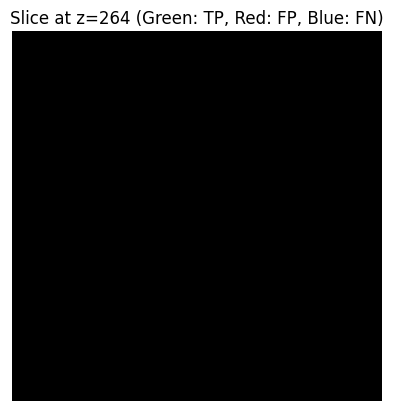

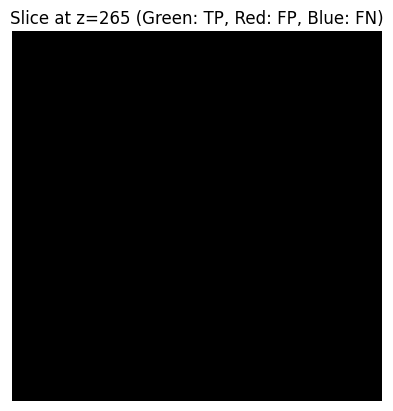

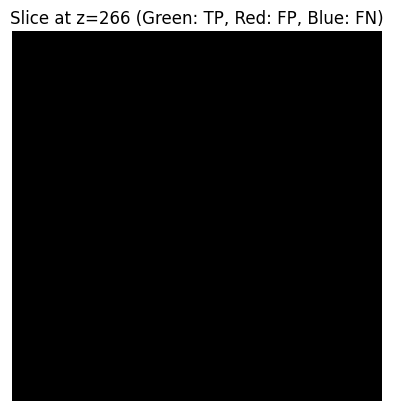

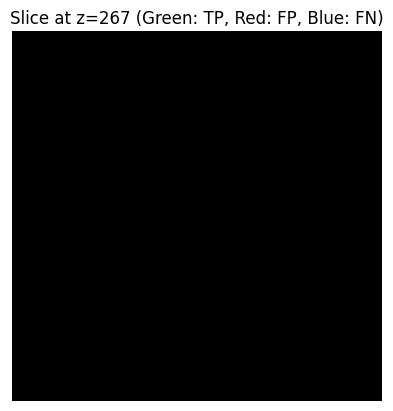

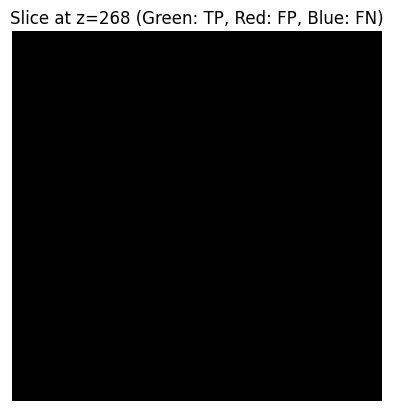

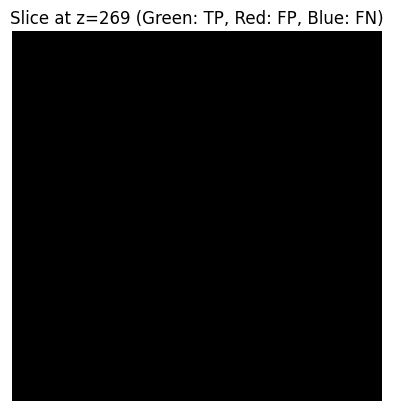

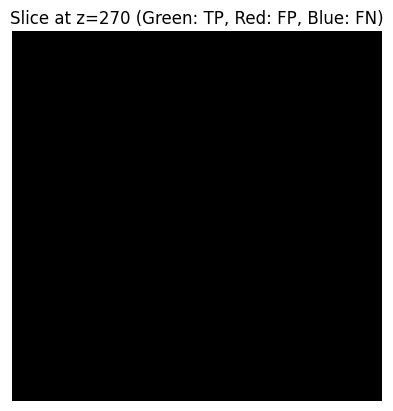

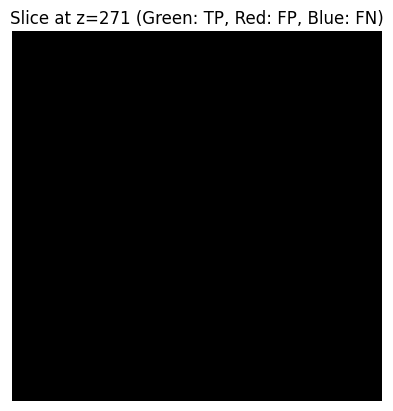

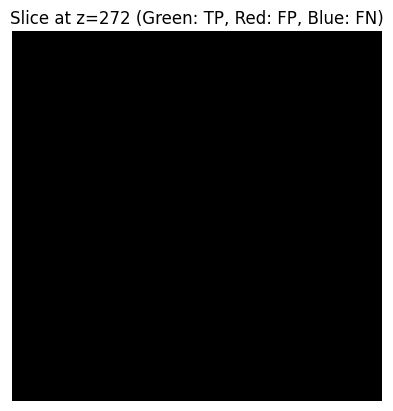

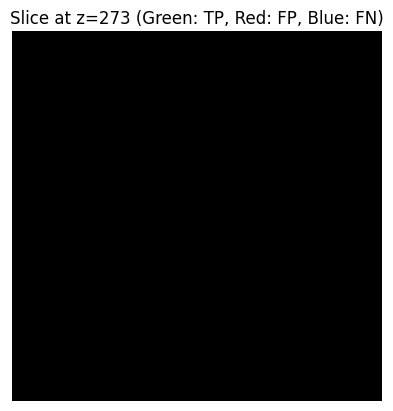

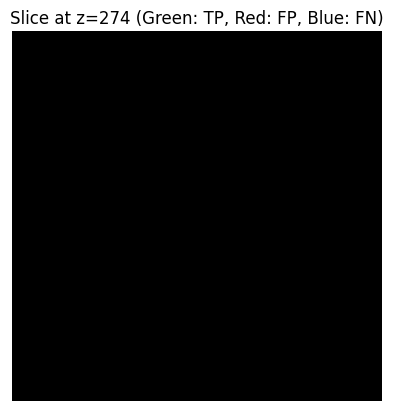

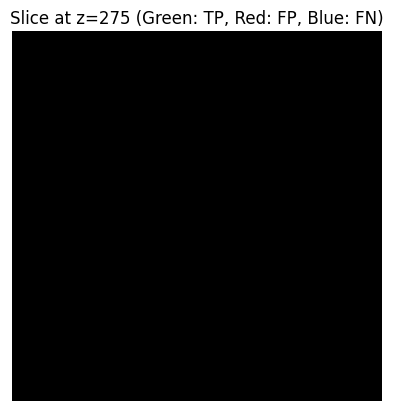

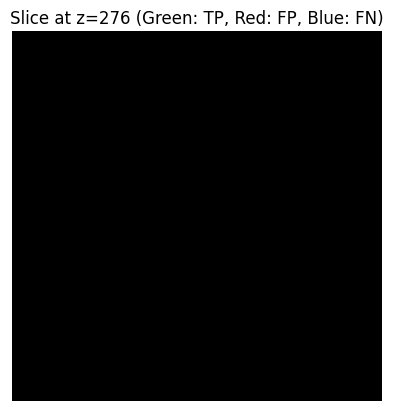

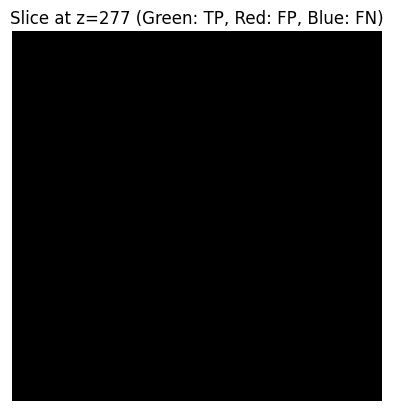

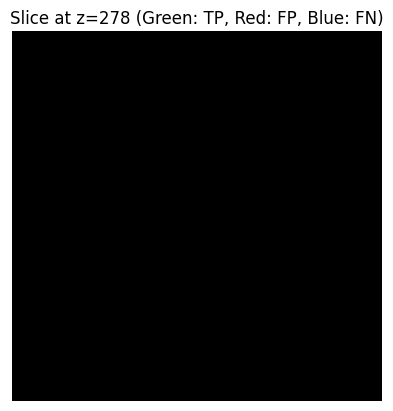

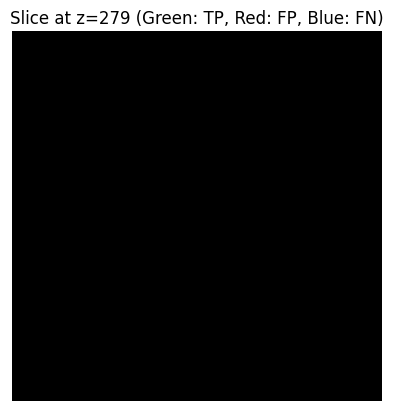

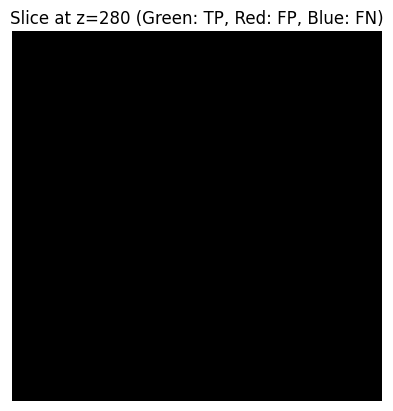

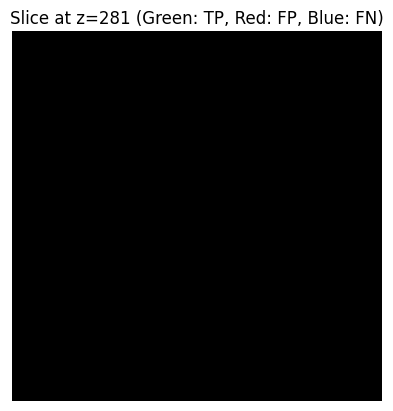

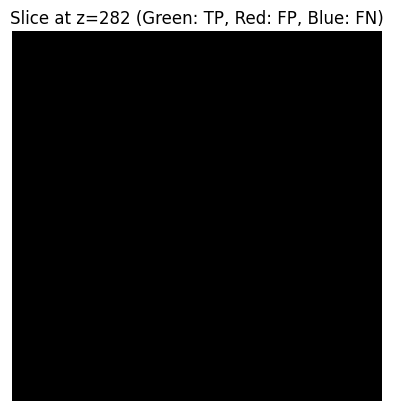

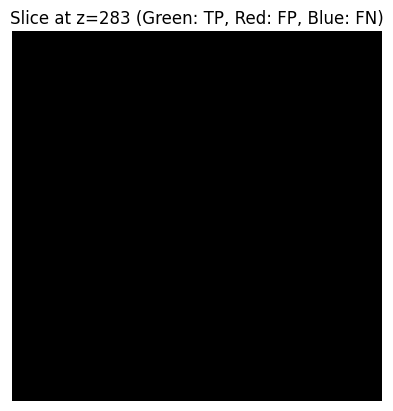

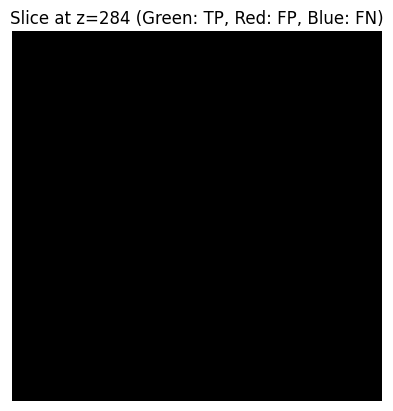

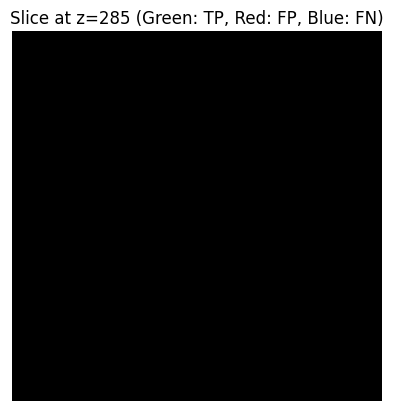

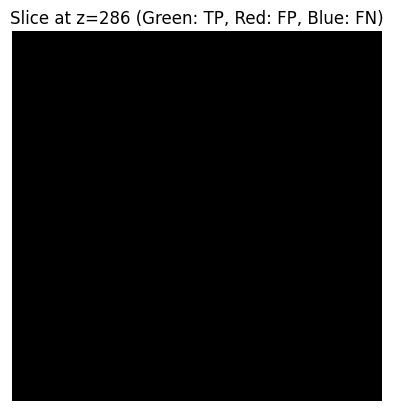

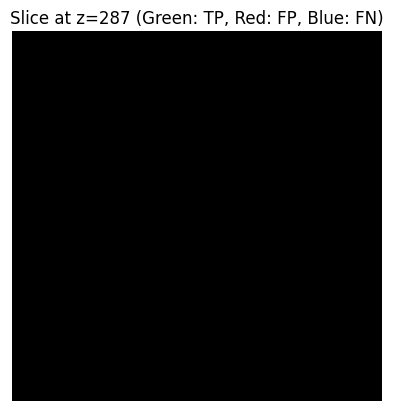

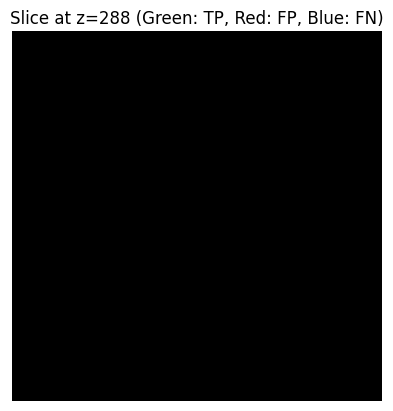

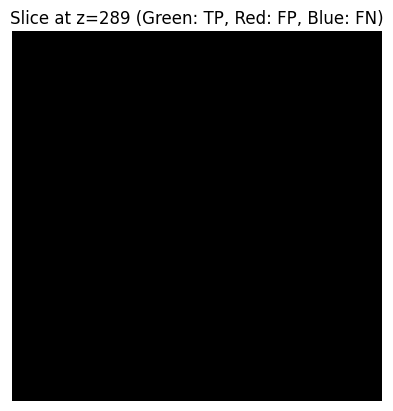

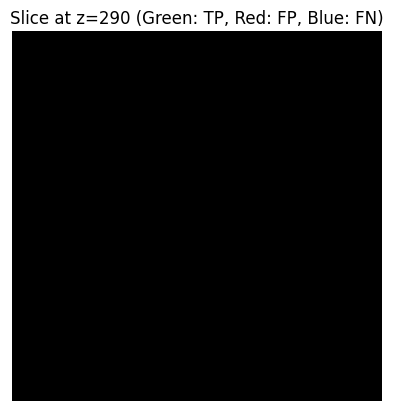

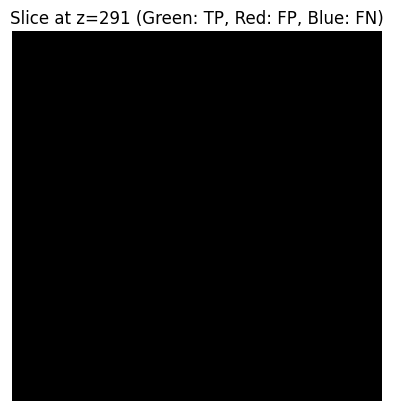

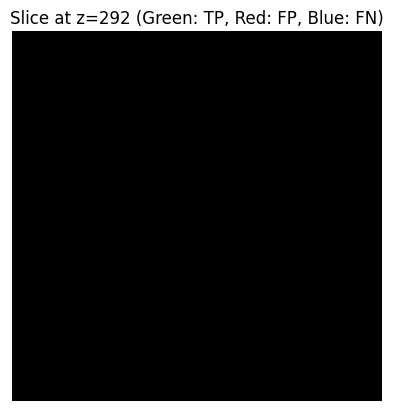

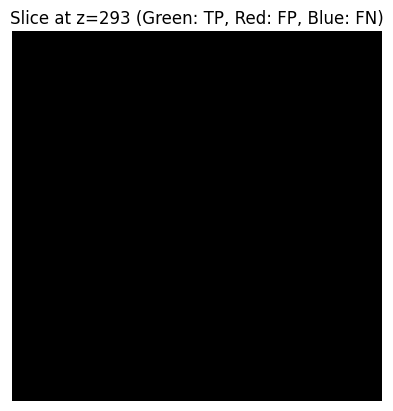

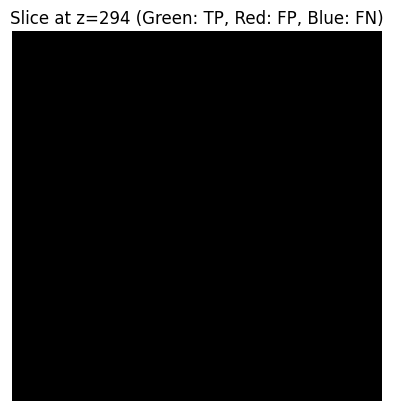

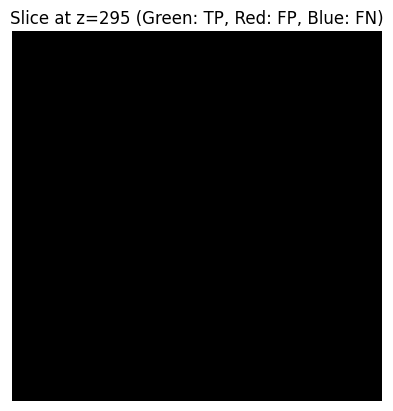

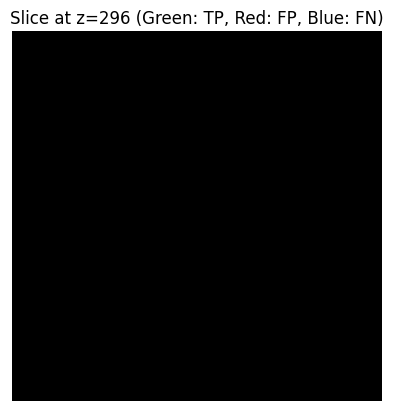

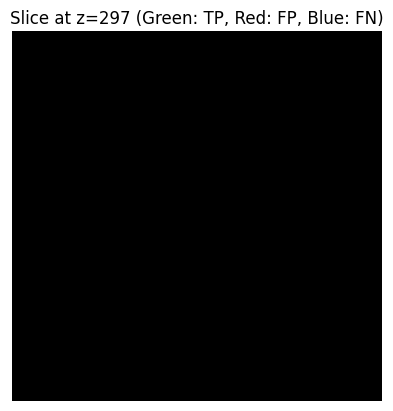

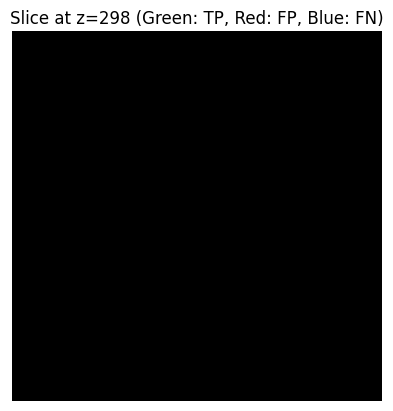

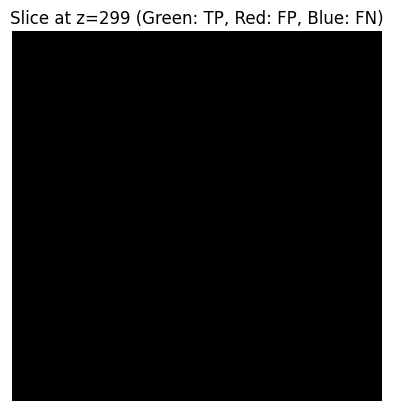

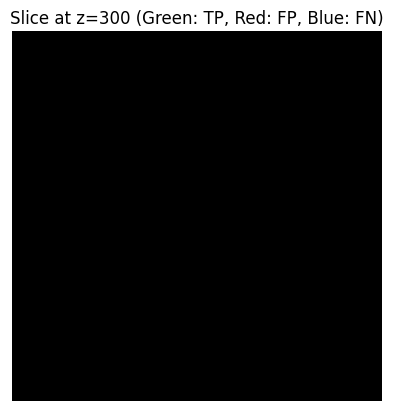

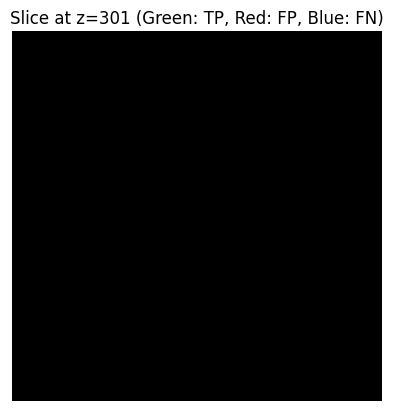

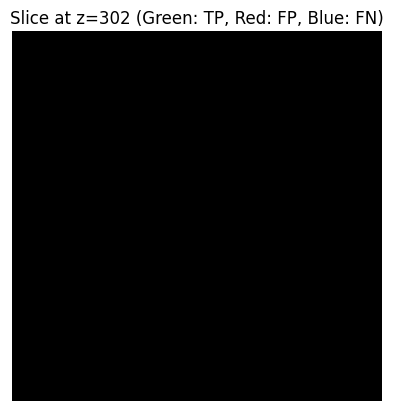

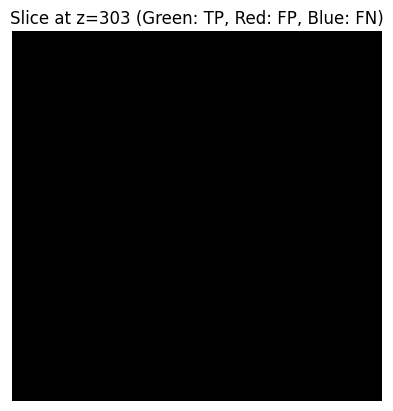

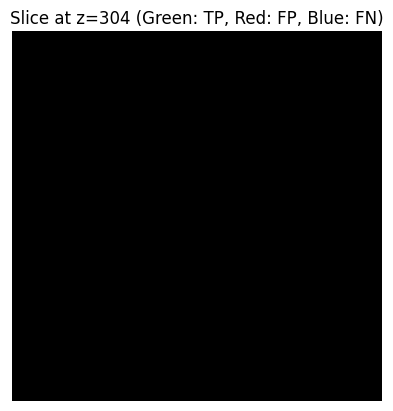

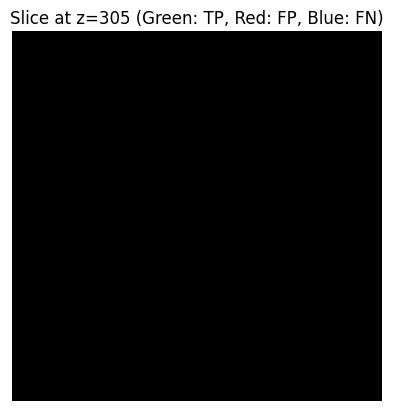

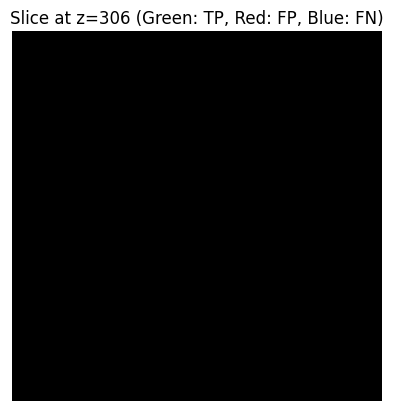

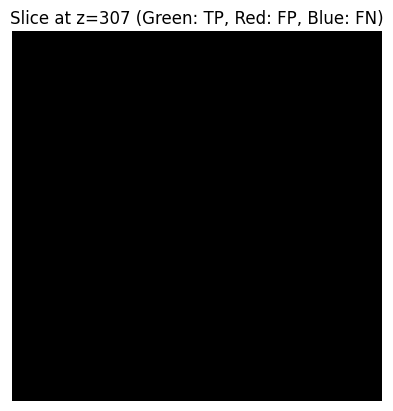

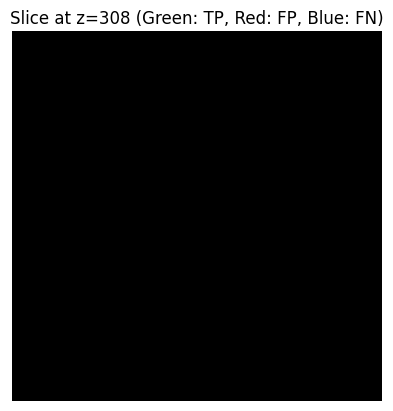

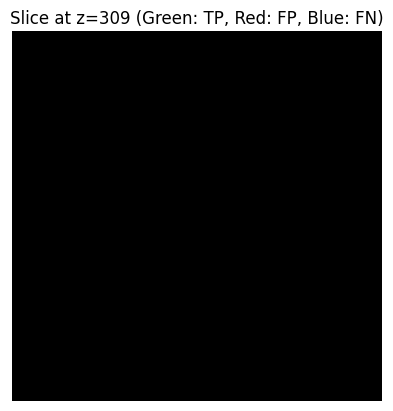

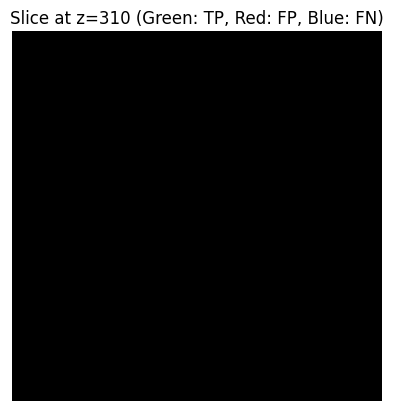

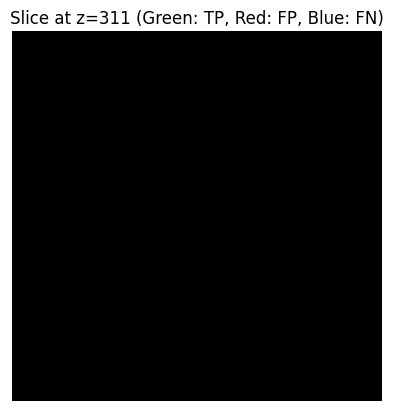

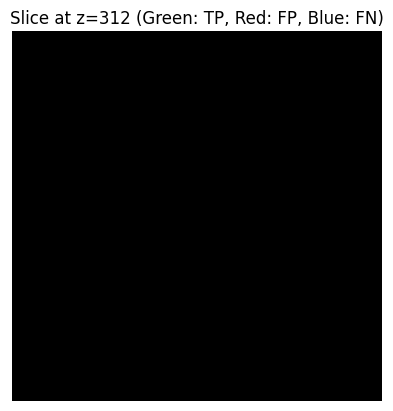

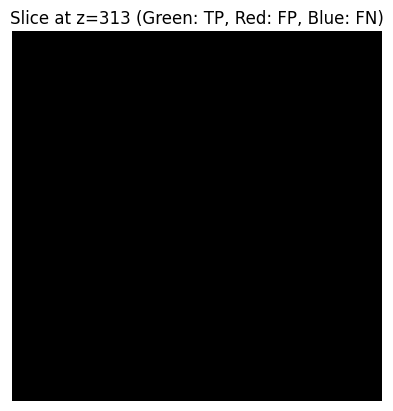

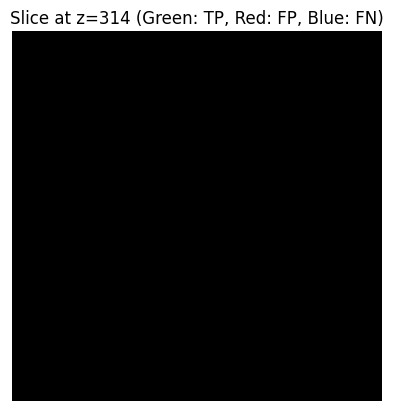

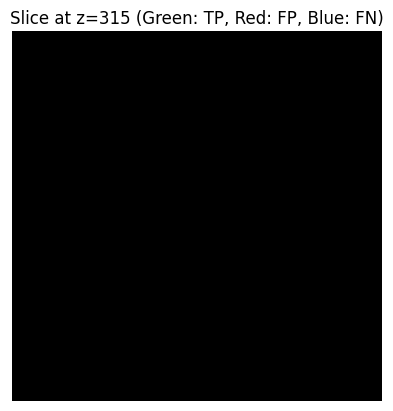

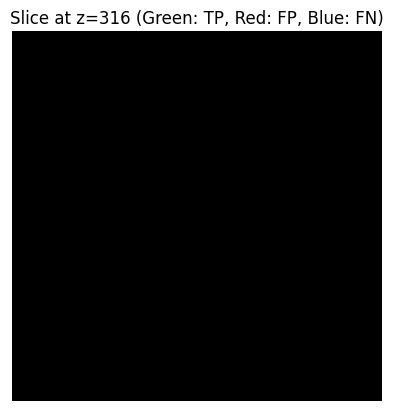

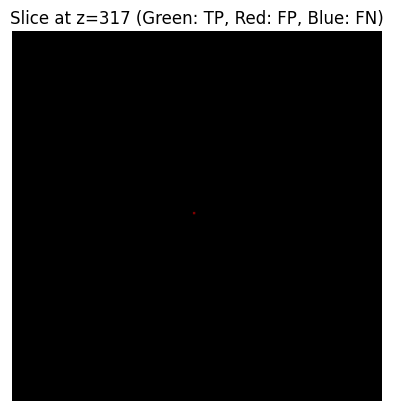

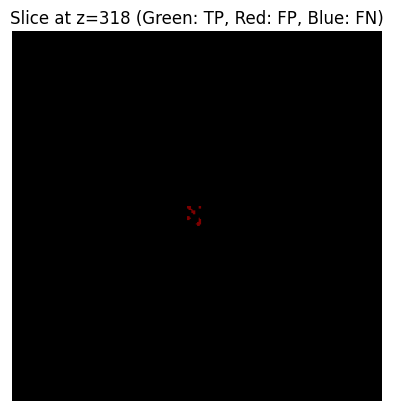

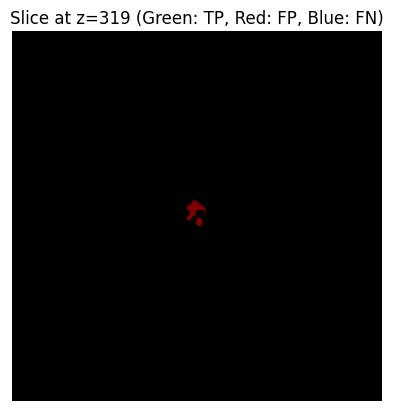

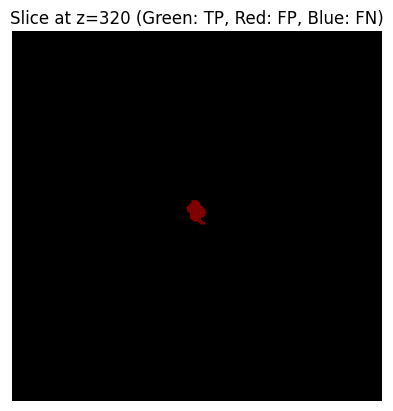

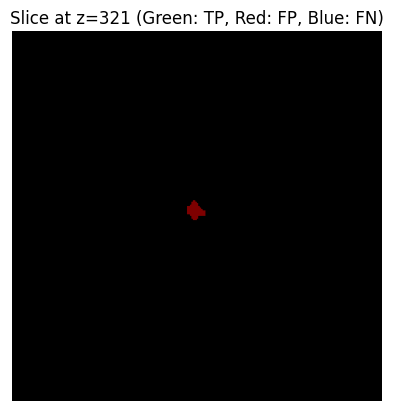

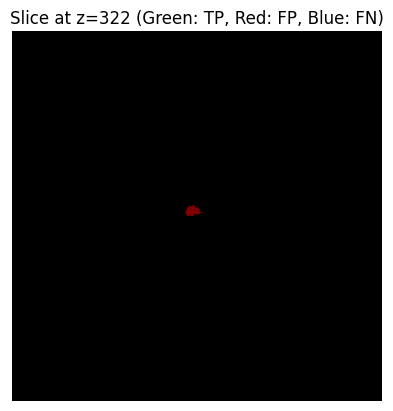

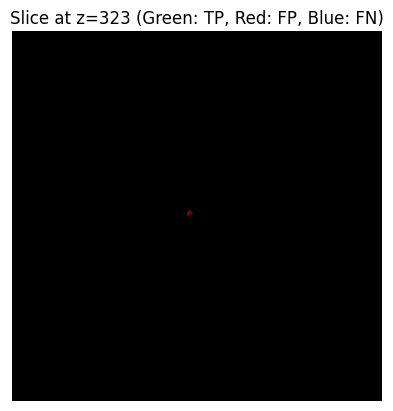

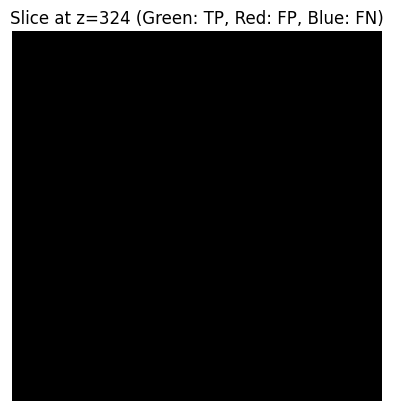

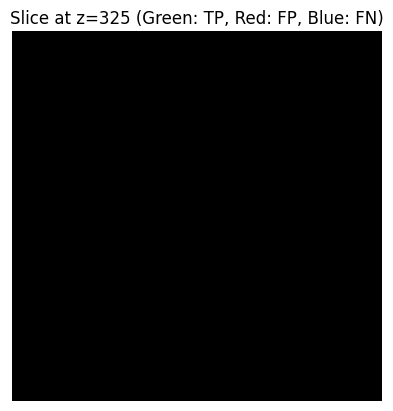

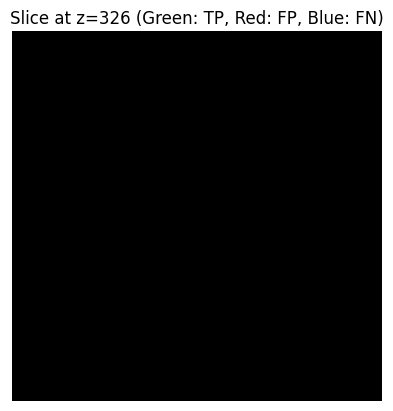

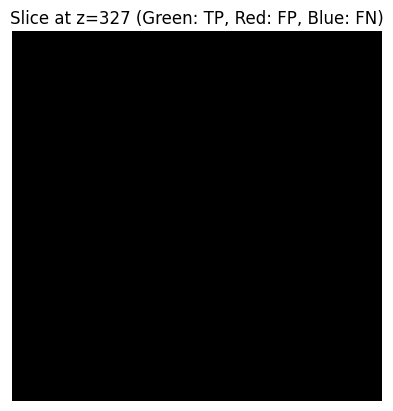

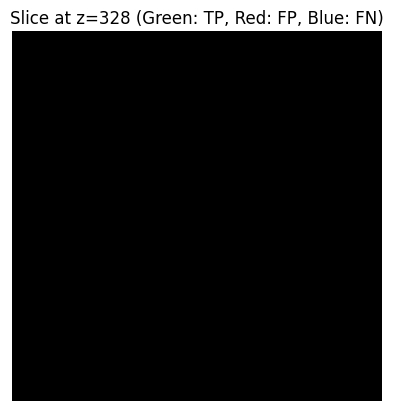

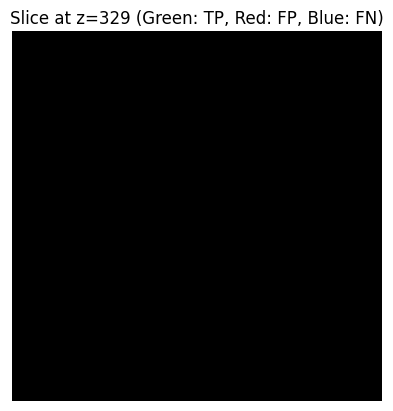

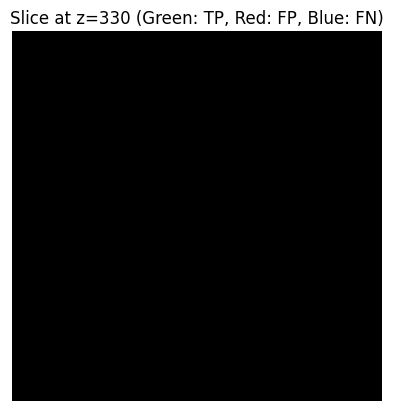

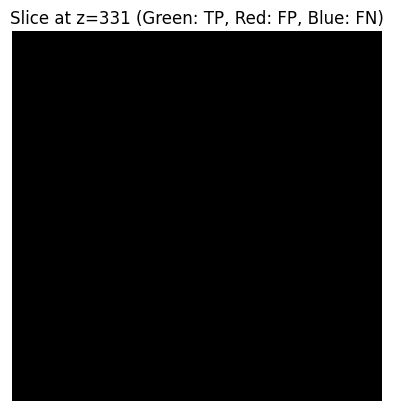

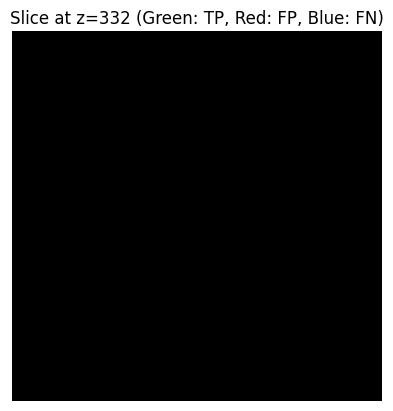

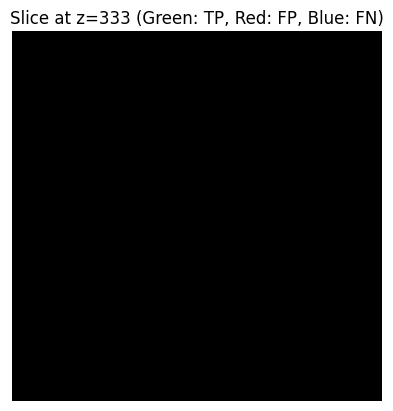

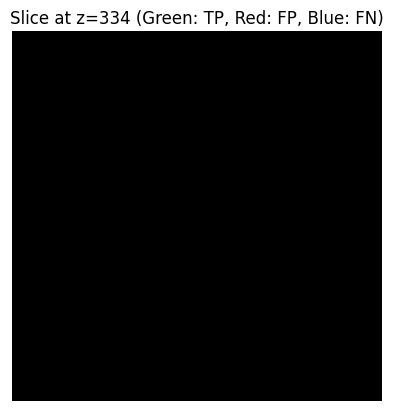

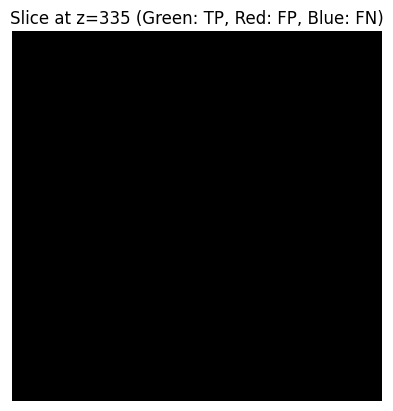

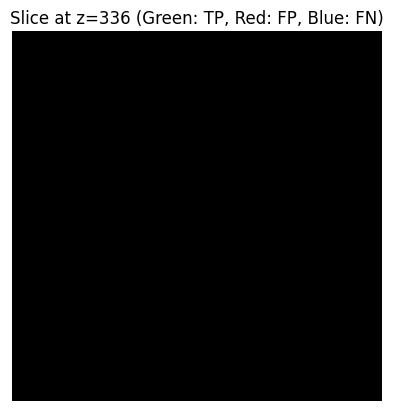

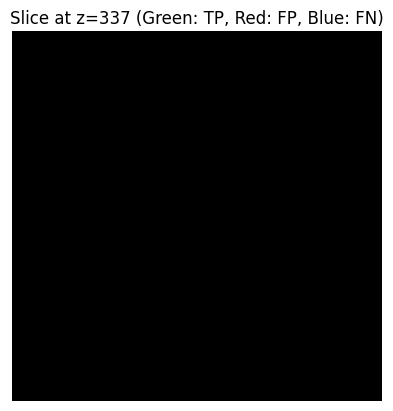

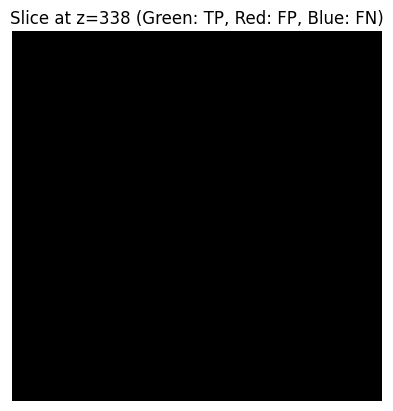

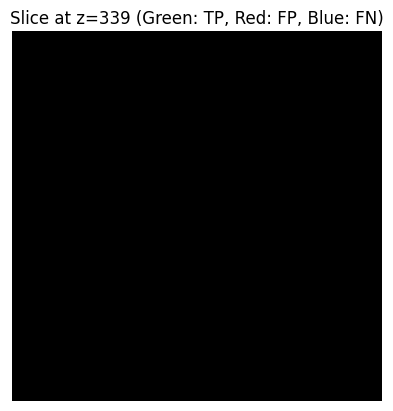

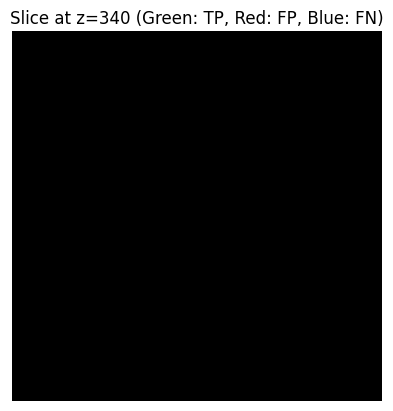

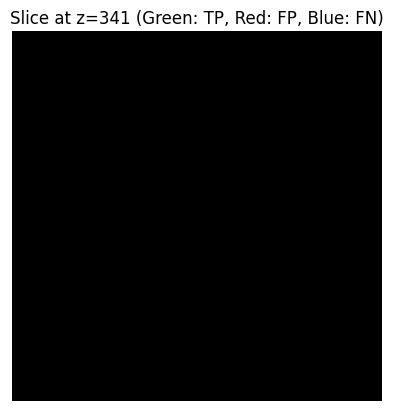

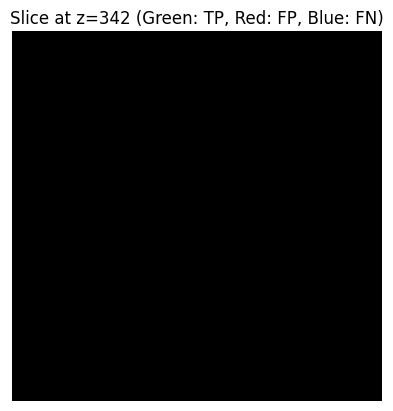

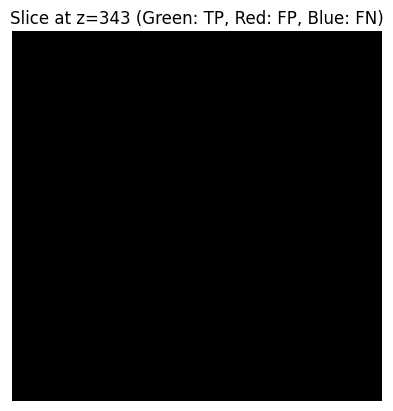

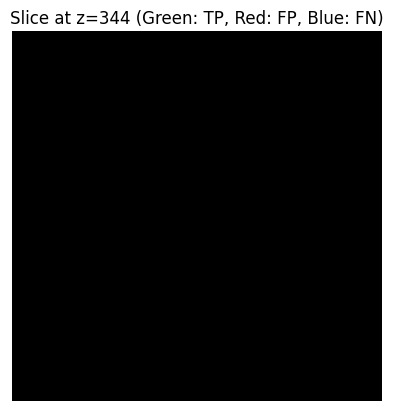

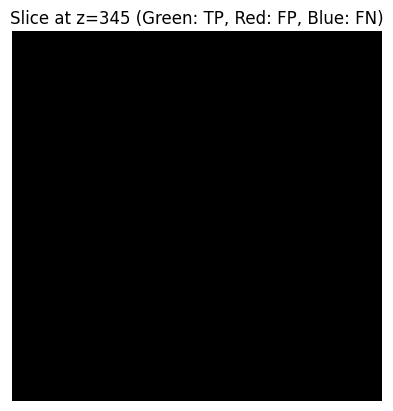

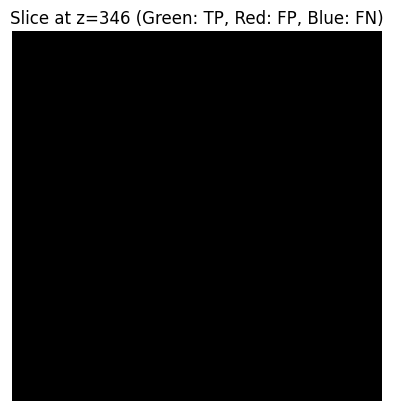

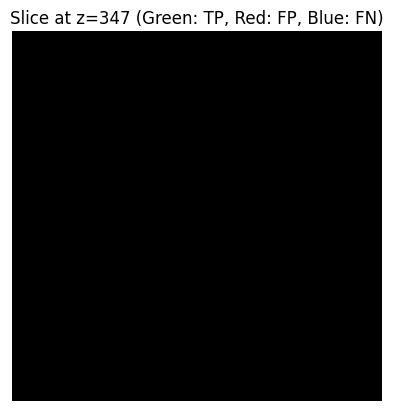

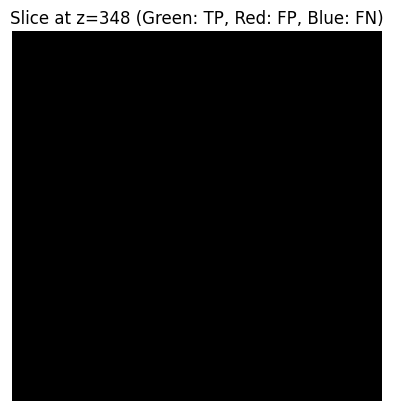

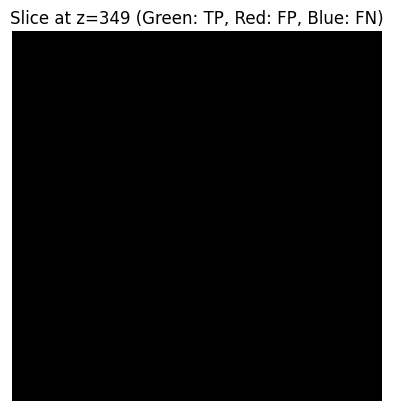

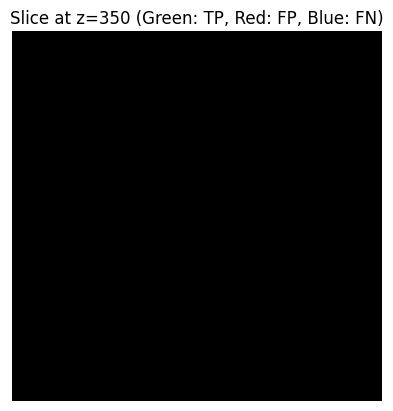

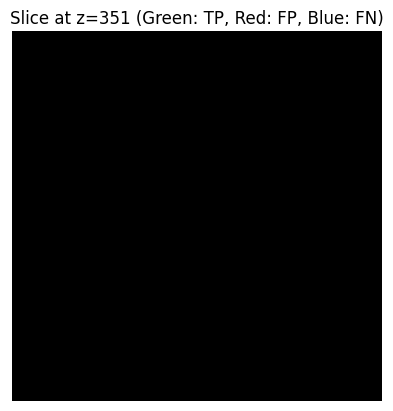

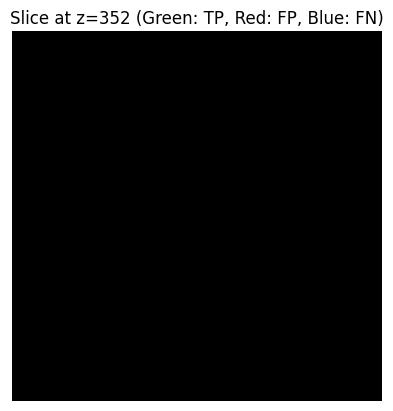

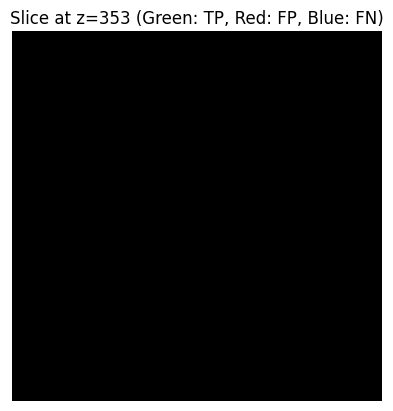

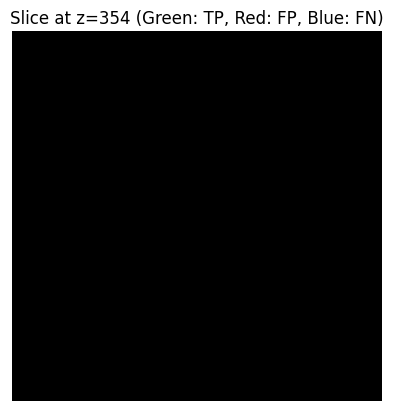

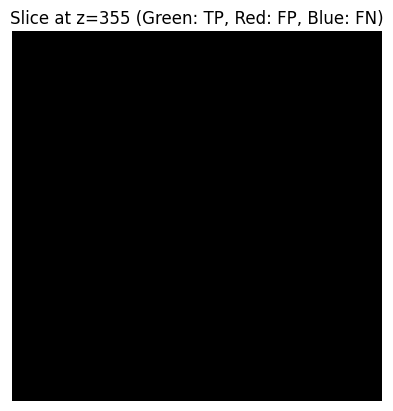

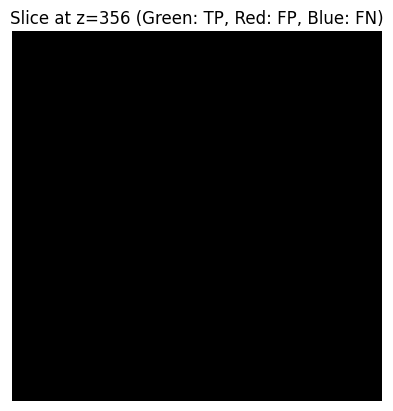

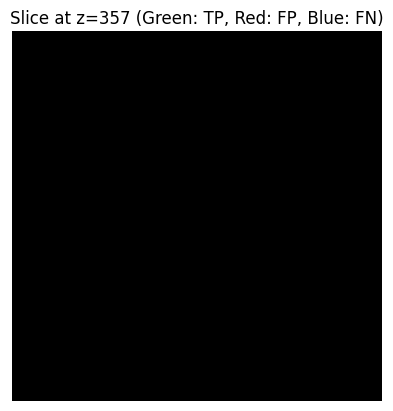

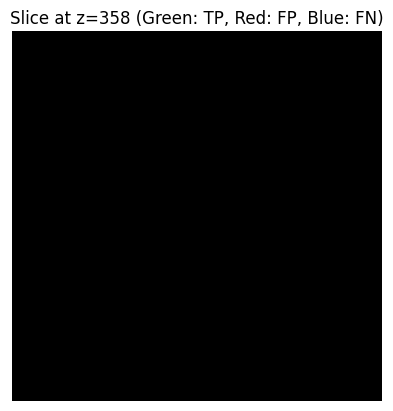

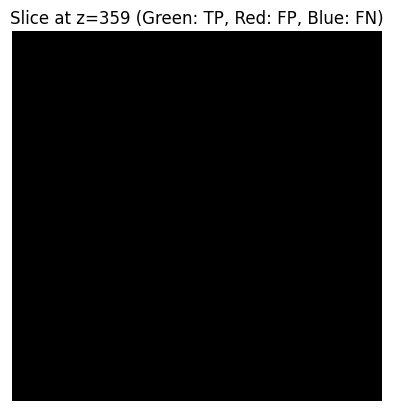

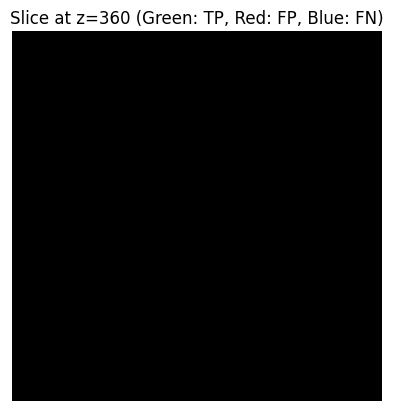

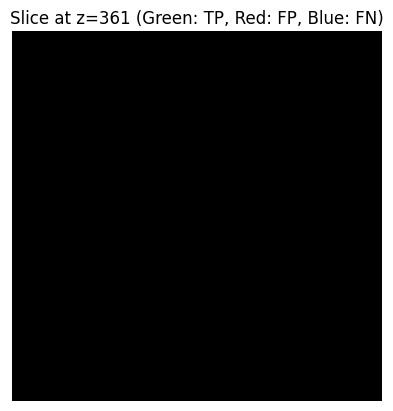

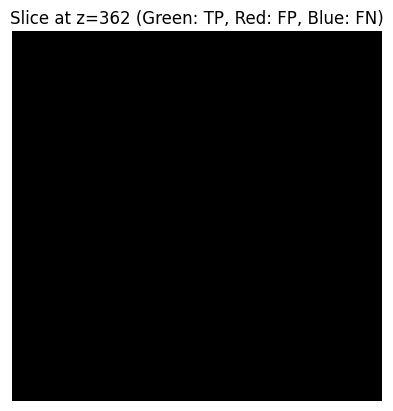

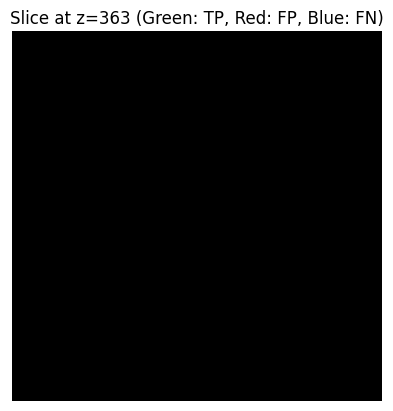

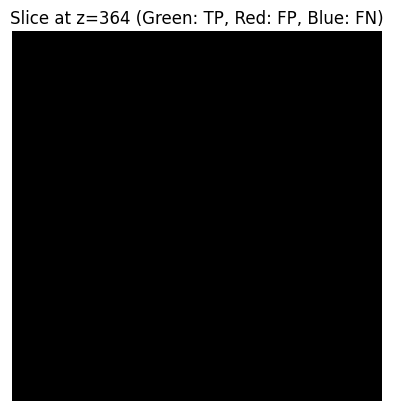

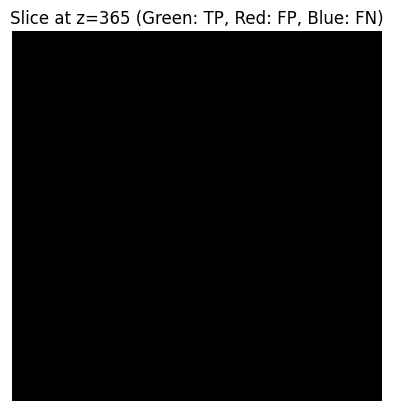

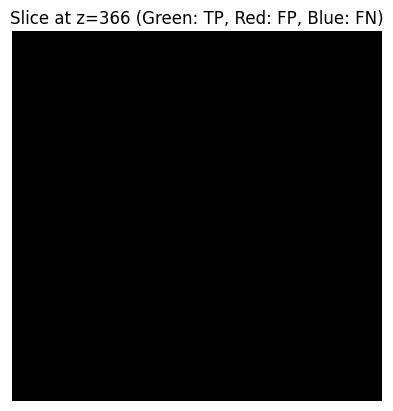

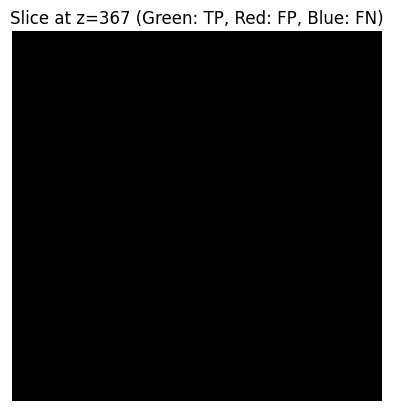

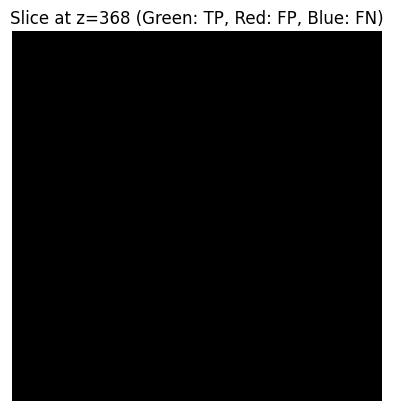

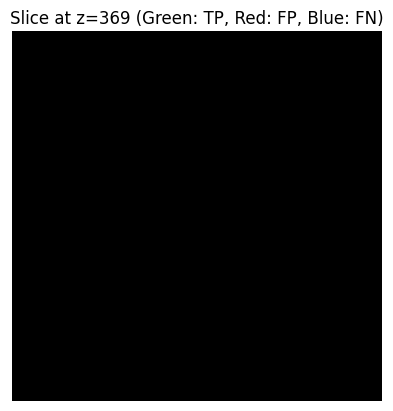

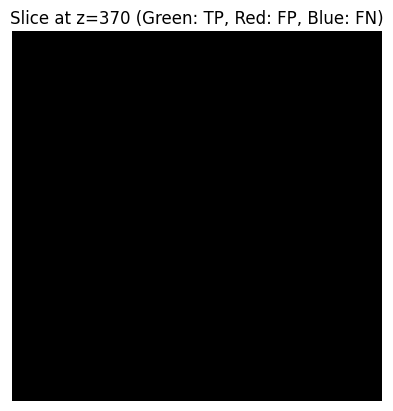

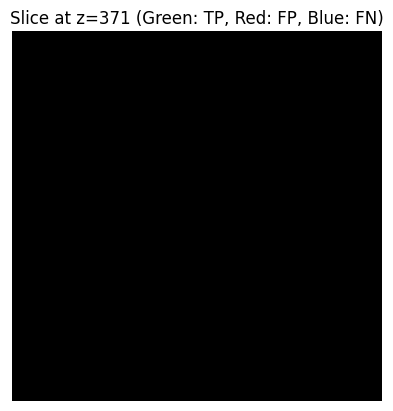

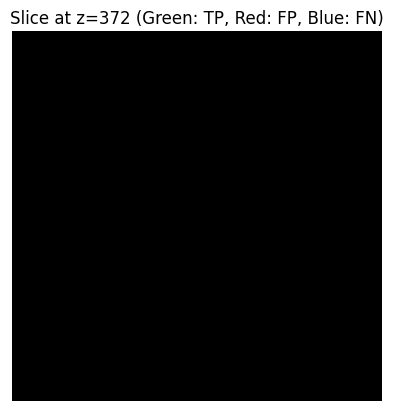

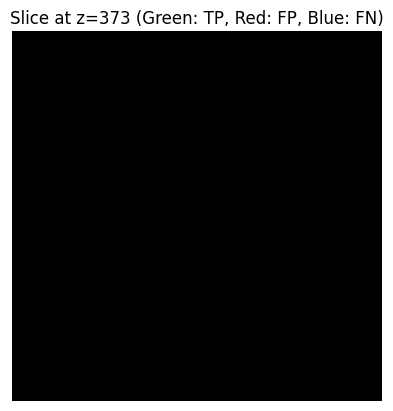

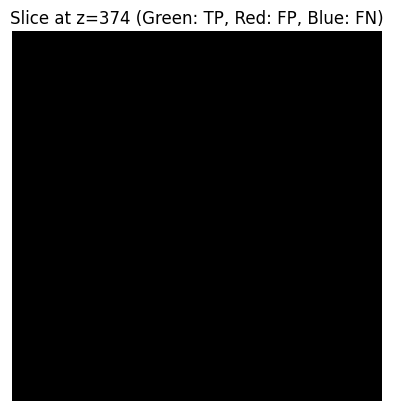

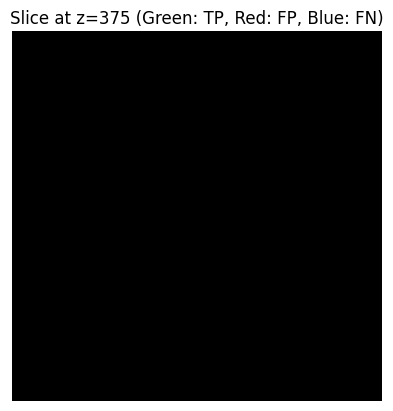

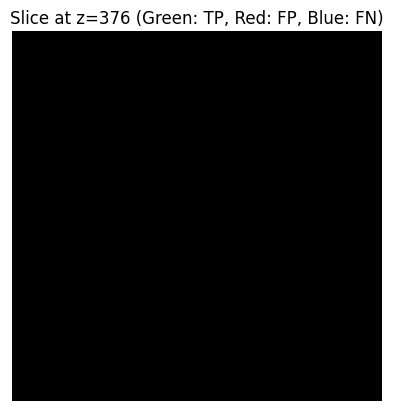

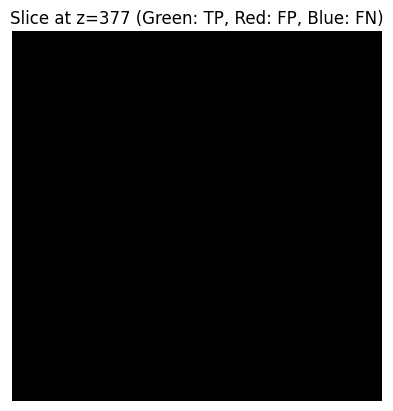

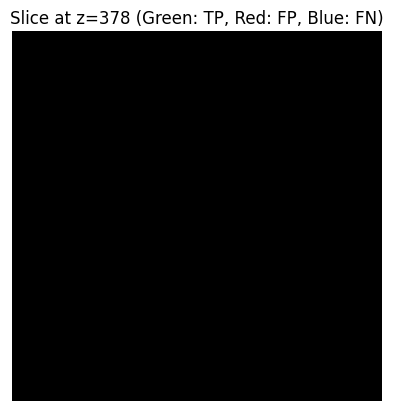

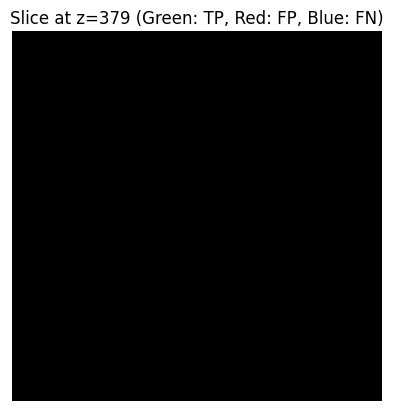

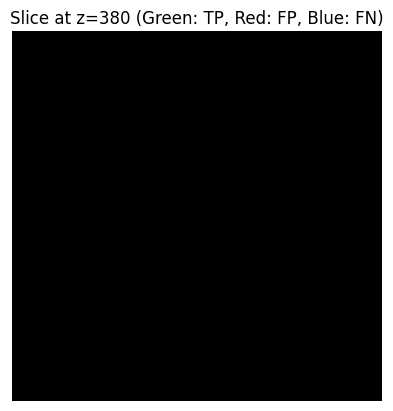

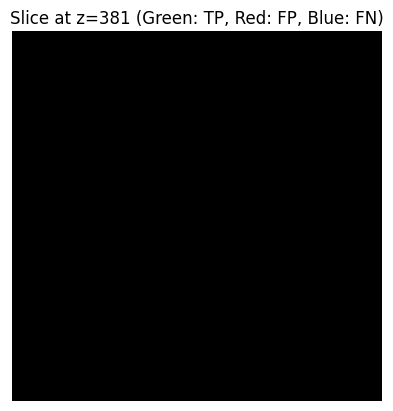

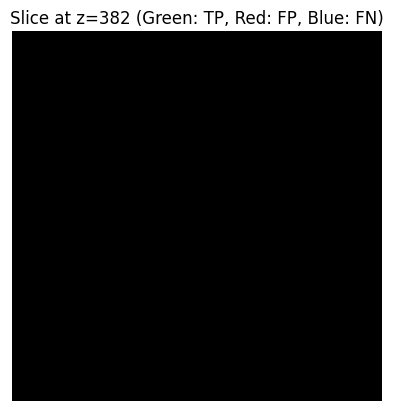

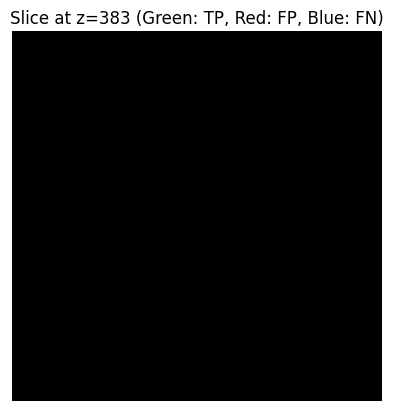

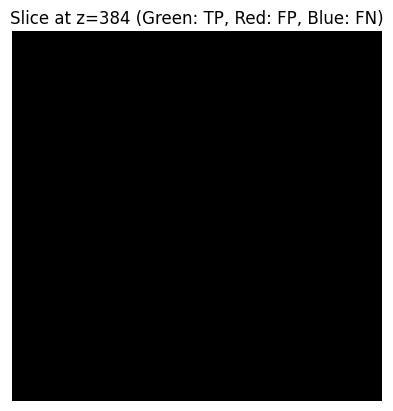

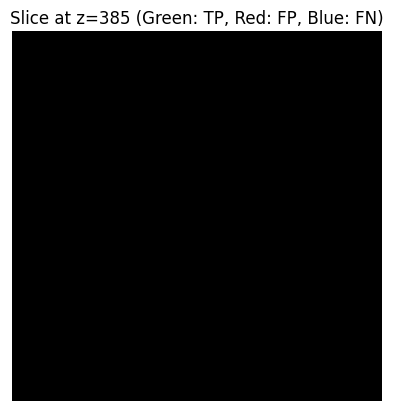

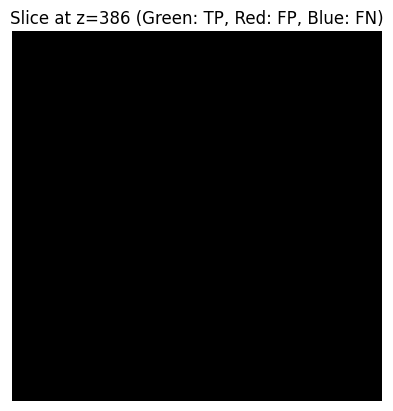

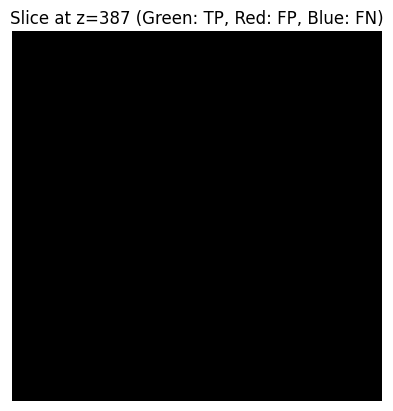

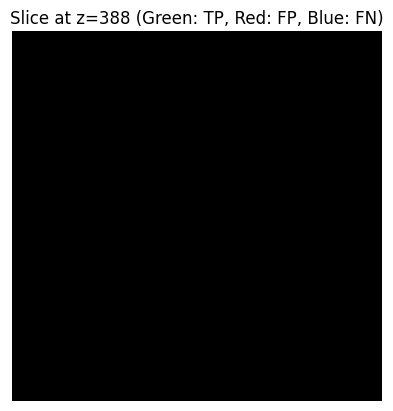

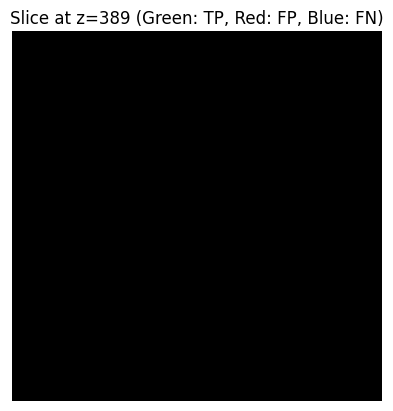

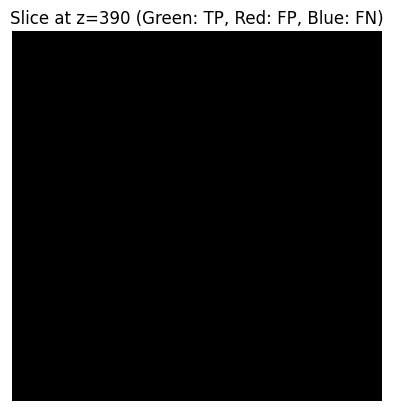

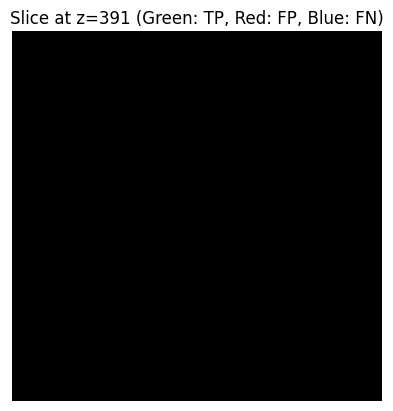

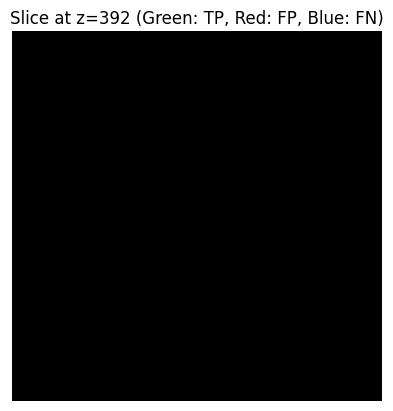

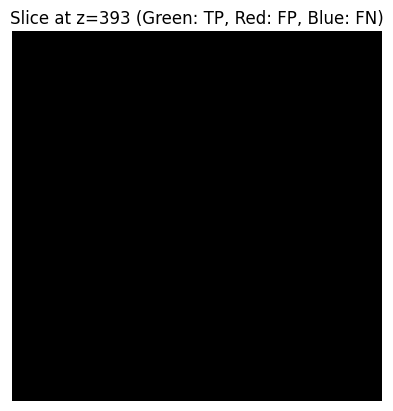

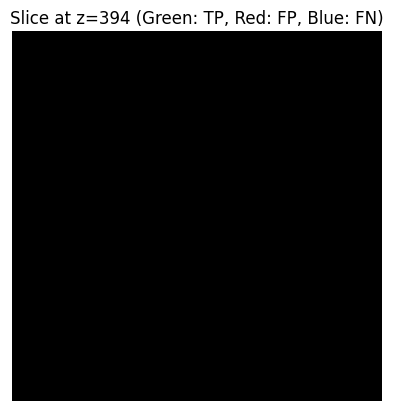

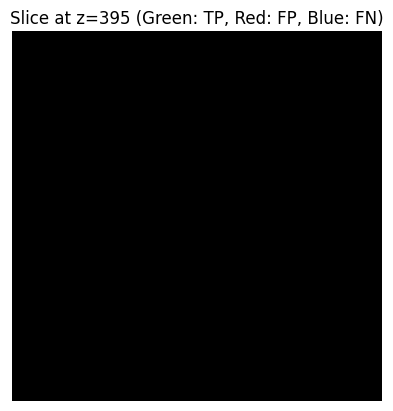

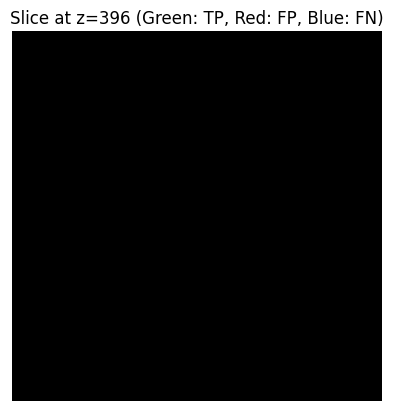

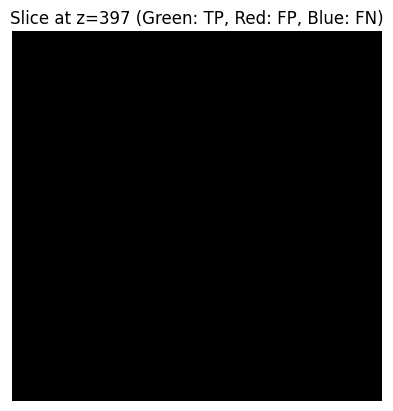

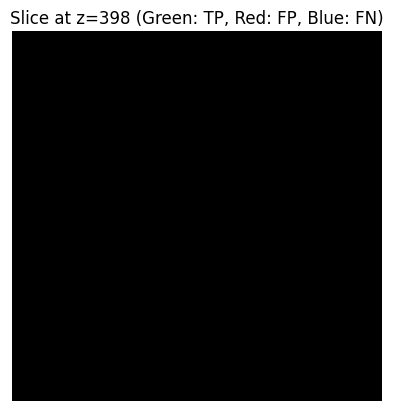

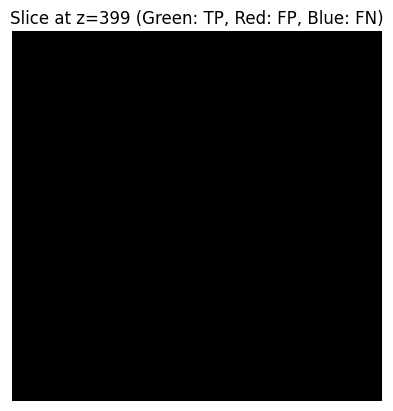

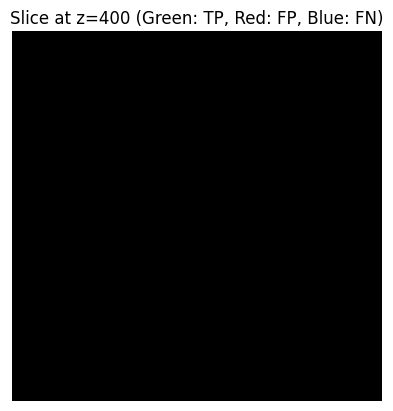

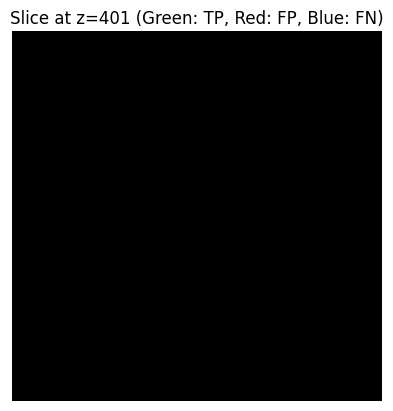

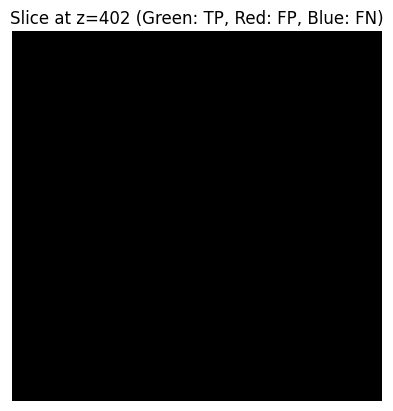

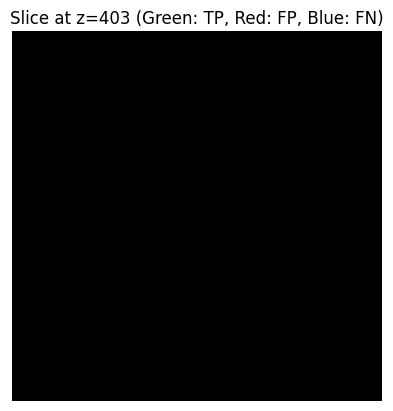

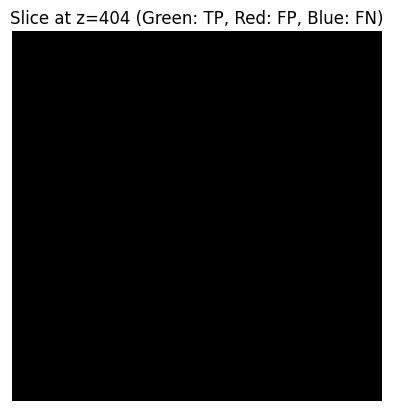

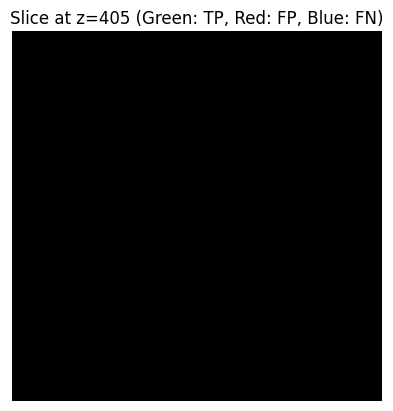

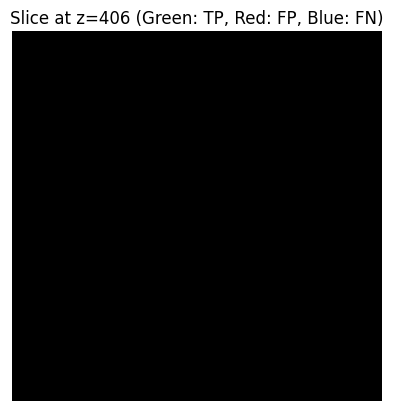

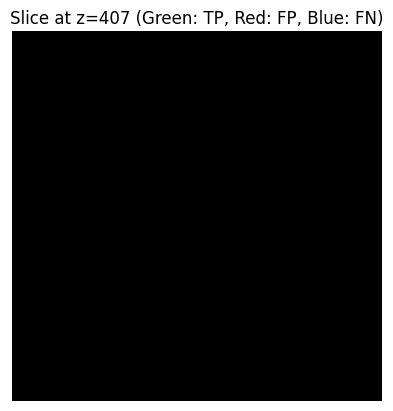

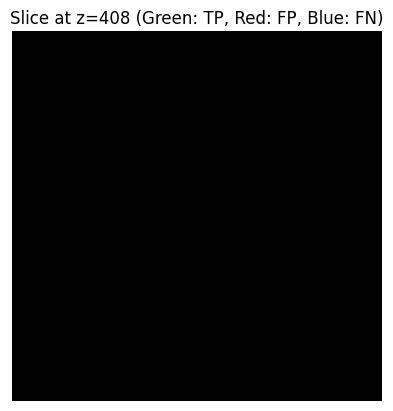

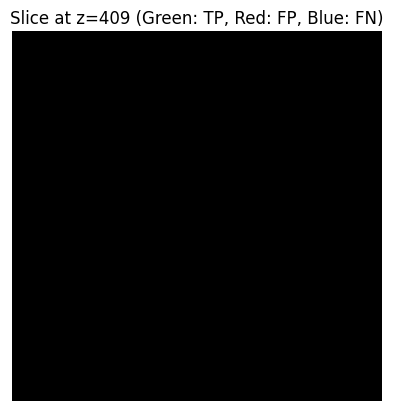

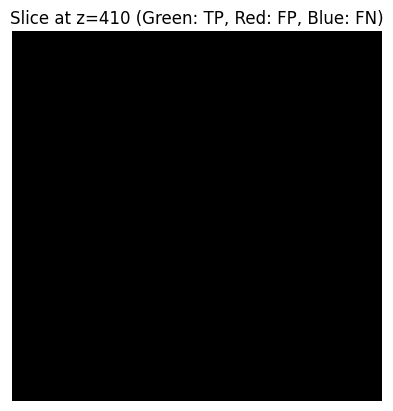

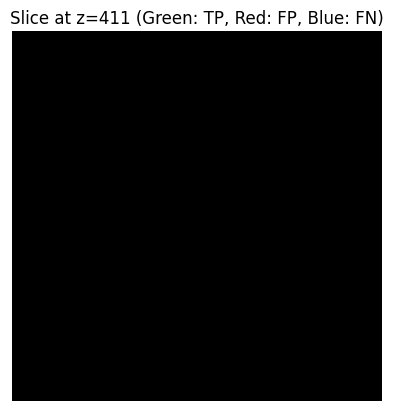

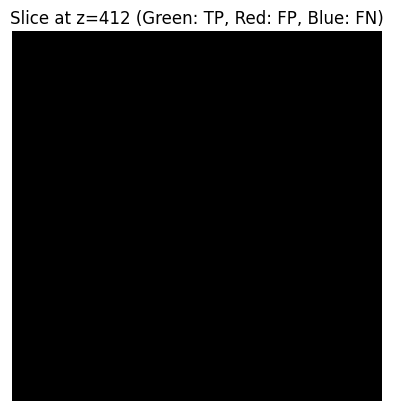

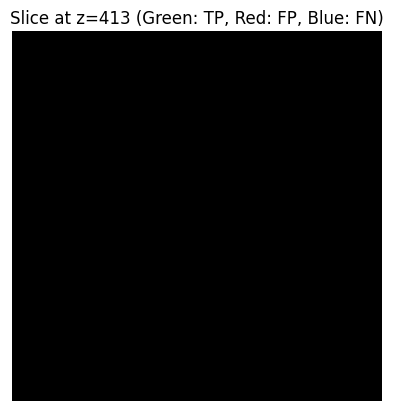

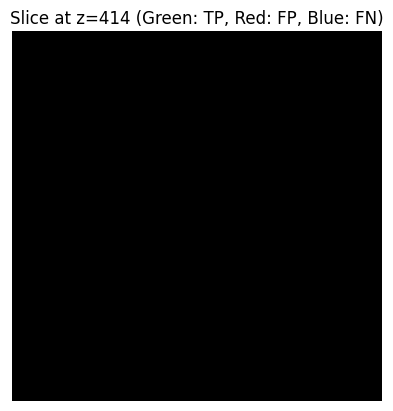

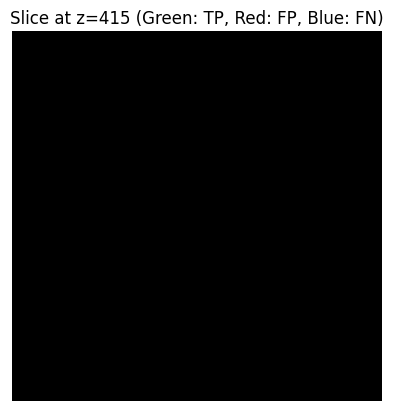

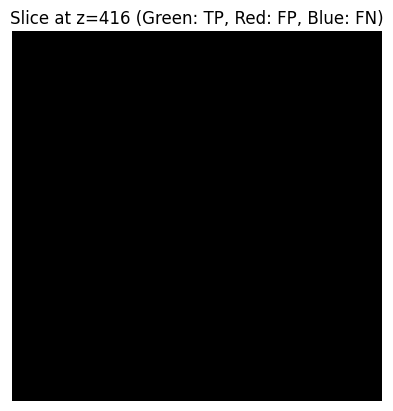

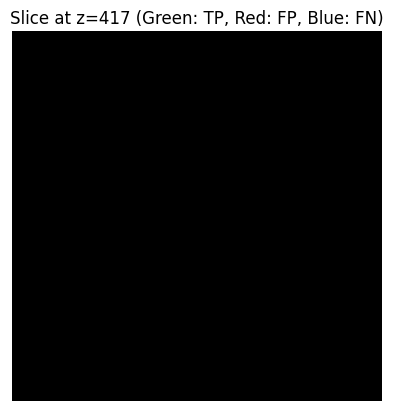

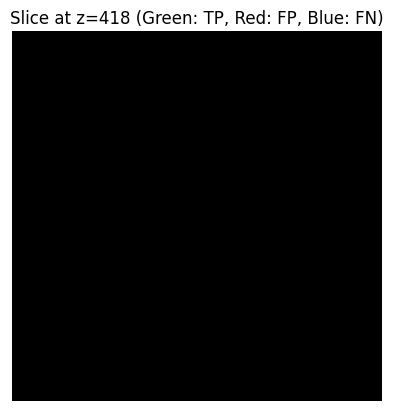

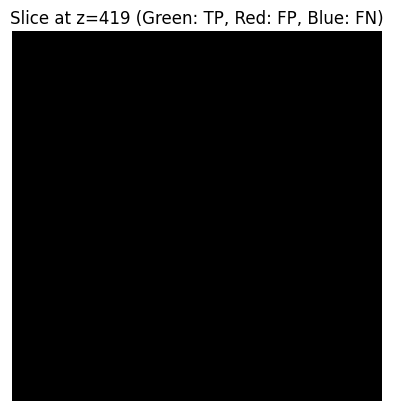

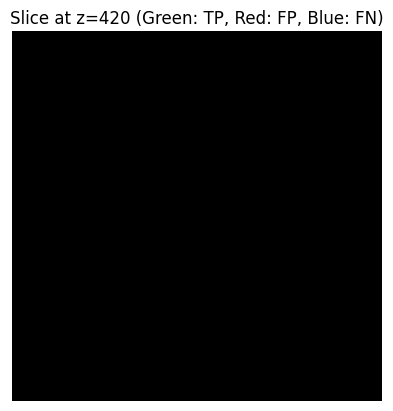

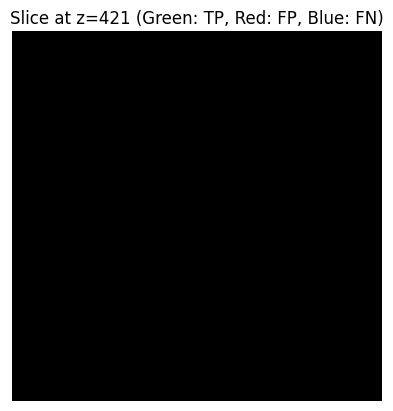

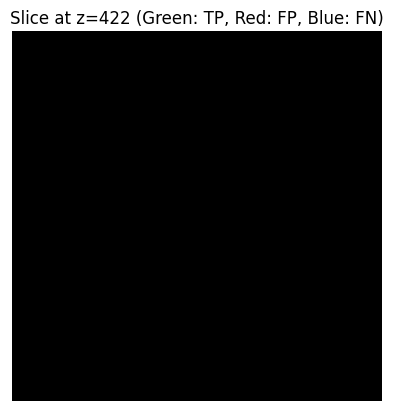

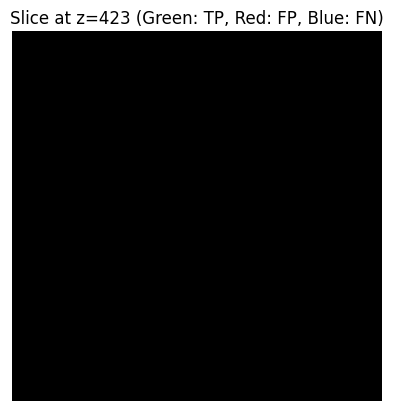

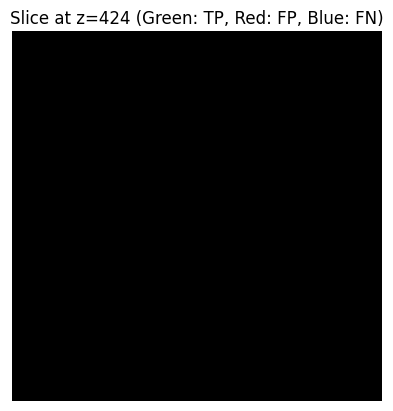

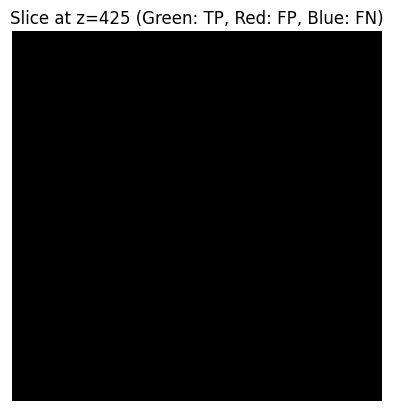

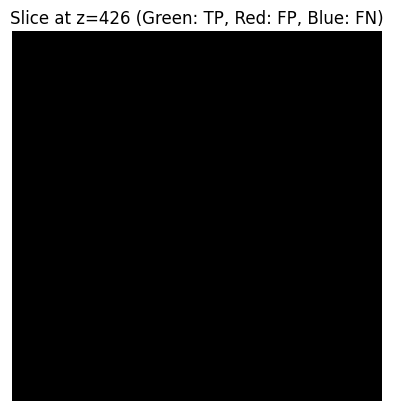

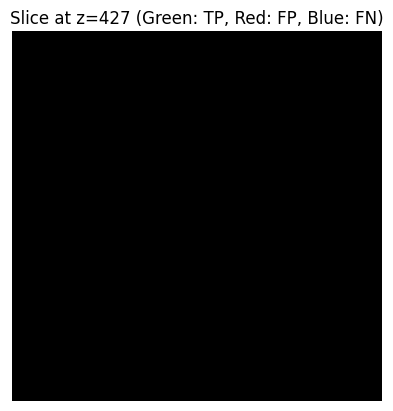

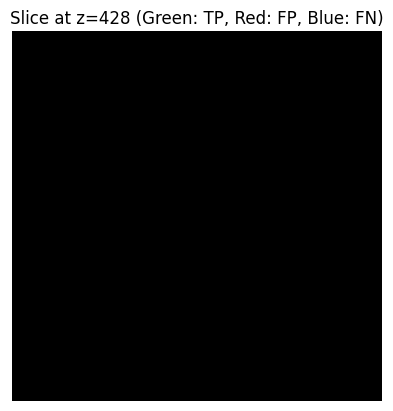

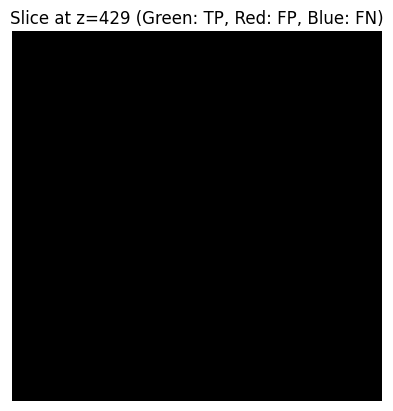

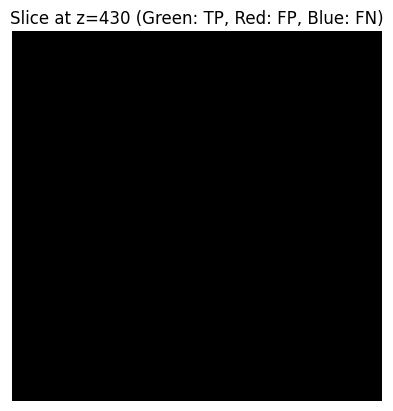

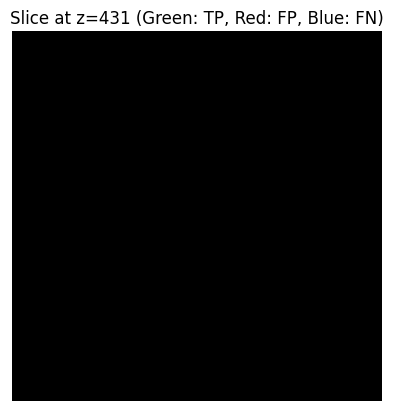

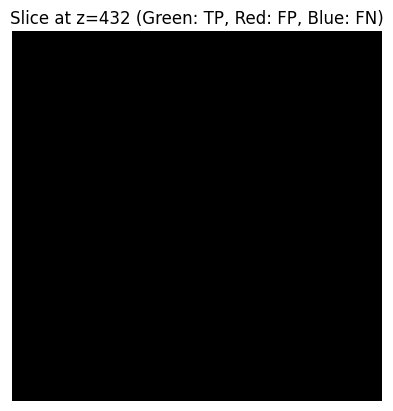

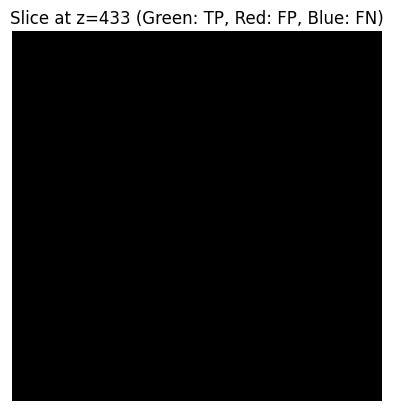

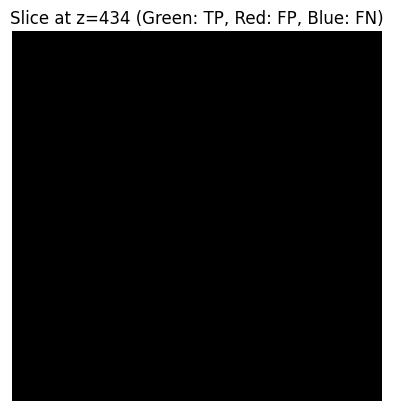

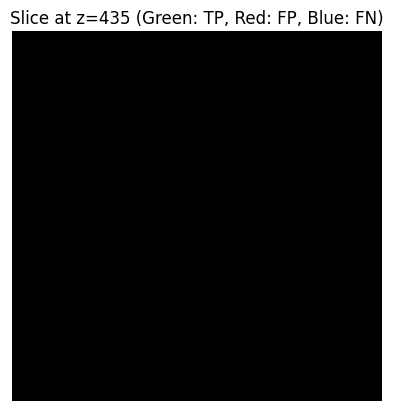

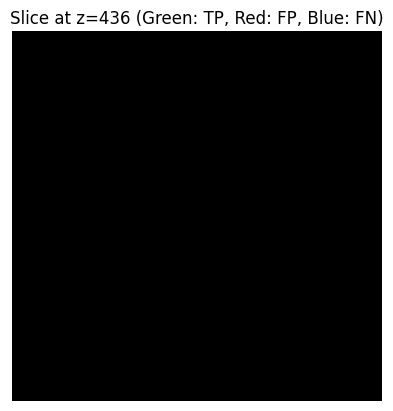

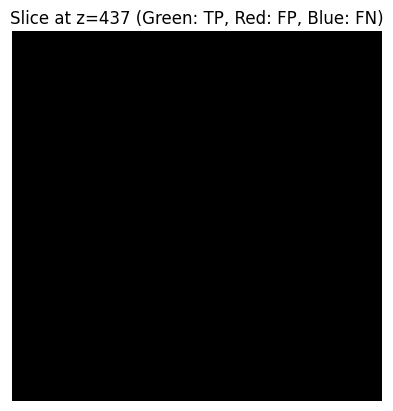

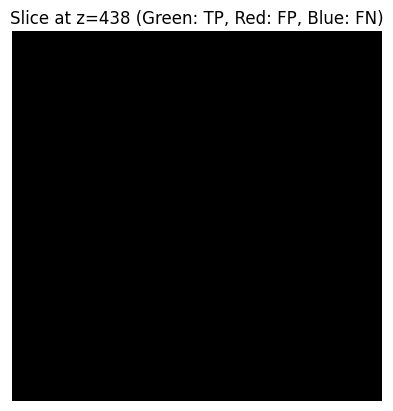

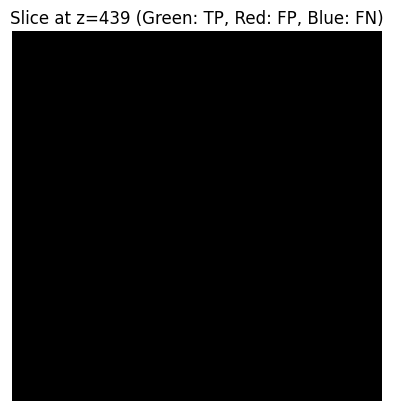

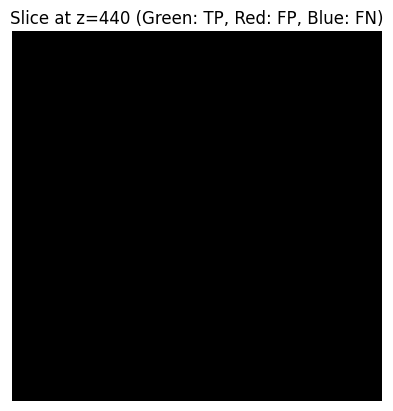

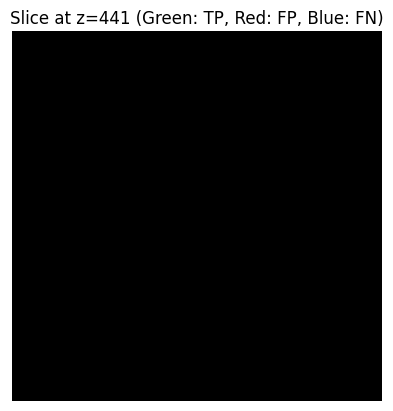

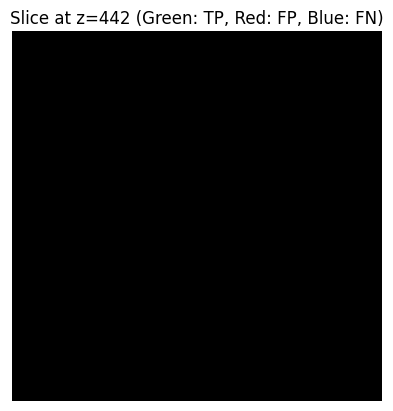

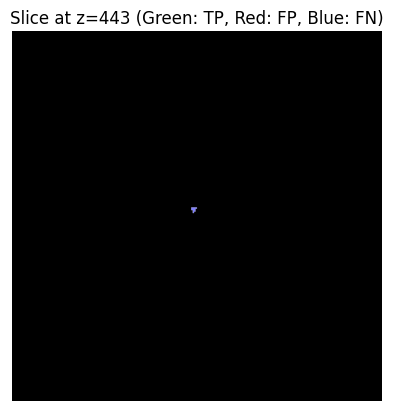

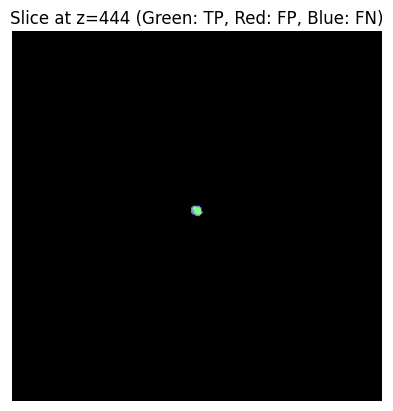

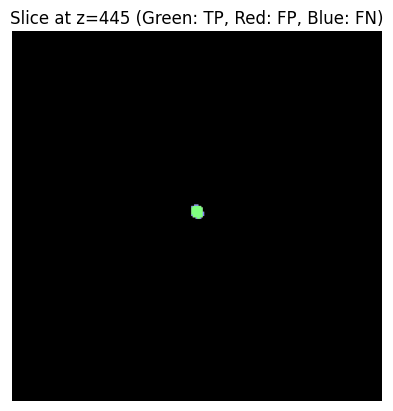

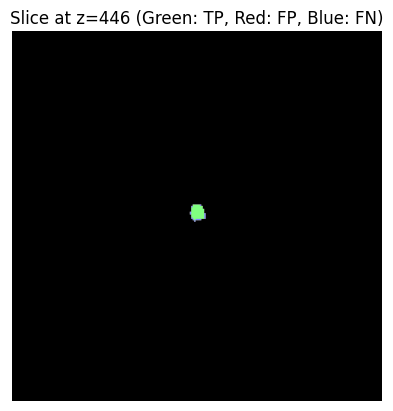

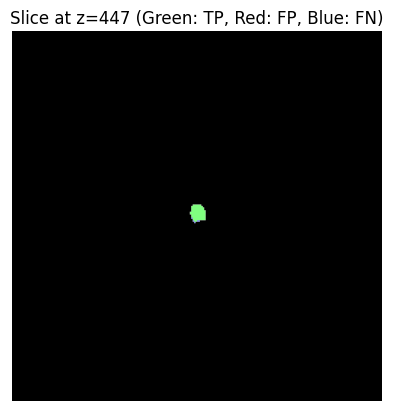

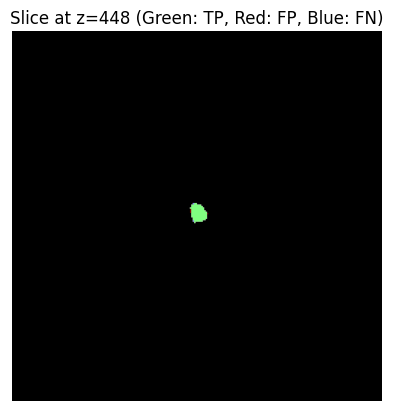

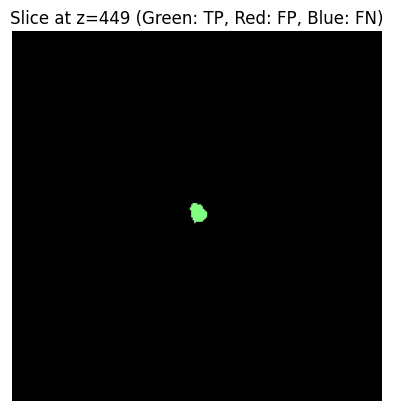

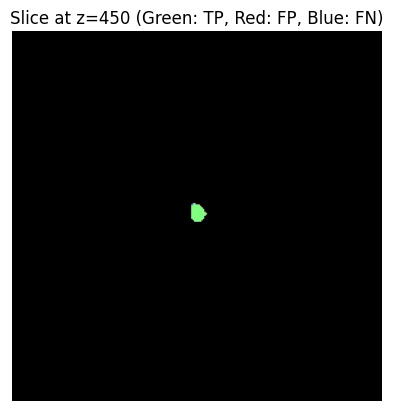

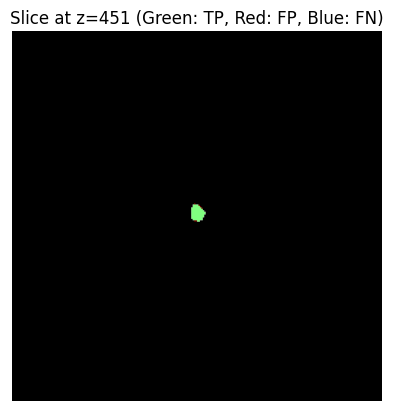

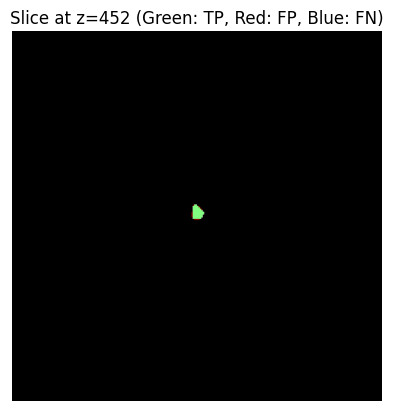

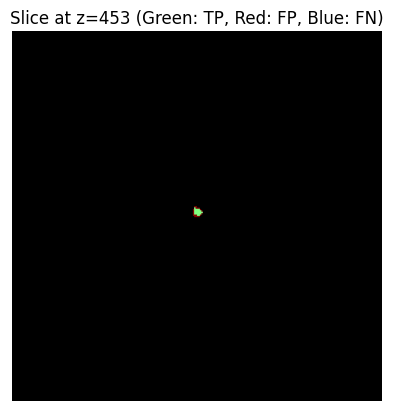

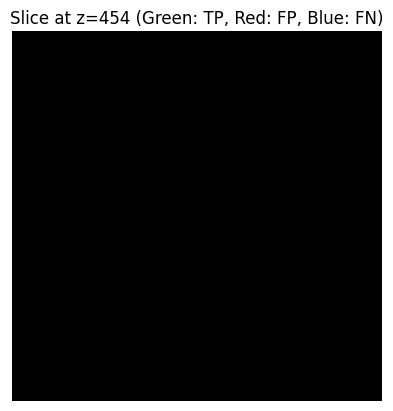

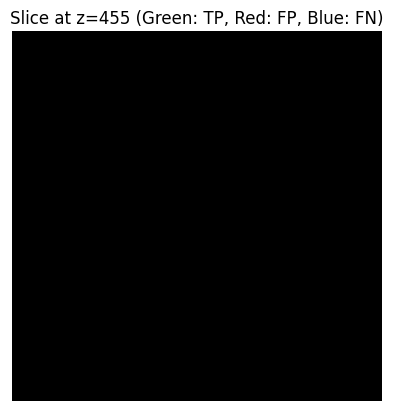

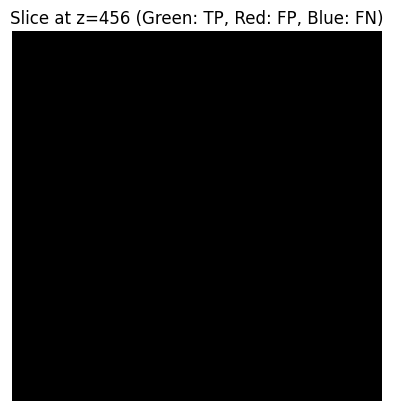

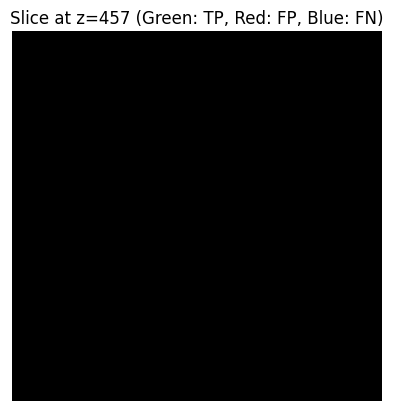

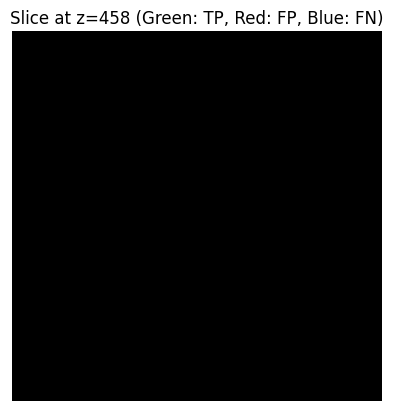

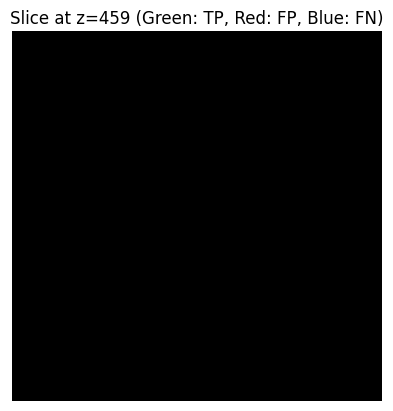

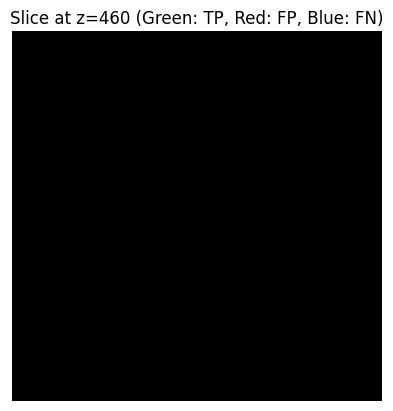

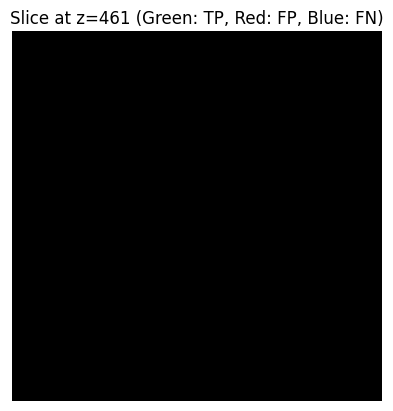

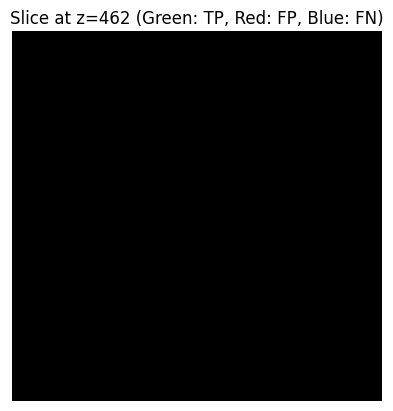

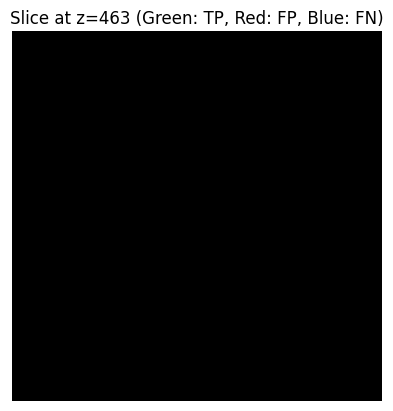

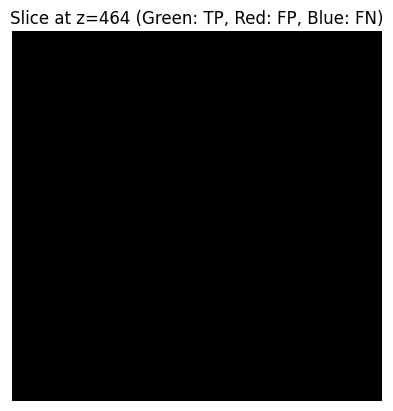

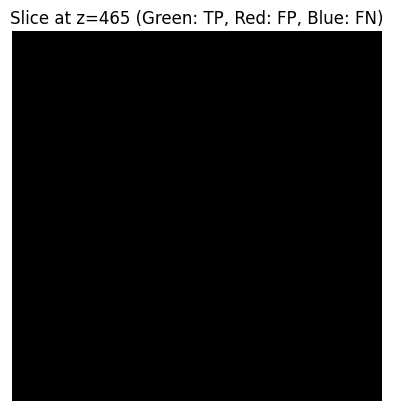

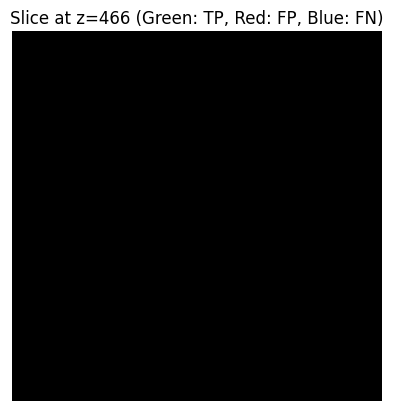

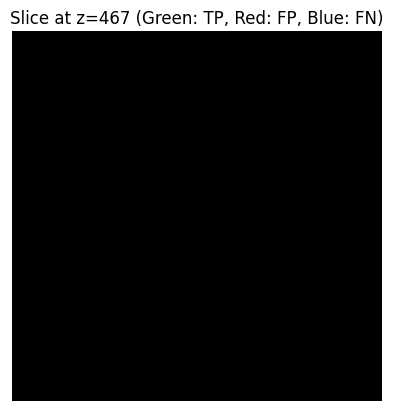

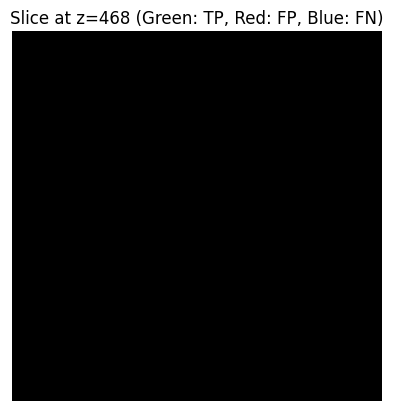

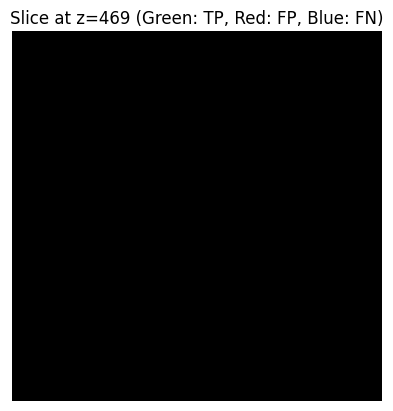

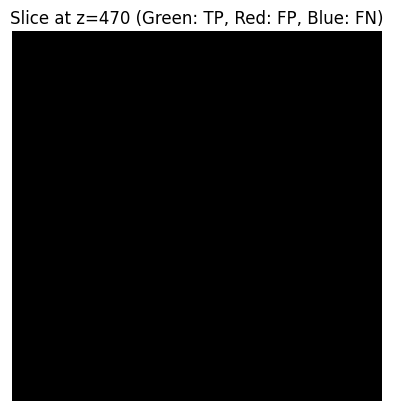

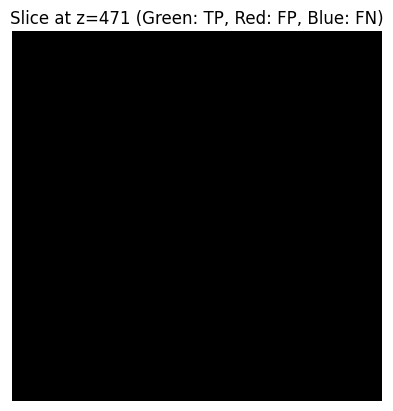

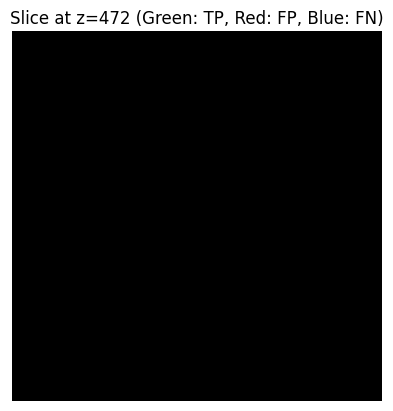

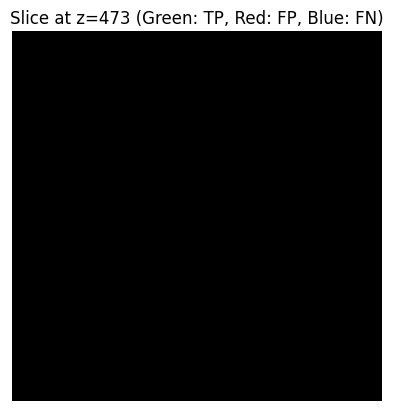

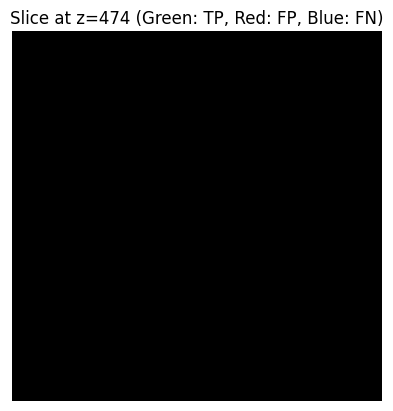

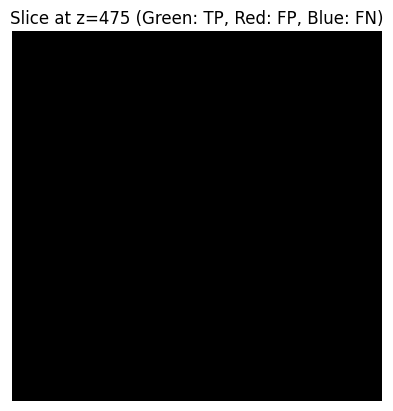

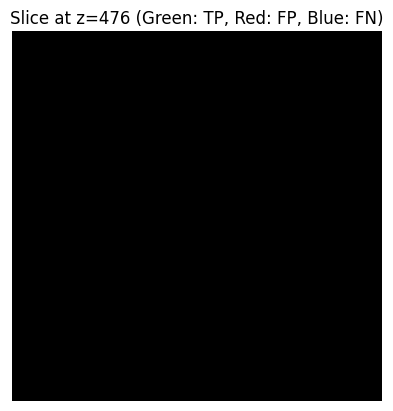

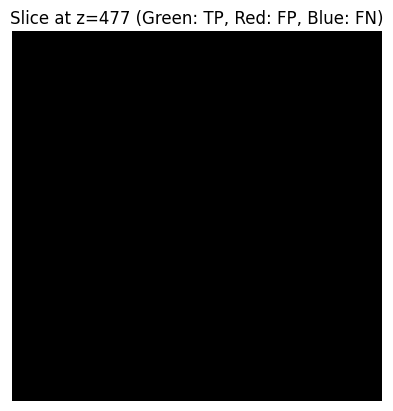

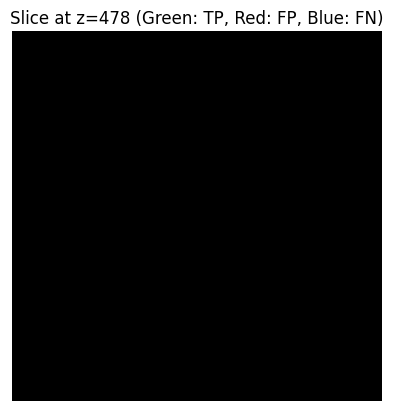

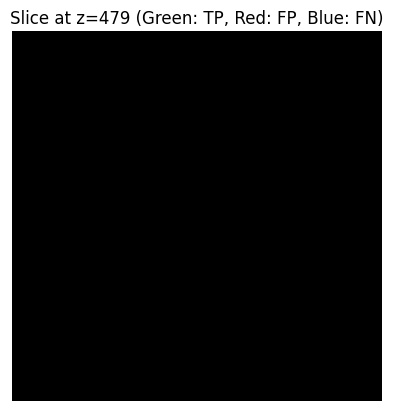

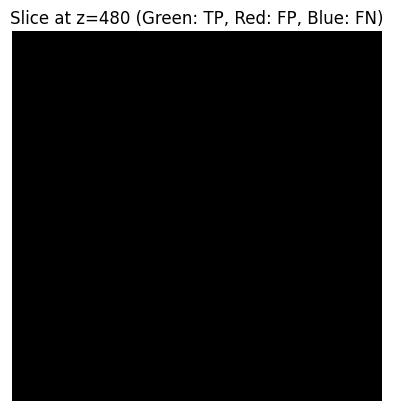

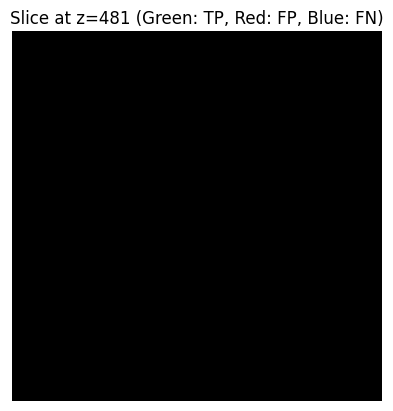

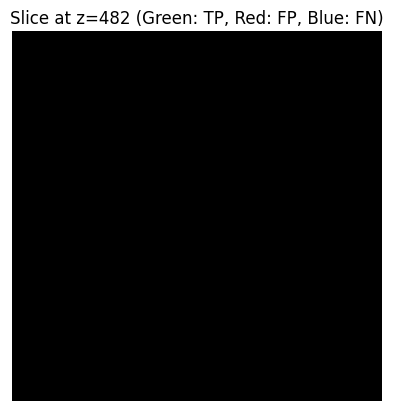

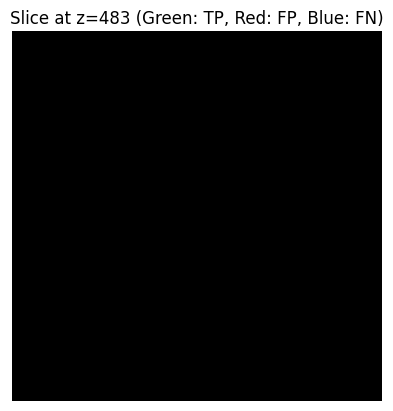

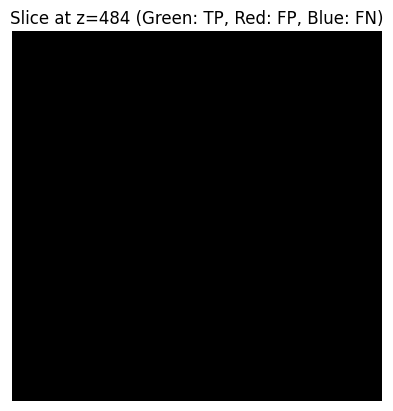

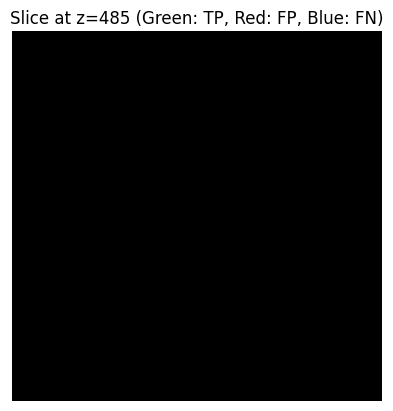

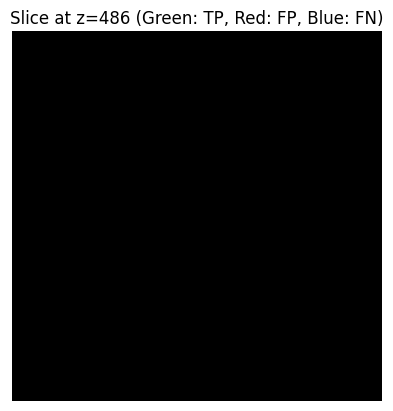

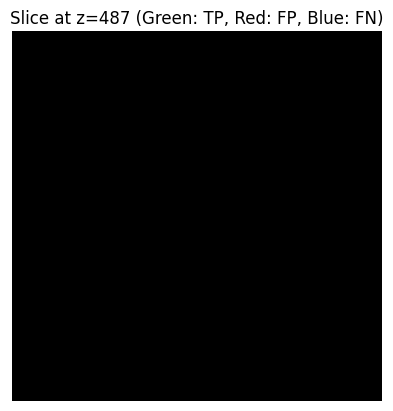

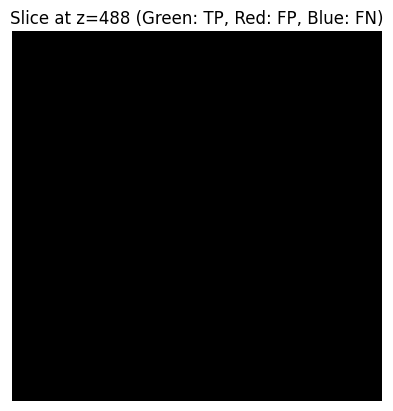

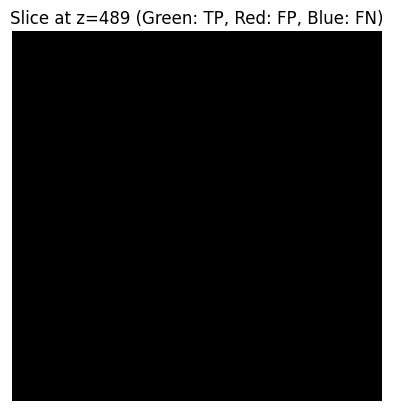

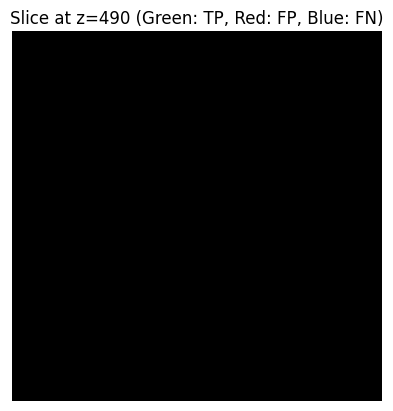

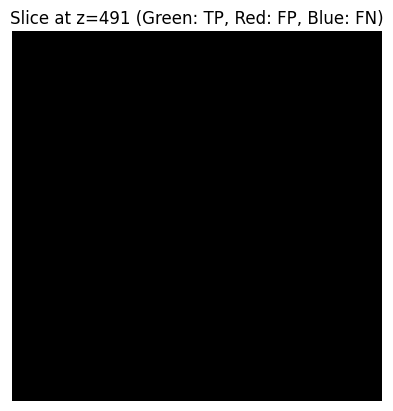

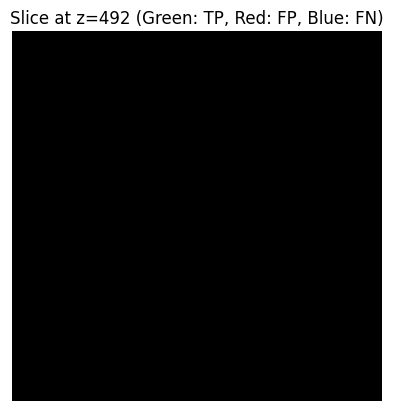

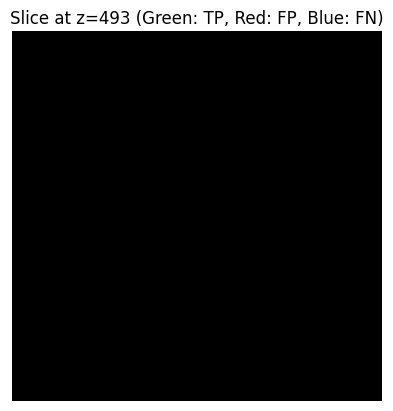

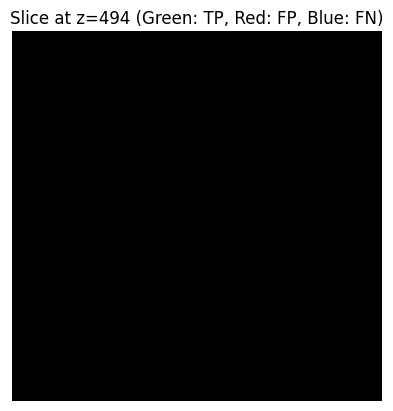

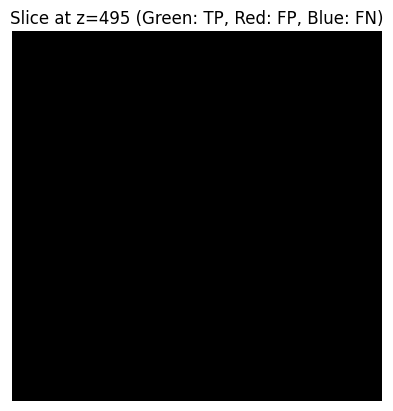

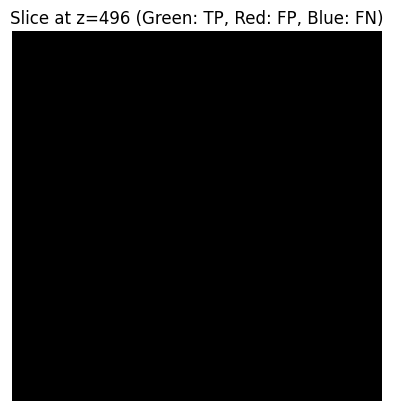

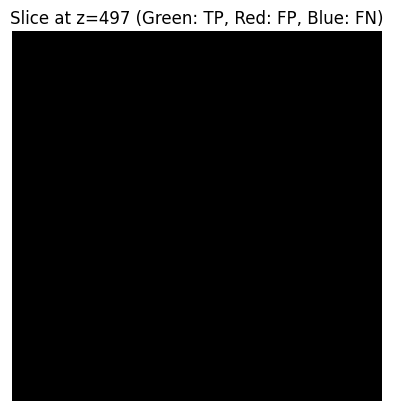

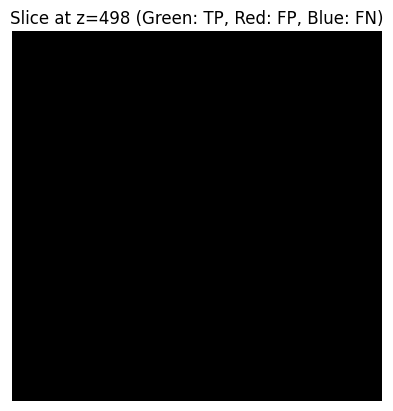

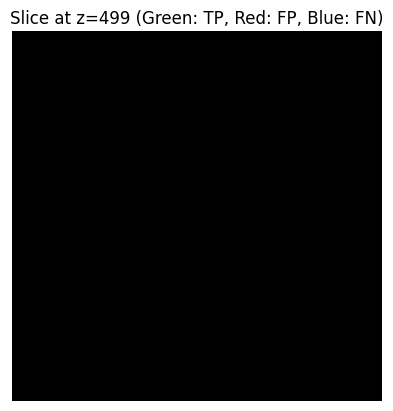

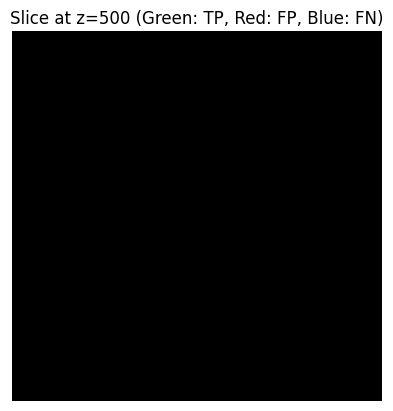

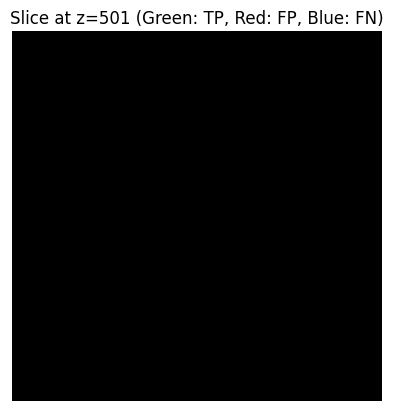

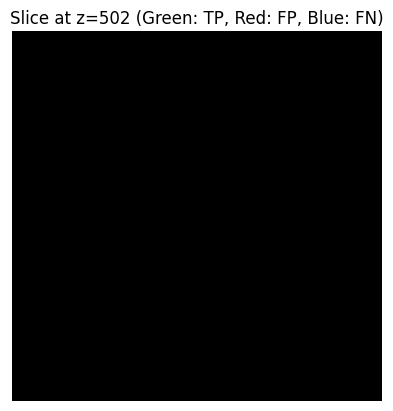

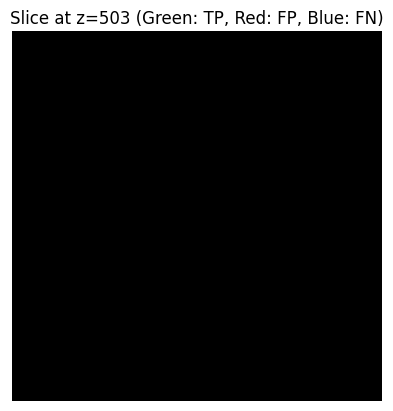

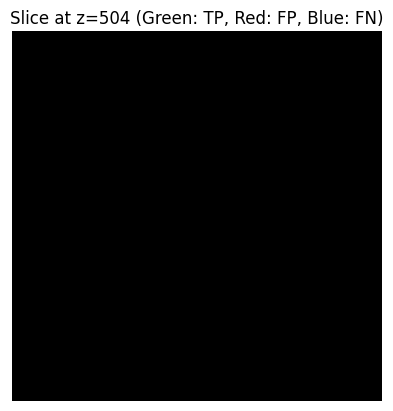

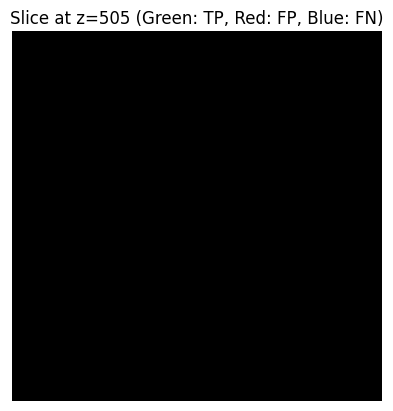

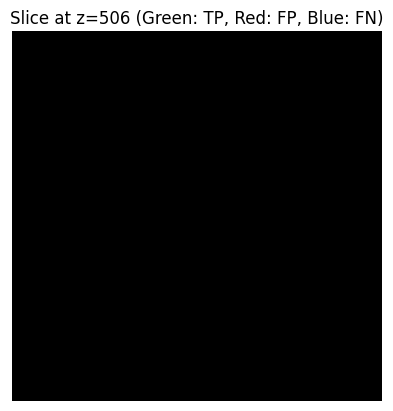

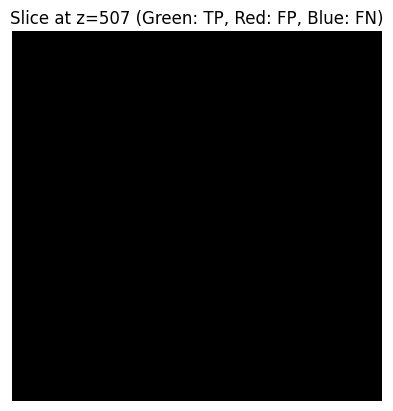

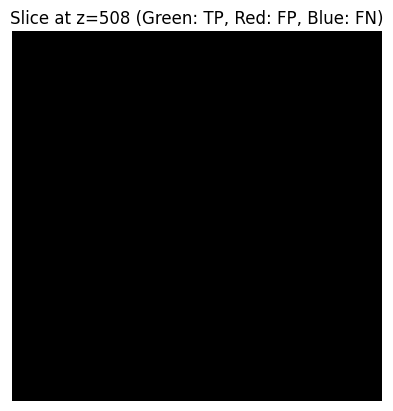

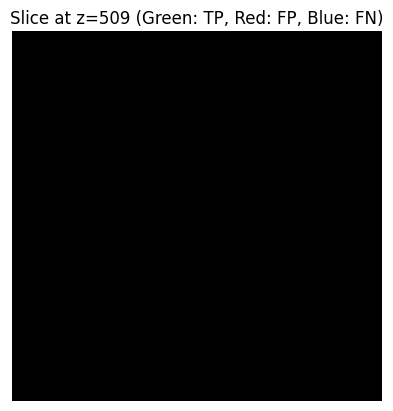

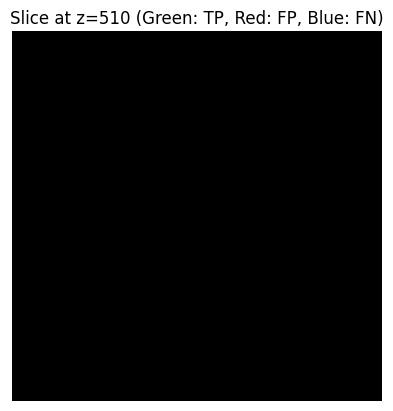

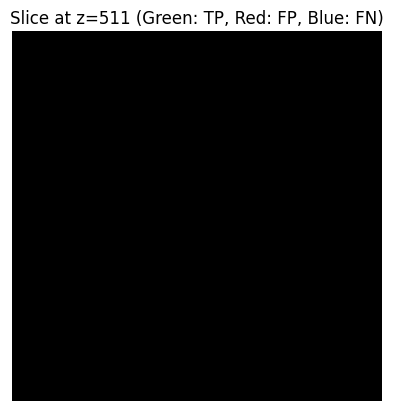

In [25]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
z = 10  # Change this value to select a different slice

def normalize(x:np.ndarray)->np.ndarray:
    # Transform features by scaling each feature to a given range.
    scaler = MinMaxScaler(feature_range=(0, 1))
    # (H, W, D) -> (H * W, D)
    normalized_1D_array = scaler.fit_transform(x.reshape(-1, x.shape[-1]))
    normalized_data = normalized_1D_array.reshape(x.shape)
    return normalized_data

arr = normalize(arr)
im_pred = Uls23().start_pipeline()
arr_pred = sitk.GetArrayFromImage(im_pred)
for zi in range(arr.shape[0]):
    # Show the original image in grayscale
    plt.imshow(arr[zi], cmap='gray')
    # Overlay: True Positives (green), False Positives (red), False Negatives (blue)
    tp = (arr_pred[zi] == 1) & (arr[zi] > 0)      # True Positive: prediction and ground truth
    fp = (arr_pred[zi] == 1) & (arr[zi] == 0)     # False Positive: prediction only
    fn = (arr_pred[zi] == 0) & (arr[zi] > 0)      # False Negative: ground truth only

    overlay = np.zeros(arr[zi].shape + (4,), dtype=np.float32)
    overlay[tp] = [0, 1, 0, 0.5]   # Green, semi-transparent
    overlay[fp] = [1, 0, 0, 0.5]   # Red, semi-transparent
    overlay[fn] = [0, 0, 1, 0.5]   # Blue, semi-transparent

    plt.imshow(overlay)
    plt.title(f"Slice at z={zi} (Green: TP, Red: FP, Blue: FN)")
    plt.axis('off')
    plt.show()